## ONENET : 
---
# *One Network to Solve Them All*  
# Solving Linear Inverse Problems with Deep Projection Models
---

**Github :** https://github.com/image-science-lab/OneNet

** Arxiv : ** <a href="https://arxiv.org/abs/1703.09912" > *One Network to Solve Them All — Solving Linear Inverse Problems using Deep Projection Models </a> - 29 March 2017*
 
**Authors :** <br>
*Jen-Hao Rick Chang (Carnegie Mellon University) <br>
Chun-Liang Li (Carnegie Mellon University) <br> 
Barnabas Poczos (bapoczos@cs.cmu.edu) <br>
Vijayakumar Bhagavatula (Carnegie Mellon University) <br>
Aswin Sankaranarayanan (Carnegie Mellon University)*

## TABLE OF CONTENTS
***
* ## [Introduction](#0)
* ## [1. What is an Inverse Problem](#1)
* ## [2. Solving an Inverse Problem](#2)
    * ### [2.1 Using Signal Priors](#2.1)
    * ### [2.2 Using Deep Neural Nets for learning the mapping function](#2.2)
* ## [3. The Proposed Solution](#3)
* ## [4. Constrained Convex Optimization](#4)
    * ### [4.1 Using Lagrangian to express Constrained Optimization](#4.1)
    * ### [4.2 Dual Ascent and Dual decomposition](#4.2)
        * #### [4.3 Why do we need to find the dual function](#4.2.1)
    * ### [4.3 Method of Multipliers](#4.3)
    * ### [4.4 Understanding ADMM](#4.4)
* ## [5. Applying ADMM to Linear Inverse Problems](#5)
    * ### [5.1 Using Proximal Operators to solve for ADMM](#5.1)
    * ### [5.2 Learning a Proximal Operator](#5.2)
    * ### [5.3 Proximal Operator is the new Projection Operator](#5.3)
    * ### [5.4 Putting it all together](#5.4)
* ## [6. Understanding the Projection network](#6.0)
    * ### [6.1 Autoencoders and Denoising Auto-encoders](#6.1)
    * ### [6.2 Context Encoders](#6.2)
    * ### [6.3 Adversarial Auto-encoders](#6.3)
    * ### [6.3 A GAN that regularizes a GAN](#6.4)
    * ### [6.3 The Loss Function](#6.5)
    * ### [6.3 Perturbed Images](#6.6)
    * ### [6.3 Convergence of ADMM](#6.7)
* ## [7. SHOW ME THE CODE! - Projector](#7) 
    * ### [7.1 Loading the Data and Creating a Reference Batch](#7.1)
    * ### [7.2 Types of Layers](#7.2)
        * #### [7.2.1 Conv, Deconv, FC layers](#7.2.1)
        * #### [7.2.2 Virtual Batch Normalization](#7.2.2)
        * #### [7.2.3 Channel-wise Fully Connected Layers](#7.2.3)
        * #### [7.2.4 Truncated Normal Initializer. Why?](#7.2.4)
        * #### [7.2.5 Residual Blocks as Bottlenecks](#7.2.5)
* ## [8. Network Architectures of Projector and Discriminators](#8.0)
    * ### [8.1 Building the Projector](#8.1)
    * ### [8.2 Building the Discriminators](#8.2)
    * ### [8.3 Setting up the architecture](#8.3)
    * ### [8.4 Understanding the Loss Function Implementation](#8.4)
    * ### [8.5 Training the GAN](#8.5)
* ## [9. Show Me The Code! : ADMM](#9.0)
    * ### [9.1 Linear Operators](#9.1)
    * ### [9.2 ADMM Implementation](#9.2)
    * ### [9.3 Running the ADMM](#9.3)
* ## [10. Results of ADMM](#10.0)
    * ### [10.1 MNIST](#10.1)
    * ### [10.2 MS-Celeb-1m and ImageNet](#10.2)
    * ### [10.3 Recreating SOTA results](#10.3)
    * ### [10.4 Failure Cases](#10.4)

 

<a class="anchor" id="0"></a>
## 1. Introduction
<br>

Image Processing tasks like denoising, compressive sensing, inpainting and super-resolution are quite hard to accomplish and this calls for a specialized solution for each. To have separate solutions that don't scale well, especially when it is deployed in consumer products like mobile phones, becomes an expensive endeavor. Moreover, it is known that generalized solutions are known not to give good results. 

So, this is where we would need OneNet!

**One Network to solve them all** - This paper proposes a single network that will solve denoising, compressive sensing, inpainting and super-resolution image processing tasks. 

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/onenet-main.png">

- **Denoising** is where the image is noisy and we need to retrieve the image content, by removing the noise
- **Compressive sensing :** A image is compressed by 10x and we need to recover the original image from this incomplete data
- **Inpainting:** To fill regions in an image that are missing or incomplete by understanding the context of the image
- **Super-resolution:** To increase the resolution of an image - 2x or 4x of that of the original resolution 

<br>

>OneNet looks at each of these Image Processing task as a Linear Inverse Problem. <br>
Let us look at what inverse problems are.

<a class="anchor" id="1"></a>
## 1. What is an Inverse Problem? 
<br>
An inverse problem is the opposite of a forward problem. <br><br>
A forward problem starts with the causes and calculates the results. <br>
**An inverse problem starts with the results and then calculates the causes.** 

*Examples:*
- Given a man, finding his shadow is a forward problem. But, given a shadow and trying to find whose shadow it is, will be an inverse problem

    <img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig0_inverseproblem.png" width="50%" height="50%" />
<br>
- Finding the density of the Earth by observing the measurements of its Gravity field.

In Image Processing or Signal processing, a linear inverse problem can be said to reconstruct or recover an unknown signal/image, based on the indirect measurements of a signal/image. **Or in other words, for an Inverse Problem, we know the output signal and we need to find the input signal.** 

Say, for example, reconstructing a blurred image by deblurring it. Or de-noising an image or enhancing its resolution. For all these problems, we will have to reconstruct another version of the image using the blurred/noisy/low-res version of the image.

Let us take the blurring operation as an example. This can be represented as <br>
![blurring](https://raw.githubusercontent.com/pavisj/images_onenet/master/fig1_blur.png)

where

    A is the blurring operator (box average/Gaussian blur)

We can generalize this to get the expression of a linear inverse problem.

 $$\begin{equation}
   \Large{y = Ax}
   \end{equation}$$

where

    y = output image (known)
    A = measurement operator (eg: Blurring)
    x = original or desired image (not known)


In the above image, $A$ is the **blurring operator** on $x$ (the original image) which gives $y$, the blurred image. 
<br><br>
*Similarly,* <br>
- For the case of **super-resolution**, $A$ is the operator that downsamples a high-res image $x$ to a low-res image $y$. <br><br>
- For **inpainting**, $A$ is the operator that applies a pixel mask to the image $x$ to create $y$. Ex: In Photoshop, when you can create a masked region to remove unwanted persons/objects from an image.
<br><br>
- In **compressive sensing**, we can reconstruct a signal/image using highly incomplete data. In this case, $y$ denotes the compressive measurements (the incomplete data) and $A$ is the measurement matrix to get the original signal. 
<br>
![linear inverse problems](https://raw.githubusercontent.com/pavisj/images_onenet/master/fig2_linear_inverse_problems.png)
<br>

Linear inverse problems such as the ones described above are hard to solve, because they are *underdetermined* i.e. they are **more unknowns than the known measurements**. <br>Hence, there can be an infinite number of solutions to a given problem, but only a few of them would be feasible solutions.

So, let us go back to our original question. <br> 
**Given y, how do we reconstruct x? **
<br>

<a class="anchor" id="2"></a>
## 2. Solving Linear Inverse Problems
<a class="anchor" id="2.1"></a>
### 2.1 Using Signal Priors

Signal Priors have "prior information" about your image/signal that is to be reconstructed/recovered. 

> *Signal priors enable identification of the true solution
from the infinite set of feasible solutions by enforcing image-specific
features to the solution. <br> Thereby, designing a signal prior
plays a key role when solving linear inverse problems*

Signal priors are used to regularize the inverse problem. <br> So, considering $y = Ax$, the reconstruction error will be $\textbf{(y - Ax)}$. <br> <br>
When we apply Mean Squared Error *(L2 norm)* to minimize x and use a signal prior *(L1 norm)* to regularize it, we get


$$
\begin{align}
\large{min_{x} \;\, \frac{1}{2}||y-Ax||_2^2 + \lambda\phi(x)}
\tag{1}
\end{align}
$$

where 
    $\phi$ is the **signal prior** and
    $\lambda$ is the **regularization** parameter


One of the examples of using a signal prior is converting an image into a wavelet transform. In a wavelet transform (using Discrete Wavelet Transform, for example), low and high frequency coefficients can distinguish between image content and noise. Below is an example of how an image is reconstructed from its wavelet transform.

![wavelet](https://raw.githubusercontent.com/pavisj/images_onenet/master/fig3_wavelet.png "Image reconstructed from a wavelet transformation")

Also, since signal priors use L1 norm, it forms a convex optimization problem which can be easily solved. <br><br>
(*Refer:* <br>
https://stats.stackexchange.com/questions/45643/why-l1-norm-for-sparse-models/159379#159379 <br>http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/L1)

**But the biggest drawback for signal priors, is that they are often too generic** <br>
Also, these hand-designed signal priors cannot easily deal with challenging problems like Inpainting or Super-resolution

They cannot constrain the solution set of Inverse problems and can also allow noise signals which would affect the reconstruction of the image.

<a class="anchor" id="2.2"></a>
### 2.2 Using Deep Neural Nets for learning the mapping function

With Deep Neural Networks and the ever-growing number of images on the Internet, there are several State-of-the-art (SOTA) algorithms for solving image inpainting, super-resolution, denoising, compressive sensing and image deblurring. 

- With stacked auto-encoders and CNNs, we can solve compressive sensing and image deblurring 
<br>

- With adversarial learning, we can solve inpainting and super-resolution

But all these Deep Neural Networks work on the same underlying logic. <br>Using a large dataset, they learn the linear end-to-end mapping function i.e. $\textbf{y= Ax}$ between the output image $y$ and input image $x$, for each problem.

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig3.1_dnn.png" width="50%" height="50%" />

<br>

**Drawbacks**:

- These specific DNNs solve specific problems only i.e. the mapping function that the DNN learns can be used only for one specific problem. A mapping function for inpainting cannot be easily repurposed for super-resolution. Or a mapping for 2x resolution cannot be used directly for a 4x resolution and it has to be retrained. In the case of compressive sensing, a network trained on Gaussian random measurements cannot be used for sub-sampled Hadamard measurements.

> **In other words, we need different networks for different problems! **

- This makes it hard for these networks to be used in mobile phones and in other consumer products because of their specificity. They do not solve for a wide spectrum of problems. Ex: A mobile app might need to use super-resolution, inpainting and deblurring but it can't use three different networks for the same.

<a class="anchor" id="3"></a>
## 3. The Proposed Solution
<br>
So from what we have learnt, we know that
**Signal priors are too generic. <br>
DNNs based on learning mapping functions are too specific**

What if we combine both?

> What if we train a single deep neural network to learn a signal prior that can solve ***any***  linear inverse problems? 

**What if one network can do denoising, inpainting, super-resolution and compressive sensing? And we don't need separate networks for each. ** This is what the proposed framework is about. It is about augmenting a traditional approach with a deep neural network to solve a wide spectrum of linear inverse problems


<a class="anchor" id="4"></a>
## 4. Constrained Convex Optimization

In our linear inverse problem, one of the biggest challenges we will face is that there can be an infinite number of feasible images as solutions but only a few will be natural images

*What do we mean by this?*

Say, we have to inpaint a center block of a picture of a tree. A solution that says a car or a cube that will fit the image may be a feasible solution but it is not a 'natural' image. We need to inpaint the tree picture with a block of foliage so that it looks real and natural, as shown below.

<br>
![gif](https://raw.githubusercontent.com/pavisj/images_onenet/master/fig4_gif.gif)
<br>

So, for our linear inverse problem $\boxed{y\,=\,Ax}$ <br>
we need find to ${x}$, such that ${x}$ is an natural image that can be denoted as <br><br>
$$\{x\in X\mid X\text{ is the set of natural images}\}$$

And when this constraint is introduced to find the optimal solution for ${x}$, this becomes a Constrained Convex Optimization problem. One of the well known Optimization techniques, that we are quite familiar with is the Gradient Descent. 

>*To give an analogy (albeit an incomplete one) of optimizing a convex function, we can imagine it to be finding a lowest point in a region, made up of valleys and hills. The lowest point will be in a valley or at the foot of a hill. And say we have a constraint which is to find this lowest point 500 metres from the river that runs through this region. Then we have a constrained convex optimization problem.*

We will be deep diving into the math behind Constrained Convex Optimization and how ADMM a technique is used to solve our initial $y = Ax$. You can take a shortcut to  [this section](#6.0) to proceed further

<a class="anchor" id="4.1"></a>
### 4.1 Using Lagrangian to express Constrained Optimization

For working with Constrained Optimization, we need to use the Lagrangian function denoted by $\mathcal{L}$

When we want to minimize (or maximize) a function, subject to the constraint of another function, we use the Lagrangian function. So let us assume that our optimization problem looks like this

$$\begin{array}{ll}
minimize & f(x) \\
subject \ to & Ax = y
\end{array}$$

    where 
        f(x) is the function to be minimized using the constraint function Ax = y
        

The Lagrangian function of this optimization problem would be:

$$\large{\mathcal{L}(x, \lambda) = f(x) + \lambda^T (Ax - y)}$$

$\lambda$ is the Lagrangian multiplier or **dual variable** and it has some amazing properties to solve a constrained convex optimization. A Lagrangian multiplier is basically the proportion between the gradients between both the functions at their maxima or minima. *($\lambda^T$ - we use the transpose of $\lambda$ when it is used as a matrix)*

We can solve for $x$, $y$ and $\lambda$ by setting the derivative of the Lagrangian function to zero. 

*Read this amazing introduction to Lagrangian function and why it is used for contrained convex optimization <br>
https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives#lagrange-multipliers-and-constrained-optimization*


<a class="anchor" id="4.2"></a>
### 4.2 Dual Ascent and Dual Decomposition

Any optimization problem can be viewed in two perspectives. As a primal problem (the original problem). And as its dual problem. This is called as duality. So, if a primal problem is of the minimization type, its dual problem is of the maximization type. And it has been found that dual problems are helpful in finding the optimal solutions for primal problem.

<a class="anchor" id="4.2.1"></a>
#### 4.2.1 Why do we need to find the Dual Problem? 

- A dual problem often has simpler constraints - easier to solve
- A dual problem is convex (concave maximization) even if the primal function is not, hence easier to solve

Let us consider minimizing $f(x)$ subject to a constraint function as the primal problem. 
<br>
<br>

$\textbf{Primal Problem:}\;\;\;
\begin{array}{ll}
minimize & f(x) \\
subject \ to & Ax = y
\end{array}$
<br>
<br>
$\textbf{Lagrangian Function:}\;\;\;
{\mathcal{L}(x, \lambda) = f(x) + \lambda^T (Ax - y)}
$
<br><br>

The dual function for this primal problem is given using the dual variable or Lagrange multiplier $\lambda$
as $\large{g(\lambda) = inf_x \;\mathcal{L}(x, \lambda)}$
<br><br>
So the dual problem will be to find $\lambda$ that will $\large{\text{maximize}\;g(\lambda)}$

$$\;\;
\boxed{\begin{array}{ll}
minimize & f(x) \\
subject \ to & Ax = y
\end{array}}
\;\;
\Rightarrow 
\;\;
\boxed{\begin{array}{ll}
maximize & g(\lambda) \\
subject \ to & \lambda \in R^m.
\end{array}}$$

Well, if you didn't get what just happened, Dual function of a primal function $f(x)$ is a function in which, the maximum of that dual function, will yield the minimum of the primal function $f(x)$. In other words, **at the maximum value for  $g(\lambda)$ we will have the minimum optimal value for $f(x)$**

Given the dual optimal solution $\lambda^*$, we can obtain the primal optimal solution $x^*$ by solving <br><br>
$$x^* = \arg\underset{x}{\min} ~ \mathcal{L}(x, \lambda^*)$$

**Why do we use (arg min)?**

The (arg min) is the input to the function that gives the minimum of that function. So, it is a notation that says find the $x$, that gives the minimum of $f(x)$

**Back to our dual problem, how can we find its maximum?**

*Simple.* By Gradient Ascent! *(Yes, you read it right - ascent not descent).*

**When Gradient Descent (using the negative gradient) helps find the minima of a convex function, Gradient Ascent finds its maxima using the positive gradient. **

If I were to give a crude analogy, when we want find the valleys of a mountain region (finding minima), we go down the slope (negative gradients), which is Gradient Descent. And when we want to find the peaks (finding maxima), we go up the slope (positive gradients), which is Gradient Ascent.
<br>
We can find the maximum of $g(\lambda)$ by using Dual Ascent, which uses Gradient Ascent. 
 
The dual ascent method is used for solving this Lagrangian dual problem. <br> 
At every iteration, we fix the dual variable $\lambda$ and obtain the corresponding primal solution $x$. **Then, we again update the dual variable $\lambda$  using the obtained  $x$ by using Gradient Ascent.**

$$\begin{array}{l}
x^{(k+1)} = \arg\underset{x}{\min} ~ \mathcal{L}(x, \lambda^{(k)}),\\
\lambda^{(k+1)} = \lambda^{(k)} + \alpha_k * \nabla\,\mathcal{L}(x,\lambda) \\
\lambda^{(k+1)} = \lambda^{(k)} + \alpha_k(Ax^{(k+1)} - y),
\end{array}
$$

where  $α_k>0$  is the step-length. Note that the updates for the dual solution is nothing but the gradient ascent applied to the Lagrangian dual problem for fixed $x^{(k+1)}$

**Dual Decomposition:**<br>
Using duality, we can also split the $f(x)$ into smaller functions to enable parallel processing. This is called as Dual Decomposition. **We divide $f(x)$ into smaller functions such that the $x^{k+1}$ can be updated independently for each mini-function.** All these smaller functions share a common dual variable $\lambda$*. <br>

This gives an advantage to solve problems faster.


<a class="anchor" id="4.3"></a>
### 4.3 Method of Multipliers

The Dual Ascent does not work well for many conditions, say if your function is not 'strictly convex'. To overcome these restrictions, we work with an augmented problem of $f(x)$:
$$
\begin{array}{ll}
minimize & f(x) + \frac{\rho}{2}\|Ax-y\|^2 \\
subject \,to & Ax = y,
\end{array}
$$

where $\rho > 0$ is the penalty parameter. This penalty parameter makes it easier for $f(x)$ to be solved using duality.

The Augmented Lagrangian function for this would be:

$$\mathcal{L}(x, \lambda; \rho) = f(x) + \lambda^T(Ax - y) + \frac{\rho}{2}\|Ax-y\|^2$$

The Dual function would be 

$$g(\lambda; \rho) = \inf_{x \in R^n} ~ \mathcal{L}(x, \lambda; \rho)$$

When we apply Dual ascent, we would get the updates as

$$\begin{array}{ll}
x^{(k+1)} = \arg\underset{x}{\min} ~ \mathcal{L}(x, \lambda^{(k)}; \rho),\\
\lambda^{(k+1)} = \lambda^{(k)} + \rho(Ax^{(k+1)} - y).
\end{array}$$

This approach is called the **method of multipliers**. <br> 

*Ok, what did we do? * <br>

We just made some changes to the Dual function here to make it easier to solve more problems. Using this approach, $\alpha_k$ in our previous equations becomes the the penalty parameter $\rho$  

The method of multipliers enjoys much better convergence properties than the dual function. However, due to the penalty term, the augmented Lagrangian function is not separable even if  $f(x)$  is separable. Therefore, it is not straightforward to come up with a distributed implementation. **In simple terms, we cannot do Dual Decomposition using Method of Multipliers. <br><br>**
**Recently, a new approach called alternating direction method of multipliers has been proposed to parallelize the iterations.**




<a class="anchor" id="4.4"></a>
### 4.3 Understanding ADMM

ADMM stands for Alternating Direction Method of Multipliers.

ADMM combines 
- dual decomposability of Dual Ascent which enables it to be parallelized (by splitting the Lagrangian function of $f(x)$ into smaller functions) and 
- superior convergence properties of Method of Multipliers.

ADMM solves problems in the form:

$$
\begin{array}{11}
minimize & f(x) + g(z) \\
subject \,to &Ax + Bz = c
\end{array}
$$

Here, we can also look at it as splitting variable ${x}$ into two variables. ${x}$ and ${z}$ are essentially the same, but by having two variables, we can split the given function into two functions - one if $f(x)$ and the other $g(z)$.

As in the Method of Multipliers, we use the Augmented Lagrangian function:

$$
\mathcal{L}(x,z,\lambda) = f(x) + g(z) + \lambda^T(Ax + Bz − c)+(\rho/2)\,||Ax + Bz − c||\,_2^2
$$

And the updates from Dual Ascent, will look like 

$$
\begin{equation}
x^{(k+1)} = \arg\underset{x}{\min} \; \mathcal{L}(x,z^k,\lambda^k) \label{a}\tag{1}\\
z^{(k+1)} = \arg\underset{z}{\min} \; \mathcal{L}(x^{(k+1)},z,\lambda^k) \\
\lambda^{(k+1)} = \lambda^k + \rho(Ax^{(k+1)} + Bz^{(k+1)} − c)  \\
\end{equation}
$$

*i.e* 
1. First update $x$ by using a given $\lambda$ and $z$ <br>
2. Then update $z$ by using the updated $x$ and $\lambda$ <br>
3. And then later update $\lambda$ using updated $x$ and $z$ using Gradient Ascent

where $\rho$ > 0. The algorithm is very similar to dual ascent and the method of multipliers: it consists of an x-minimization step <a class="anchor" id="eq1">(1)</a>, a z-minimization step <a class="anchor" id="eq2">(2)</a>, and a dual variable update <a class="anchor" id="eq3">(3)</a>. As in the method of multipliers, the dual variable update uses a step size equal to the augmented Lagrangian parameter $\rho$.

In ADMM, x and z are updated in an alternating or sequential fashion, which accounts for the term alternating direction 

ADMM can be written in a slightly different form, which is often more convenient using the scaled dual variable:  
$\large{u \;= \; \frac {\lambda}{\rho}}$

Using the scaled dual variable,we can express ADMM as

$$
\begin{equation}
x^{(k+1)} = \arg\underset{x}{\min} \; f(x)+(\rho/2)\,||Ax + Bz^k − c + u^k||\,^2_2 \\
z^{(k+1)} = \arg\underset{z}{\min} \; g(z)+(\rho/2)\,||Ax^{(k+1)} + Bz − c + u^k||\,^2_2 \\
u^{(k+1)} = u^k + Ax^{(k+1)} + Bz^{(k+1)} − c
\end{equation}
$$




<a class="anchor" id="5"></a>
## 5. Applying ADMM to Linear Inverse Problems

Going back to our Linear Inverse Problem, which minimizes the reproduction loss $\boxed{y\;=\;Ax}$ and uses a signal prior with $\phi(x)$ with a regularization parameter $\lambda$ (please do not confuse this with the Lagrangian multiplier.e)

$$
\begin{align}
\large{min_{x} \;\, \frac{1}{2}||y-Ax||_2^2 + \lambda\phi(x)}
\tag{1}
\end{align}
$$

Let us design the functions in a form that can be used by ADMM - Let us split ${x}$ into two variables ${x}$ and ${z}$ to create $f(x)$ and $g(z)$. ${z}$ is introduced as an additional variable constrained to be equal to ${x}$

$$
\begin{equation}
x \;=\; z \; \Rightarrow x \;-\; z\;=\;0  \\ 
\,\\
f(x) = \lambda\phi(x) \\
g(z) = \frac{1}{2}||y-A\textbf{z}||_2^2 \\
\end{equation}
$$

The scaled form of the Augmented Lagrangian for (1) can be written as 

$$
\mathcal{L}(x,z,u) = g(z) + f(x) +(\rho/2)\,||x - z + u||\,_2^2 
\,\\
$$
$$
\mathcal{L}(x,z,u) =  \frac{1}{2}||y-Az||_2^2 + \lambda\phi(x) +(\rho/2)\,||x - z + u||\,_2^2
$$

where $\rho$ > 0 and ${u \;= \; \frac {\lambda}{\rho}}$

The ADMM iterations for the scaled form are:

$$
\begin{equation}
x^{(k+1)} = \arg\underset{x}{\min} \; \lambda\phi(x) +(\rho/2)\,||x - z^k + u^k||\,^2_2 \\
z^{(k+1)} = \arg\underset{z}{\min} \;  \frac{1}{2}||y-Az||_2^2   +(\rho/2)\,||x^{(k+1)} - z + u^k||\,^2_2 \\
u^{(k+1)} = u^k + x^{(k+1)} - z^{(k+1)}
\end{equation}
$$

**Things to note here:**
- ADMM separates the signal prior $\phi$ and linear operator ${A}$. <br>
- We can see that updates using the signal prior $\lambda\phi(x)$ and the linear operator ${A}$ happens separately. They are into two separate equations now-
- And this means we can solve them separately. So, if we find the signal prior $\phi$, we can apply it to any linear operation ${A}$.
- In other words, **we can learn a signal prior which can be used with any linear operator.** 

Looks like we are heading in the right direction for our proposed approach.

**But how do we solve these massive equations?**



<a class="anchor" id="5.1"></a>
### 5.1 Using Proximal Operators to solve for ADMM

A proximal operator is defined as <br> 
>Given a function f(x), the proximal operator maps an input point v to
the minimizer of f(x) restricted to a small proximity to x.

And it is represented as 

$$ prox_f(v) = \arg\underset{x}{\min} \;\; f(x) + \frac {1}{2}||x-v||^2_2 $$ 

**In simple terms, it finds values of ${v}$ closest to the minimal solution $x$ for $f(x)$**

Now, looking at the equation, from ADMM update

$$x^{(k+1)} = \arg\underset{x}{\min} \; \lambda\phi(x) +(\rho/2)\,||x - z^k + u^k||\,^2_2 $$

We can write it as a proximal operator, if we substitute $v = z^k - u^k$ and $f(x) = \lambda\phi(x)$ 

$$prox_{f}(v) =  \arg\underset{x}{\min} \; \lambda\phi(x) +(\rho/2)\,||x - v||\,^2_2 $$

Similarly, we can write the equation for update of $z^{(k+1)}$ 

$$z^{(k+1)} =  \arg\underset{z}{\min} \;  \frac{1}{2}||y-Az||_2^2   +(\rho/2)\,||(x^{(k+1)} + u^k) - z||\,^2_2  $$

which is the same as 

$$z^{(k+1)} =  \arg\underset{z}{\min} \; g(z) +(\rho/2)\,||z - (x^{(k+1)} + u^k)||\,^2_2  $$

where $g(z) = \frac{1}{2}||y-Az||_2^2 $ and $(a-b)^2$ = $(b-a)^2$

<br> This can be written as a proximal operator as
$$ prox_g(x^{(k+1)} + u^k) =  \arg\underset{z}{\min} \; g(z) +(\rho/2)\,||z - (x^{(k+1)} + u^k)||\,^2_2  $$

**So we can re-write the ADMM updates as the proximal operators like**

$$
\begin{equation}
x^{(k+1)} = prox_f(z^k - u^k) \\
z^{(k+1)} = prox_g(x^{(k+1)} + u^k) \\
u^{(k+1)} = u^k + x^{(k+1)} - z^{(k+1)}
\end{equation}
$$

For solving $z^{(k+1)}$, we can use a conjugate gradient descent to solve directly, since there are no unknowns and it is a minmization of the least squared problem. We will talk about Conjugate Gradient Descent later <br>
<br>But we can use the proximal operator to solve for $x^{(k+1)}$. 

*So by solving the proximal operator, we get the signal prior!
And we can solve for this proximal operator, by learning it using a neural network...*
### We are going to solve for $x^{(k+1)}$ by designing a neural network that learns this proximal operator!

---
<a class="anchor" id="5.2"></a>
### 5.2 Learning the Proximal Operator

Let us go back to our constraint for our optimization problem. There are several feasible solutions for $x$ but only a few are natural images. 

$$\{x\in X\mid X\text{ is the set of natural images}\}$$

Let $X$ be the set of all natural images. The indicator function $I_X(x)$ is defined as 

$$I_{X}(x) = \begin{cases} 0 & \text{if } x \in X \\ \infty & \text{if } x \notin X \end{cases}$$

**The indicator function basically defines what makes an image, a natural image and what does not. It classifies "natural images" and not-natural images.**

Coming back to proximal operators. 
<br>The proximal operator for this indicator function for a vector v, is given as

$$prox_{I}(v) =  \arg\underset{x}{\min} \; I_X(v) + \, \frac{1}{2}||x - v||\,^2_2 $$

and 

$I_{X}(x) = 0 $ 
    when x is a natural image, when $x\in X$

Substituting the $I_{X}(u)$ as 0, and neglecting the scale factor we get

$$prox_{I}(v) =  \arg\underset{x}{\min} \; ||x - v||\,^2_2  = P_X(v)$$

where $P_X(v)$ is the *projection operator*

Well, what we mean here is, given this Indicator function $I_{X}(x)$, its proximal operator is also its projection operator.

---

<a class="anchor" id="5.3"></a>
### 5.3 Proximal Operator is the new Projection Operator

**Hang on! What is a projection operator?**

A projection operator maps a vector onto another vector or onto another space. In this case, it maps the vector $v$ onto the set of natural images $X$

Earlier we had concluded that the signal prior appears in the form of a proximal operator and by learning the proximal operator, we learn the signal prior. 

The proximal operator now is the projection operator of $P_X(v)$ which means we have to find 

$$\{x\in X\mid X\text{ is the set of natural images}\}$$
$$ \,$$
$$ \text{such that ||x-v|| is minimized}$$ 

**So, putting it in words. The best signal prior which can regularize our linear inverse problem, forcing it to chose solutions from the set of natural images would be the indicator function $I_{X}(v)$,  and its proximal operator $prox_{I}(v)$, which is nothing but its projection $P_X(v)$  unto X**

**In reality, we do not have this indicator function defined for us.** <br>
*(Of course! Where can we find an universal function that can tell us what is an natural image and what is not* 

**Instead, we can represent a DNN classifier with a large dataset whose classification cost function approximates $I_{X}$. This means that we can define a classifier that classifies between ones that are natural images and ones that are not.**

Based on this classifier, we can learn a projection function $P_X(v)$ that maps ${v}$ to the set defined by the classifier.


<a class="anchor" id="5.4"></a>
### 5.4 Putting it all together

Well, let us take our heads out of all these equations! We have seen two things - one is the ADMM is trying to solve our Linear Inverse Problem. (i.e. Given y, what is the x? If y = Ax and A is the linear operator). We learned that we need a signal prior that will help us to find the right 'x' by giving us some prior information, called as a signal prior. 

(*We use ADMM since we are solving for a constrained convex optimization, where x has to be a natural image*)

Trying to solve for ADMM, we find that this signal prior is in the form of a proximal operator. And this proximal operator is a projection operator, that takes $v$ and projects it onto $X$ which is the set of our natural images. 
And this takes us to the second thing we are going to see, how do we get this projection operator? 

The projection operator should project onto the set ${X}$ which is the set of natural images. It would have been easier if we have a function like that in real life, which identifies what is a natural image and what is not. Since, we do not such a function, we can build a neural network classifier, trained on large dataset of images to classify and tell us whether a given image is natural or not.

**Ok! That solves the problem of identifying the natural images. But how are we going to project?**
<br>We will see that in a bit. But let us see the *'grand scheme of things here'*

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig12-1.png" width="75%" height="75%" />


<a class="anchor" id="6.0"></a>
## 6.0 Understanding the Projection network

Well, here is a recap of what just happened. We are solving the linear inverse problem to find $x$ when $y$ which could be a noisy image, for example and its linear operator is given $A$ which tells us how we can denoise the image.
<img src="https://raw.githubusercontent.com/image-science-lab/OneNet/master/images/linear_inverse_problem.png" >

For the constraint that the $x$ has to be a natural image, we will be designing a projection network and that will take an noisy/perturbed image and project it into the set of natural images. This projection helps us in our updates in ADMM, which helps us to converge to find the right $x$ by minimizing the above equation.

<a class="anchor" id="6.1"></a>
### 6.1 Autoencoders and Denoising auto-encoders

So, if the projection operator has to take a signal/image and project it onto a set of natural images. And for that it has to understand the context of the image which means the projection operator has to learn it.

How do we do that? Let us look at a network that aims to understand the hidden representations of an image. 

Autoencoders (AE) are neural networks that aim to copy their inputs to their outputs. Internally, it has a hidden layer that describes a code used to represent the input, called as latent-space representation. They work by compressing the input into a latent-space representation, and then reconstructing the output from this representation. This kind of network is composed of two parts :

- Encoder: This is the part of the network that compresses the input into a latent-space representation. It can be represented by an encoding function $h=f(x)$.
- Decoder: This part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function $r=g(h)$.

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig13-autoencoder.png" height =75% width=75%/>

The autoencoder as a whole can thus be described by the function $$g(f(x)) = r$$ where you want r as close as the original input x.

**But why do we want to copy the input to the output?** <br><br>
If the only purpose of autoencoders was to copy the input to the output, they would be useless. But what happens is **when an autoencoder tries to construct its output as the same input, it learns the the latent representation $h$ of an image** that has the context of the image.

So far so good.

**How do we make an autoencoder even better?** <br><br>
*By placing constraints on it.* 

We send the autoencoder corrupted input and ask it to reconstruct the original image. This type of autoencoder is called as a denoising autoencoder. 

The principle behind denoising autoencoders is to be able to reconstruct data from an input of corrupted data. **After giving the autoencoder the corrupted data, we force the hidden layer to learn only the more robust features, rather than just the identity** (like in a vanilla autoencoder).

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig14-denoisingae.png" width=50% height=50%/>

Intuitively, a denoising auto-encoder does two things: one it tries to encode the input (preserve the information about the input), and tries to undo the effect of the corruption process applied to its input and thereby reconstructing the original image.


**Visualizing a denoising auto-encoder as a projector:**

Well, how can we use the auto-encoder as a projector? For this, let us visualize the natural set of images as a manifold. A what? 

A manifold is a lower-dimensional embedding in a higher dimensional space. Let us put it in plain English. It helps us to visualize a high dimensional space like a set of natural images. 

In this case, we can visualize the set of natural images as a 'curve' manifold (not strictly correct, but for the sake of understanding) in a high dimensional space. 
<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/mani.png" width=40% height=40%> 
<br>

Here $\tilde{x}$ is the corrupted input. And the denoising auto-encoder tries to project $\tilde{x}$ to its original input $x$ on $X$. And this is exactly what we are doing in our projector. And hence our choice to have the auto-encoder as the projector. We will talk more about the input sent to our projector,a little later.

<a class="anchor" id="6.2"></a>
### 6.2 Context Encoders 

Now we have seen the projector (denoted as $P(x)$ from now on) as a denoising autoencoder. What about the classifier which finds out whether a image is a natural image or not? We can train the classifier on a large dataset, so that it can distinguish between the natural and a non-natural image. The projected image from the auto-encoder is then classified accordingly. **Emperically, this was found to have a loose decision boundary.**

Moreover, a denoising auto-encoder depends on the reconstruction loss to get the original image.<br> If $v$ is the corrupted input and $x$ is the original input.

$$ \text{Reconstruction loss} = ||x - P(v)||_2^2$$

>While this simple loss encourages the decoder to produce a rough outline of the image, it often prefers a blurry solution, over highly accurate textures. This happens because it is much “safer” for the L2 loss to predict the mean of the distribution, because this minimizes the mean pixel-wise error, but results in a blurry averaged image. 

Inorder for alleviating this problem and to create a tighter boundary for the classifier, we can add an **adversarial loss**. This can be done by making this structure of projector and classifier as a generator and a discriminator as in a GAN - **Generative Adversarial Networks**

A GAN has a Generator that tries to fool the Discriminator by sending fake images that are close to the real ones. A Discriminator trains on a large dataset of images which comes from the similar data distribution and tries to identify the fake ones. A Generator takes a random noise and learns from the feedback of the Discriminator to generate synthetic images similar to the images from the given data distribution. It is a like a two-player adversarial mini-max game.

**Here, we are going to make the auto-encoder the generator and the classifier, the discriminator**

So, in addition to the reconstruction loss, we also have the adversarial loss from this GAN. This concepts has been used in **<a href="https://arxiv.org/pdf/1604.07379.pdf">Context Encoders - Feature Learning By Inpainting </a>** and it has demonstrated great results by learning the context in images which have several blocks of data missing.

As given by [Ian Goodfellow et all], the adversarial loss is 
<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/adversarial-loss.png">

<a class="anchor" id="6.3"></a>
### 6.3 Adversarial Auto-encoders

GANs are hard to train.<br> 

But, let us understand a little better. The training images used in GANs can be called as a data distribution. And the Discriminator tries to see if the image generated by the Generator comes from this data distribution. The Generator learns this data distribution and tries to create newer patterns using its knowledge of the data distribution to generate new images. **But it happens so that some patterns might dominate while others do not get picked, resulting in very similar images, rather than diverse ones. ** 

This is because the output from the encoder of the generator (the latent representation) does not follow a proper distribution, which results only in some patterns of the latent representation trying to reconstruct similar images.

This is where an adversarial auto-encoder comes to play!
**An Adversarial autoencoder is quite similar to an autoencoder but the encoder is trained in an adversarial manner to force it to output a required distribution.**

<br>
<img src="https://cdn-images-1.medium.com/max/1000/1*nnf4UUq9Uuf2l19iCYaNfg.png" width="80%" height="80%">

Here the encoder of the auto-encoder is considered as the Generator and it is pitted against a Discriminator trained on real inputs from any given distribution $p(z)$ like Gaussian etc. The output of the Generator is considered to be fake and it is forced to incorporate the distribution  $p(z)$  into its outputs. **This acts like a regularizer for the auto-encoder. **

<a class="anchor" id="6.4"></a>
### 6.4 A GAN that regularizes A GAN

Now that we know what an autoencoder is. What a context encoder does. And how adversarial autoencoders regularize GANs. Let us know now bring everything together to create our architecture.

We have an auto-encoder

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/Autoencoder.png" width="70%" height="70%">

<br>
This above auto-encoder is not a simple auto-encoder. **It is going to be a denoising adversarial auto-encoder.** 

<br>

This auto-encoder is going to act as a projector, taking noisy images and creating images close to $x$. Instead of just having a classifier to tell us whether the projected image is a natural image or not, we make this into a GAN.

We create a GAN in which the projector $P(x)$ is the generator. And the discriminator $D$ is the classifier which is trained on clean images from a large dataset to identify natural images.

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/Schematic_whole.png" >

<br>

We have another GAN now that regularises the denoising adversarial auto-encoder. The generator of this GAN is the **encoder of the auto-encoder** and the discriminator $D_l$ is the classifier that forces latent representation of the auto-encoder to produce images closer to the $x$ 

**Wait, do we have two GANs here, using a denoising adversarial autoencoder?**

Let us look at the first GAN. Our primary GAN is to help the projector (generator) to create images such that they are closer to the set of natural images. The discriminator that is trained on the real images from dataset, tries to identify the true and fake(generated) images and as the GAN trains, the projector gets better at creating images that are closer to the set of natural images.

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/GAN-1.png">

The second GAN is the GAN that regularizes. This is the GAN that regularizes the latent representation such that it helps the projector in generating better images

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/GAN-2.png">

<br>

So we have two GANs. One that creates natural images and the one that regularizes. Let us have a look at the loss function

<a class="anchor" id="6.5"></a>
### 6.5 The Loss Function 

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/loss.png">

<a class="anchor" id="6.6"></a>
### 6.6 Perturbed Images

**What is the input to our projector?**

So, we designed our projector to learn a proximal operator  $$prox_vf$$ 
$$ x^{(k+1)} = prox_f(z^k - u^k) $$
where $v = z^k - u^k$

v is the input to the projector.<br>
And z is the same as the image x.<br>
$(z - u)$ is also similar to image x, except for some noise added to it.<br>
<br>
Hence, we perturb the images using noise before sending it our projector where the denoising autoencoder learns to project v onto a set of natural images.<br>

<a class="anchor" id="6.7"></a>
### 6.7 Convergence of ADMM

Before we proceed to look at the implementation, there is another cog in the wheel that has to be discussed - ADMM.

There are some caveats for this approach. First, when the classification cost function of the classifier $D$ is non-convex, the overall optimization becomes nonconvex. For solving general non-convex optimization problems, the convergence result is not guaranteed. Based on the theorems for the convergence of non-convex ADMM, here are the steps to be taken

- Empirical findings suggest that ignoring the projection cost $||v − P(v)||_2^2$ and simply minimizing the reconstruction loss $||x − P(v)||_2^2$, where v is a perturbed image from x, leads to instability in the ADMM iterations. Hence it is better to include it as shown in the loss function above

- Use ELU as the activation in $D$ and $D_l$

- Truncate weights in $D$ and $D_l$ after every training iteration

<a class="anchor" id="7"></a>
## 7.0 Show Me The Code! : Projector

Without further ado, let us look at the implementation of the projector!

### Training MNIST wih 60000 iterations
We will be training the projector on the MNIST which has 60000 training images. In an earlier run, it was trained for 60000 iterations and we will be using that model to use our ADMM

In [1]:

# This code was run on Ubuntu 16.04 with Tesla K80 as the GPU
# Tensorflow-GPU 0.12.1
# Python 2.7
# CUDA - 8.0, CUDNN - 5.1

## Installation requirements - If the following libraries are not installed,
## please uncomment and run the installation command
## Please use pip or pip3 according to your conda/pip environment

# --> numpy
# !pip install -U numpy

# --> scipy
# !pip install -U scipy

# --> pywt (not pre-installed on my machine)
!pip2 install pyWavelets

# --> pillow (not pre-installed on my machine)
!pip2 install pillow

# --> Git
#!apt-get update
#!apt-get install git-core

In [2]:
!git clone https://github.com/image-science-lab/OneNet
%cd OneNet

Cloning into 'OneNet'...
remote: Counting objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.
Checking connectivity... done.
/home/ubuntu/OneNet


In [4]:
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import os
import os.path
import timeit
from multiprocessing import Process, Queue
import argparse
import sys


In [5]:
### parameters ###

### All the parameters needed for running OneNet are set here
n_epochs = 100 #number of epochs to train for
learning_rate_val_dis = 2e-4 #learning rate, default=0.0002
learning_rate_val_proj = 2e-4 #learning rate, default=0.002
learning_rate_val_proj_max = learning_rate_val_proj
learning_rate_val_proj_current = learning_rate_val_proj
weight_decay_rate =  0 #1e-6
batch_size = 32 #input batch size

std = 0.5 #std of the added noise, default = 1.2
continuous_noise = 1 #whether to use continuous noise_std

use_spatially_varying_uniform_on_top = 1  #Whether to multiply the gaussian noise with a uniform noise map to avoid overfitting
uniform_noise_max = 1.732 #The range of the uniform noise, default = 3.464 to make overall std remain unchanged'
min_spatially_continuous_noise_factor = 0.01 #The lower the value, the higher the possibility the varying of the noise be more continuous
max_spatially_continuous_noise_factor = 0.1 #The upper the value, the higher the possibility the varying of the noise be more continuous

img_size = 28 #the height / width of the input image for Imagenet and MSceleb, it is 64x64
Dperiod = 1 #number of continuous D update
Gperiod = 1 #number of continuous G update

clamp_weight = 1 #Clamp weights of D and Dl for better convergence of ADMM
clamp_lower = -10.0 
clamp_upper = 10.0

random_seed = 0 #random seed

adam_beta1_d = 0.5 #beta1 of adam for the critic, default = 0.9
adam_beta2_d = 0.999 #beta2 of adam for the critic, default = 0.999
adam_eps_d = 1e-8 #ps of adam for the critic, default = 1e-8

adam_beta1_g = 0.9 #beta1 of adam for the projector, default = 0.9
adam_beta2_g = 0.999 #beta2 of adam for the projector, default = 0.999
adam_eps_g = 1e-6 #eps of adam for the projector, default = 1e-8

use_tensorboard = 1 #whether to use tensorboard
tensorboard_period = 30 #how often to write to tensorboard
output_img = 0 #whether to output images, (also act as the number of images to output)
output_img_period = 200 #how often to output images

clip_input = 0 #clip the input to the network
clip_input_bound = 10.0 #the maximum of input

lambda_ratio = 1e-2 # Lambda1 - the weight ratio in the objective function of true images to fake images, default 1e-2
lambda_l2 = 5e-3 #Lambda3 - lambda of l2 loss, default = 5e-3
lambda_latent = 1e-4 #lambda of latent adv loss, default = 1e-4
lambda_img = 1e-3 #lambda of img adv loss, default = 1e-3'
lambda_de = 1.0 #lambda of the denoising autoencoder, default = 1.0
de_decay_rate =  1.0 #the rate lambda_de decays, default = 1.0

one_sided_label_smooth = 0.85   #the positive label for one-sided, default = 0.85

n_reference = 25 #the size of reference batch
inst_size = batch_size - n_reference

### Setting up the folders needed

database_folder = "datasets"
if not os.path.exists(database_folder):
    os.makedirs(database_folder)

import shutil
database_mnist_path = "datasets/mnist"
if not os.path.exists(database_mnist_path):
    os.makedirs(database_mnist_path)
else:
    shutil.rmtree(database_mnist_path)
    os.makedirs(database_mnist_path)

base_folder = 'projector/model/mnist' #Where to store samples and models

if base_folder == None:
    base_folder = 'model'

base_folder = '%s/imsize%d_ratio%f_dis%f_latent%f_img%f_de%f_derate%f_dp%d_gd%d_softpos%f_wdcy_%f_seed%d' % (
    base_folder, img_size, lambda_ratio, lambda_l2, lambda_latent, lambda_img,
    lambda_de, de_decay_rate,
    Dperiod, Gperiod,
    one_sided_label_smooth,
    weight_decay_rate,
    random_seed
)

model_path = '%s/model' % (base_folder)
if not os.path.exists(model_path):
    os.makedirs(model_path)

epoch_path = '%s/epoch' % (base_folder)
if not os.path.exists(epoch_path):
    os.makedirs(epoch_path)

init_path = '%s/init' % (base_folder)
if not os.path.exists(init_path):
    os.makedirs(init_path)

img_path = '%s/image' % (base_folder)
if not os.path.exists(img_path):
    os.makedirs(img_path)

logs_base = '/tmp/tensorflow_logs'
logs_path = '%s/%s' % (logs_base, base_folder)

# write configurations to a file
#filename = '%s/configurations.txt' % (base_folder)
#f = open( filename, 'a' )
#f.write( repr(opt) + '\n' )
#f.close()


### Will we using the iterations specified in the pre-trained model? 0, if we are not using it
pretrained_iter = 0 #iter of the pretrained model, if 0 then not using'
use_pretrain = pretrained_iter > 0
pretrained_model_file = '%s/model_iter-%d' % (model_path, pretrained_iter)

## Set the random seed such that we generate the same random numbers for different session runs
# Check this link for more details - https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(random_seed)

In [6]:
%cd datasets/mnist/
!wget https://github.com/HIPS/hypergrad/raw/master/data/mnist/train-images-idx3-ubyte.gz

/home/ubuntu/OneNet/datasets/mnist
--2018-06-30 09:53:09--  https://github.com/HIPS/hypergrad/raw/master/data/mnist/train-images-idx3-ubyte.gz
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HIPS/hypergrad/master/data/mnist/train-images-idx3-ubyte.gz [following]
--2018-06-30 09:53:10--  https://raw.githubusercontent.com/HIPS/hypergrad/master/data/mnist/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  20.1MB/s    in 0.5s    

2018-06-30 09:53:10 (20.1 MB/

In [7]:
% cd ../..
% pwd

/home/ubuntu/OneNet


u'/home/ubuntu/OneNet'

In [8]:
from tensorflow.contrib.learn.python.learn.datasets.mnist import extract_images, extract_labels
#Extracting train and test images
with open(database_mnist_path +'/train-images-idx3-ubyte.gz', 'rb') as f:
  train_images = extract_images(f)

Extracting datasets/mnist/train-images-idx3-ubyte.gz


In [9]:
len(train_images)

60000

<a class="anchor" id="7.1"></a>
### 7.1 Loading the Data and Creating a Reference Batch

Here we are shuffling the training images that we have loaded from the MNIST Dataset. <br>
We have to create two types of batches for every batch of size 32. The first batch will have the original images and the second batch will have the perturbed images. 

**Adding noise:**  <br>

We add noise to the original image so that the autoencoder denoises the image to extract more relevant information against the noise.

Adding a simple Gaussian noise, leads to overfitting. Hence, we use Gaussian noise with spatially-varying standard deviation and smoothing the image by downsampling and upsampling with nearest neighbor algorithm.  The smoothing method generates blurred and blocky outputs

*Implementation note:* We are creating a training queue that stores this set of a normal batch and a noisy batch for every batch of 50 images. Also we use parallel processes to speed up loading images, which will be helpful especially in the case of ImageNet which has 1.2 million images and MS-Celeb-1m which has 8 million images


In [33]:
""" Helper function to add noise to the image - to perturb the image 'z'"""

def add_noise(x, local_random,
                  std=0.6,
                  uniform_max=3.464,
                  continuous_noise=0,
                  use_spatially_varying_uniform_on_top=1,
                  min_spatially_continuous_noise_factor=0.01,
                  max_spatially_continuous_noise_factor=0.5,
                  clean_img_prob=0.0,
                  clip_input=0, clip_input_bound=10.0,
            ):
    """
    Perturb an input m*n*3 image x by adding Gaussian noise with spatially-varying standard deviation
    and smoothing the image by downsampling and upsampling with nearest neighbor algorithm.  The
    smoothing method generates blurred and blocky outputs.
    """

    def actually_add_noise(x):
        y = x
        x_shape = x.shape

        if len(x_shape) == 2:
            x_shape.append(1)

        if continuous_noise > 0:
            rand_std = local_random.rand() * (std - 0.05) + 0.05
            noise = local_random.randn(x_shape[0], x_shape[1], x_shape[2]) * rand_std
        else:
            noise = local_random.randn(x_shape[0], x_shape[1], x_shape[2]) * std

        if use_spatially_varying_uniform_on_top > 0:
            for channel in range(x_shape[2]):
                low_res_row = np.amax( [np.round(float(x_shape[0]) * local_random.rand() * (max_spatially_continuous_noise_factor - min_spatially_continuous_noise_factor)).astype(int), 1])
                low_res_col = np.amax( [np.round(float(x_shape[1]) * local_random.rand() * (max_spatially_continuous_noise_factor - min_spatially_continuous_noise_factor)).astype(int), 1])


                lowres_noise_map = local_random.rand(low_res_row,low_res_col) * 2 * uniform_max - uniform_max
                highres_noise_map = sp.misc.imresize(lowres_noise_map, [x_shape[0], x_shape[1]], interp='bicubic', mode='F')
                noise[:,:,channel] *= highres_noise_map

        y += noise

        return y

    def create_blocky_image(x, min_resize_ratio):
        ratio = local_random.rand() * (0.95 - min_resize_ratio) + min_resize_ratio
        tmp = sp.misc.imresize(x, ratio, interp='nearest')
        y = sp.misc.imresize(tmp, [x.shape[0], x.shape[1]], interp='nearest').astype(float) / 255.0

        return y

    y = np.copy(x)

    # the probability to smooth the input before adding noise
    prob_block = 0.0 #0.3 for Imagenet and msceleb

    r = local_random.rand()
    if r < prob_block:
        y = create_blocky_image(x, min_resize_ratio=0.2)

    result = actually_add_noise(y)

    return result



In [11]:
## Helper functions for loading data

def read_file_cpu(trainset, queue, batch_size, num_prepare, rseed=None):
    local_random = np.random.RandomState(rseed)

    n_train = len(trainset)
    trainset_index = local_random.permutation(n_train)
    idx = 0
    while True:
        # read in data if the queue is too short
        while queue.full() == False:
            batch = np.zeros([batch_size, img_size, img_size, 3])
            noisy_batch = np.zeros([batch_size, img_size, img_size, 3])
            for i in range(batch_size):

                #For ImageNet and MS-celeb
                #image_path = trainset[trainset_index[idx+i]]
                #img = sp.misc.imresize(img, [img_size, img_size],interp='nearest').astype(float) / 255.0
               
                img = trainset[trainset_index[idx+i]]
                img = img.astype(float)/255.0
                
                # The following code crops random-sized patches (may be useful for imagenet)
                #img_shape = img.shape
                #min_edge = min(img_shape[0], img_shape[1])
                #min_resize_ratio = float(img_size) / float(min_edge)
                #max_resize_ratio = min_resize_ratio * 2.0
                #resize_ratio = local_random.rand() * (max_resize_ratio - min_resize_ratio) + min_resize_ratio

                #img = sp.misc.imresize(img, resize_ratio).astype(float) / 255.0
                #crop_loc_row = local_random.randint(img.shape[0]-img_size+1)
                #crop_loc_col = local_random.randint(img.shape[1]-img_size+1)
                #if len(img.shape) == 3:
                    #img = img[crop_loc_row:crop_loc_row+img_size, crop_loc_col:crop_loc_col+img_size,:]
                #else:
                    #img = img[crop_loc_row:crop_loc_row+img_size, crop_loc_col:crop_loc_col+img_size]

                if np.prod(img.shape) == 0:
                    img = np.zeros([img_size, img_size, 3])

                if len(img.shape) < 3:
                    img = np.expand_dims(img, axis=2)
                    img = np.tile(img, [1,1,3])

                ## random flip
                #flip_prob = local_random.rand()
                #if flip_prob < 0.5:
                    #img = img[-1:None:-1,:,:]

                #flip_prob = local_random.rand()
                #if flip_prob < 0.5:
                    #img = img[:,-1:None:-1,:]

                # add noise to img
                noisy_img = add_noise(img, local_random,
                        std=std,
                        uniform_max=uniform_noise_max,
                        min_spatially_continuous_noise_factor=min_spatially_continuous_noise_factor,
                        max_spatially_continuous_noise_factor=max_spatially_continuous_noise_factor,
                        continuous_noise=continuous_noise,
                        use_spatially_varying_uniform_on_top=use_spatially_varying_uniform_on_top,
                        clip_input=clip_input, clip_input_bound=clip_input_bound
                        )

                batch[i] = img
                noisy_batch[i] = noisy_img

            batch *= 2.0
            batch -= 1.0
            noisy_batch *= 2.0
            noisy_batch -= 1.0

            if clip_input > 0:
                batch = np.clip(batch, a_min=-clip_input_bound, a_max=clip_input_bound)
                noisy_batch = np.clip(noisy_batch, a_min=-clip_input_bound, a_max=clip_input_bound)

            queue.put([batch, noisy_batch]) # block until free slot is available

            idx += batch_size
            if idx > n_train: #reset when last batch is smaller than batch_size or reaching the last batch
                trainset_index = local_random.permutation(n_train)
                idx = 0

def create_train_procs(trainset, train_queue, n_thread, num_prepare, train_procs):
    """
    create threads to read the images from hard drive and perturb them
    """
    for n_read in range(n_thread):
        seed = np.random.randint(1e8)
        instance_size = batch_size - n_reference
        if instance_size < 1:
            print('ERROR: batch_size < n_reference + 1')
        train_proc = Process(target=read_file_cpu, args=(trainset, train_queue, instance_size, num_prepare, seed))
        train_proc.daemon = True
        train_proc.start()
        train_procs.append(train_proc)

def terminate_train_procs(train_procs):
    """
    terminate the threads to force garbage collection and free memory
    """
    for procs in train_procs:
        procs.terminate()

In [12]:
trainset = train_images
total_train = len(trainset)
print('total train = %d' % (total_train))

total train = 60000


In [13]:
print("create reference batch...")
n_thread = 1
num_prepare = 1
reference_queue = Queue(num_prepare)
ref_seed = 1085 # the random seed particularly for creating the reference batch
ref_proc = Process(target=read_file_cpu, args=(trainset, reference_queue, n_reference, num_prepare, ref_seed))
ref_proc.daemon = True
ref_proc.start()

_, ref_batch = reference_queue.get()

ref_proc.terminate()
del ref_proc
del reference_queue

# save reference to a mat file
ref_file = '%s/ref_batch_%d.mat' % (base_folder, n_reference)
sp.io.savemat(ref_file, {'ref_batch': ref_batch})
print('ref_batch saved.')

create reference batch...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


ref_batch saved.


In [14]:
print("loading data...")
n_thread = 16
num_prepare = 20
print('total train = %d' % (total_train))
train_queue = Queue(num_prepare+1)
train_procs = []
create_train_procs(trainset, train_queue, n_thread, num_prepare, train_procs)

loading data...
total train = 60000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is depre

In [15]:
"""
set up the TF graph
TF variables declaration
""" 

# images
images_tf = tf.placeholder( tf.float32, [batch_size, img_size, img_size, 3], name="images_tf")
noisy_image_tf = tf.placeholder( tf.float32, [batch_size, img_size, img_size, 3], name="noisy_image_tf")

# lambdas
lambda_ratio_tf = tf.placeholder( tf.float32, [], name='lambda_ratio_tf')
lambda_l2_tf = tf.placeholder( tf.float32, [], name='lambda_l2_tf')
lambda_latent_tf = tf.placeholder( tf.float32, [], name='lambda_latent_tf')
lambda_img_tf = tf.placeholder( tf.float32, [], name='lambda_img')
lambda_de_tf = tf.placeholder( tf.float32, [], name='lambda_de')

is_train = True
learning_rate_dis = tf.placeholder( tf.float32, [], name='learning_rate_dis')
learning_rate_proj = tf.placeholder( tf.float32, [], name='learning_rate_proj')
adam_beta1_d_tf = tf.placeholder( tf.float32, [], name='adam_beta1_d_tf')
adam_beta1_g_tf = tf.placeholder( tf.float32, [], name='adam_beta1_g_tf')

images_dataset = images_tf

<a class="anchor" id="7.2"></a>
### 7.2 Types of Layers

We will be looking at the different types of layers which will be used in the projection model (generator) and in the discriminators. Most of the functions are wrapper functions for the batch-normalization, convolutional and de-convolutional layers. But we will also be looking at two different types of layers - Channelwise fully connected layers and Virtual Batch normalization. 

Also, we will look at the bottleneck layers that make up the residual blocks for the ResNet architectures used by the Discriminators

<a class="anchor" id="7.2.1"></a>
#### 7.2.1 Conv, Deconv, FC Layers:

1. As advised by <a href="https://arxiv.org/abs/1511.06434"> [Radford et all]</a>, in their seminal work where they showed a GAN implementation using DCGANS (Deep Convolutional GANs), **convolutions with strides are used instead of max-pooling.**<br><br>

2. FC layers are used at the end of both the Projection and Discriminator networks <br><br>

3. Also for activations in our layers, **we will be using Exponential Linear Unit (ELU) instead of RELU for better convergence of ADMM.** Also the authors from the paper conducted an experiment (scattered inpainting with box size equal to 6 and a total of 10 boxes on 100 random images in ImageNet dataset) between a projection network trained with discriminators using RELU and one with ELU. The below graph shows that ELU stables the network. **Plus, RELU is indifferentiable, hence violates the conditions that help with the convergence of ADMM,** by making it into a non-convex optimization <br><br>

4. Inorder to overcome **checkerboard pattern**, the authors have introduced image resizing using nearest neighbour interpolation when the stride is more than 1.

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig6-ELUvsRELU.png" width="75%" height="75%" />

<br>

In [16]:
from tensorflow.contrib.layers.python.layers import batch_norm as tf_batch_norm
import tensorflow.contrib.slim as slim

In [17]:
def new_fc_layer(bottom, output_size, name=None, bias=True):
    """
    fully connected layer
    """
    shape = bottom.get_shape().as_list()
    dim = np.prod( shape[1:] )
    x = tf.reshape( bottom, [-1, dim])
    input_size = dim

    with tf.variable_scope(name):
        w = tf.get_variable(
            "W",
            shape=[input_size, output_size],
            initializer=tf.truncated_normal_initializer(0., 0.005))
        if bias == True:
            b = tf.get_variable(
                "b",
                shape=[output_size],
                initializer=tf.constant_initializer(0.))
            fc = tf.nn.bias_add( tf.matmul(x, w), b)
        else:
            fc = tf.matmul(x, w)

    return (fc, w)

def new_conv_layer(bottom, filter_shape, activation=tf.identity, padding='SAME', stride=1, bias=True, name=None):
    """
    Convolutional Layer with ELU
    """
    
    """
    In order to alleviate the checkerboard pattern in the generated images, 
    the downsample and upsample are performed by nearest-neighbor resizing.
    Here, the resizing is performed before convolution.  The corresponding filter size is also adjusted accordingly.
    """      
    
    filter_shape = np.copy(filter_shape)    
    # resize by nearest neighbor
    if stride > 1:
        bottom_shape = bottom.get_shape().as_list()
        bottom = tf.image.resize_nearest_neighbor(bottom, [bottom_shape[1]//stride, bottom_shape[2]//stride])
        filter_shape[0] = filter_shape[0] // stride
        filter_shape[1] = filter_shape[1] // stride
        if filter_shape[0] < 1:
            filter_shape[0] = 1
        if filter_shape[1] < 1:
            filter_shape[1] = 1

    new_stride = 1

    with tf.variable_scope(name):
        w = tf.get_variable(
            "W",
            shape=filter_shape,
            initializer=tf.truncated_normal_initializer(0., 0.005))
        conv = tf.nn.conv2d( bottom, w, [1,new_stride,new_stride,1], padding=padding)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=filter_shape[-1],
                initializer=tf.constant_initializer(0.))
            output = activation(tf.nn.bias_add(conv, b))
        else:
            output = activation(conv)
    return output

def new_deconv_layer(bottom, filter_shape, output_shape, activation=tf.identity, padding='SAME', stride=1, bias=True, name=None):
    """
    In order to alleviate the checkerboard pattern in the generated images, 
    the downsample and upsample are performed by nearest-neighbor resizing.
    Here, the resizing is performed before convolution.
    """      
    # resize by nearest neighbor
    if stride > 1:
        bottom = tf.image.resize_nearest_neighbor(bottom, [output_shape[1], output_shape[2]])

    new_stride = 1
    new_filter_shape = np.copy(filter_shape)
    new_filter_shape[2] = filter_shape[3]
    new_filter_shape[3] = filter_shape[2]

    with tf.variable_scope(name):
        W = tf.get_variable(
            "W",
            shape=new_filter_shape,
            initializer=tf.truncated_normal_initializer(0., 0.005))
        deconv = tf.nn.conv2d(bottom, W, [1,new_stride,new_stride,1], padding=padding)
        #deconv = tf.nn.conv2d_transpose( bottom, W, output_shape, [1,new_stride,new_stride,1], padding=padding)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=filter_shape[-2],
                initializer=tf.constant_initializer(0.))
            output = activation(tf.nn.bias_add(deconv, b))
        else:
            output = activation(deconv)

    return output

<a class="anchor" id="7.2.2"></a>
### 7.2.2 Virtual Batch Normalization

From <a href="https://arxiv.org/pdf/1606.03498.pdf">[Ian Goodfellow et all]</a>, which discusses the different ways to improve training on GAN

>Batch normalization greatly improves optimization of neural networks, and was shown to be highly effective for DCGANs. However, it causes the output of a neural network for an input example x to be highly dependent on several other inputs x′ in the same minibatch. To avoid this problem we introduce virtual batch normalization (VBN), in which each example x is normalized based on the statistics collected on a reference batch of examples that are chosen once and fixed at the start of training, and on x itself. The reference batch is normalized using only its own statistics. VBN is computationally expensive because it requires running forward propagation on two minibatches of data.

In Virtual Batch Normalization (VBN), **a reference batch is chosen and fixed at the start of the training.** Instead of normalizing an example based on the other examples in the mini-batch, **in VBN that example is normalized based on the statistics of the reference batch and itself.**  <br>


Batch normalization suffers from the interdependence of the samples inside each minibatch. In other words, **Virtual batch normalization completely eliminates the possibility of intra-batch correlation.** 

In [18]:
def batchnorm(bottom, is_train, num_reference, epsilon=1e-3, decay=0.999, name=None):
    """ virtual batch normalization (poor man's version)
    the first half is the true batch, the second half is the reference batch.
    When num_reference = 0, it is just typical batch normalization.  
    To use virtual batch normalization in test phase, "update_popmean.py" needed to be executed first 
    (in order to store the mean and variance of the reference batch into pop_mean and pop_variance of batchnorm.)
    """

    batch_size = bottom.get_shape().as_list()[0]
    inst_size = batch_size - num_reference
    instance_weight = np.ones([batch_size])

    if inst_size > 0:
        reference_weight = 1.0 - (1.0 / ( num_reference + 1.0))
        instance_weight[0:inst_size] = 1.0 - reference_weight
        instance_weight[inst_size:] = reference_weight
    else:
        decay = 0.0

    return slim.batch_norm(bottom, activation_fn=None, is_training=is_train, decay=decay, scale=True, scope=name, batch_weights=instance_weight)


<a class="anchor" id="7.2.3"></a>
### 7.2.3 Channel-wise Fully Connected Layers

This is an interesting concept from <a href="https://arxiv.org/pdf/1604.07379.pdf">"Context Encoders: Feature Learning from Inpainting"</a> which was one of the first papers, which showed how inpainting of missing blocks in an image can be done effectively using autoencoder as a generator in a GAN with a convolutional Discriminator.

In an autoencoder, the encoder takes an input image with missing regions and produces a latent feature representation of that image. The decoder takes this feature representation and produces the missing image content. **A channel-wise fully-connected layer connects the encoder and the decoder and allows each unit in the decoder to reason about the entire image content.**

**This layer is essentially a fully-connected layer, which propagates information within the feature maps.** The input size is same as the output. Instead of flattening out the whole tensor, if there are m feature maps, it is like we are doing a FC layer for each m feature maps separately. This is followed by a stride 1 convolution to propagate information across channels.

Also, this helps in reducing the number of parameters, as FC layers can run to 100 million paramters in some cases.

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig7-cfc.png" width="50%" height="50%" />
<br>


In [19]:
def channel_wise_fc_layer(bottom, name, bias=True):
    """
    channel-wise fully connected layer
    """
    _, width, height, n_feat_map = bottom.get_shape().as_list()
    #input shape = (7,7,512)
    input_reshape = tf.reshape( bottom, [-1, width*height, n_feat_map] )  # order='C'
    #after reshape = (1,49,512)
    input_transpose = tf.transpose( input_reshape, [2,0,1] )  # n_feat_map * batch * d
    #after transpose = (512,1,49)
    
    with tf.variable_scope(name):
        W = tf.get_variable(
            "W",
            shape=[n_feat_map,width*height, width*height], # n_feat_map * d * d_filter
            initializer=tf.truncated_normal_initializer(0., 0.005))
        output = tf.matmul(input_transpose, W)  # n_feat_map * batch * d_filter
        #W = (512,49,49)
        #output = broadcasting (512,1,49) * (512,49,49) = (512,1,49)
        # For n>2 broadcasting the 1st dimension, in this case (512) must be the same
        # the 2nd and 3rd dimensions should be broadcastable (1,49) and (49,49)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=width*height,
                initializer=tf.constant_initializer(0.))
            output = tf.nn.bias_add(output, b)

    output_transpose = tf.transpose(output, [1,2,0])  # batch * d_filter * n_feat_map
    output_reshape = tf.reshape( output_transpose, [-1, width, height, n_feat_map] )
    return output_reshape


<a class="anchor" id="7.2.4"></a>
#### 7.2.4 Why Truncated Normal Initializer as the initializer instead of Random Normal Initializer

Truncated Normal Initializer selects random numbers from a normal distribution whose mean is close to 0 and values are close to 0 Ex. -0.1 to 0.1. It's called truncated because we are cutting off the tails from a normal distribution.

Random Normal Initializer selects random numbers from a normal distribution whose mean is close to 0; however the values can be a bit further apart. Ex. -2 to 2

In practice, we usually want our weights to be close to 0.

---
<a class="anchor" id="7.2.5"></a>
### 7.2.5 Resnet Blocks using Bottlenecks:

The functions bottleneck and bottleneck_flexible build the individual Resnet blocks with bottlenecks as shows in the picture. Bottleneck(Flexible) reduces the dimensionality by 2 or 4, by halving each spatial dimension and doubling the number of channels.

Add_bottleneck_module creates the Resnet blocks which have 4 or more individual blocks

<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig8-bottleneck.png" width="90%" height="90%" />
<br>




In [20]:
def bottleneck(input, is_train, n_reference, channel_compress_ratio=4, stride=1, bias=True, name=None):
    """
    building block for creating residual net
    """
    input_shape = input.get_shape().as_list()

    if stride is not 1:
        output_channel = input_shape[3] * 2
    else:
        output_channel = input_shape[3]

    bottleneck_channel = output_channel / channel_compress_ratio

    with tf.variable_scope(name):
        bn1 = tf.nn.elu(batchnorm(input, is_train, n_reference, name='bn1'))
        # shortcut
        if stride is not 1:
            shortcut = new_conv_layer(bn1, [1,1,input_shape[3],output_channel], stride=stride, bias=bias, name="conv_sc" )
        else:
            shortcut = input

        # bottleneck_channel
        conv1 = new_conv_layer(bn1, [1,1,input_shape[3],bottleneck_channel], stride=stride, bias=bias, name="conv1" )
        bn2 = tf.nn.elu(batchnorm(conv1, is_train, n_reference, name='bn2'))
        conv2 = new_conv_layer(bn2, [3,3,bottleneck_channel,bottleneck_channel], stride=1, bias=bias, name="conv2" )
        bn3 = tf.nn.elu(batchnorm(conv2, is_train, n_reference, name='bn3'))
        conv3 = new_conv_layer(bn3, [1,1,bottleneck_channel,output_channel], stride=1, bias=bias, name="conv3" )

    return shortcut+conv3



def bottleneck_flexible(input, is_train, output_channel, n_reference, channel_compress_ratio=4, stride=1, bias=True, name=None):

    input_shape = input.get_shape().as_list()

    bottleneck_channel = output_channel / channel_compress_ratio

    with tf.variable_scope(name):
        bn1 = tf.nn.elu(batchnorm(input, is_train, n_reference, name='bn1'))
        # shortcut
        if stride is not 1:
            shortcut = new_conv_layer(bn1, [1,1,input_shape[3],output_channel], stride=stride, bias=bias, name="conv_sc" )
        else:
            shortcut = input

        # bottleneck_channel
        conv1 = new_conv_layer(bn1, [1,1,input_shape[3],bottleneck_channel], stride=stride, bias=bias, name="conv1" )
        bn2 = tf.nn.elu(batchnorm(conv1, is_train, n_reference, name='bn2'))
        conv2 = new_conv_layer(bn2, [3,3,bottleneck_channel,bottleneck_channel], stride=1, bias=bias, name="conv2" )
        bn3 = tf.nn.elu(batchnorm(conv2, is_train, n_reference, name='bn3'))
        conv3 = new_conv_layer(bn3, [1,1,bottleneck_channel,output_channel], stride=1, bias=bias, name="conv3" )

    return shortcut+conv3



def add_bottleneck_module(input, is_train, nBlocks, n_reference, channel_compress_ratio=4, bias=True, name=None):

    with tf.variable_scope(name):
        # the first block reduce spatial dimension
        out = bottleneck(input, is_train, n_reference, channel_compress_ratio=channel_compress_ratio, stride=2, bias=bias, name='block0')

        for i in range(nBlocks-1):
            subname = 'block%d' % (i+1)
            out = bottleneck(out, is_train, n_reference, channel_compress_ratio=channel_compress_ratio, stride=1, bias=bias, name=subname)
    return out


<a class="anchor" id="8.0"></a>
## 8.0 Network Architecture of Projector and Discriminators 
<a class="anchor" id="8.1"></a>
### 8.1 Building the Projector

The projector shares the same architecture of a typical convolutional autoencoder, which uses a **10-layer convolutional neural net thats uses strides to downsample/upsample the images and uses Virtual Batch normalization**. The activation is ELU to help with the convergence of ADMM. And the padding is the same for all convolutions and deconvolutions. **The latent has 1024 channels.**

**A channel-wise fully connected layer is added followed by a 2 × 2 convolution to enable the projector to learn the context in the image**

Here is the network architecture of the Projector. The output is based on MNIST image sizes.

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig9-projector.png" />
<br>





In [21]:
def build_projection_model(images, is_train, n_reference, use_bias=True, reuse=None):
    """
    Build the graph for the projection network, which shares the architecture of a typical autoencoder.
    To improve contextual awareness, we add a channel-wise fully-connected layer followed by a 2-by-2
    convolution layer at the middle.
    """
    channel_compress_ratio = 4
    dim_latent = 1024

    with tf.variable_scope('PROJ', reuse=reuse):

        with tf.variable_scope('ENCODE'):
            conv0 = new_conv_layer(images, [4,4,3,64], stride=1, bias=use_bias, name="conv0" ) #64
            bn0 = tf.nn.elu(batchnorm(conv0, is_train, n_reference, name='bn0'))
            conv1 = new_conv_layer(bn0, [4,4,64,128], stride=1, bias=use_bias, name="conv1" ) #64
            bn1 = tf.nn.elu(batchnorm(conv1, is_train, n_reference, name='bn1'))
            conv2 = new_conv_layer(bn1, [4,4,128,256], stride=2, bias=use_bias, name="conv2") #32
            bn2 = tf.nn.elu(batchnorm(conv2, is_train, n_reference, name='bn2'))
            conv3 = new_conv_layer(bn2, [4,4,256,512], stride=2, bias=use_bias, name="conv3") #16
            bn3 = tf.nn.elu(batchnorm(conv3, is_train, n_reference, name='bn3'))
            conv4 = new_conv_layer(bn3, [4,4,512,dim_latent], stride=2, bias=use_bias, name="conv4") #8
            bn4 = tf.nn.elu(batchnorm(conv4, is_train, n_reference, name='bn4'))
            fc5 = channel_wise_fc_layer(bn4, 'fc5', bias=False)
            fc5_conv = new_conv_layer(fc5, [2,2,dim_latent, dim_latent], stride=1, bias=use_bias, name="conv_fc")
            latent = tf.nn.elu(batchnorm(fc5_conv, is_train, n_reference, name='latent'))


        deconv3 = new_deconv_layer( latent, [4,4,512,dim_latent], conv3.get_shape().as_list(), stride=2, bias=use_bias, name="deconv3")
        debn3 = tf.nn.elu(batchnorm(deconv3, is_train, n_reference, name='debn3'))
        deconv2 = new_deconv_layer( debn3, [4,4,256,512], conv2.get_shape().as_list(), stride=2, bias=use_bias, name="deconv2")
        debn2 = tf.nn.elu(batchnorm(deconv2, is_train, n_reference, name='debn2'))
        deconv1 = new_deconv_layer( debn2, [4,4,128,256], conv1.get_shape().as_list(), stride=2, bias=use_bias, name="deconv1")
        debn1 = tf.nn.elu(batchnorm(deconv1, is_train, n_reference, name='debn1'))
        deconv0 = new_deconv_layer( debn1, [4,4,64,128], conv0.get_shape().as_list(), stride=1, bias=use_bias, name="deconv0")
        debn0 = tf.nn.elu(batchnorm(deconv0, is_train, n_reference, name='debn0'))
        proj_ori = new_deconv_layer( debn0, [4,4,3,64], images.get_shape().as_list(), stride=1, bias=use_bias, name="recon")
        proj = proj_ori

    return proj, latent

<a class="anchor" id="8.2"></a>
### 8.2 Building the Discriminators

We build two types of Discriminators, one for the image $D$ and one for the latent representation, $D_l$.
As we have discussed above, to improve the convergence of ADMM, we use ELU as activation and truncate the weights of $D$ and  $D_l$ after each training iteration. 

The Discriminators, which are essentially classifiers, are based on ResNet with bottleneck Residual Blocks (please see Layers - Bottleneck modules). The stronger gradients provided by the skip connections usually helps speed up the training process. 

The output of the Discriminator is a probability whether the given **image/latent is true (i.e. from the MNIST distribution) or fake (generated by the projector/encoder)**

For the image-space classifier $D$, the 50-layer architecture of <a href ="https://arxiv.org/abs/1512.03385"> Deep Residual learning for Image Recognition</a> is used and the bottleneck blocks as suggested in <a href ="https://arxiv.org/pdf/1603.05027.pdf"> Identity mappings in deep residual
networks</a>. The detailed architecture is as follows.  **$D$ uses 4 modules with different number of Residual blocks (3, 4 or 6)**

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig10-disc-image.png" />

**While $D$ uses more number of Residual blocks, $D_l$ uses only 6 Residual blocks totally (no modules).** This is because the input dimension is smaller than that of $D$. A FC layer is used in both the Discriminators to get the output. 

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/fig11-D-latent.png" />


In [22]:
def build_classifier_model_imagespace(image, is_train, n_reference, reuse=None):
    """
    Build the graph for the discriminator in the image space
    """

    channel_compress_ratio = 4

    with tf.variable_scope('DIS', reuse=reuse):

        with tf.variable_scope('IMG'):
            ## image space D
            # 1
            conv1 = new_conv_layer(image, [4,4,3,64], stride=1, name="conv1" ) #64
            
            # 2
            nBlocks = 3
            module2 = add_bottleneck_module(conv1, is_train, nBlocks, n_reference, channel_compress_ratio=channel_compress_ratio, name='module2') # 32

            # 3
            nBlocks = 4
            module3 = add_bottleneck_module(module2, is_train, nBlocks, n_reference, channel_compress_ratio=channel_compress_ratio, name='module3') # 16

            # 4
            nBlocks = 6
            module4 = add_bottleneck_module(module3, is_train, nBlocks, n_reference, channel_compress_ratio=channel_compress_ratio, name='module4') # 8

            # 5
            nBlocks = 3
            module5 = add_bottleneck_module(module4, is_train, nBlocks, n_reference, channel_compress_ratio=channel_compress_ratio, name='module5') # 4
            bn_module5 = tf.nn.elu(batchnorm(module5, is_train, n_reference, name='bn_module5'))

            (dis, last_w) = new_fc_layer(bn_module5, output_size=1, name='dis')

    return dis[:,0], last_w



def build_classifier_model_latentspace(latent, is_train, n_reference, reuse=None):
    """
    Build the graph for the discriminator in the latent space
    """

    channel_compress_ratio = 4

    with tf.variable_scope('DIS', reuse=reuse):

        with tf.variable_scope('LATENT'):

            out = bottleneck(latent, is_train, n_reference, channel_compress_ratio=channel_compress_ratio, stride=1, name='block0') # 8*8*4096
            out = bottleneck(out, is_train, n_reference, channel_compress_ratio=channel_compress_ratio, stride=1, name='block1') # 8*8*4096
            out = bottleneck(out, is_train, n_reference, channel_compress_ratio=channel_compress_ratio, stride=1, name='block2') # 8*8*4096

            output_channel = out.get_shape().as_list()[-1]
            out = bottleneck_flexible(out, is_train, output_channel, n_reference, channel_compress_ratio=4, stride=2, name='block3') # 4*4*4096
            out = bottleneck(out, is_train, n_reference, channel_compress_ratio=4, stride=1, name='block4') # 4*4*4096
            out = bottleneck(out, is_train, n_reference, channel_compress_ratio=4, stride=1, name='block5') # 4*4*4096

            bn1 = tf.nn.elu(batchnorm(out, is_train, n_reference, name='bn1'))
            (dis, last_w) = new_fc_layer(bn1, output_size=1, name='dis')

    return dis[:,0], last_w

<a class="anchor" id="8.3"></a>
### 8.3 Setting up the architecture of the Projector and Discriminator

We have two GANs in our architecture.

**GAN-1 : **
- Generator: Autoencoder or our Projection model
- Discriminator: ResNet based Classifer

The Generator has two auto-encoders - a vanilla AE that tries to reconstruct the input and a denoising one that denoises. 

This Discriminator model is made of three disciminators. The first discriminator learns about the real images and identifies the true images. The other two learn from the generated images from the real images and perturbed images and identifies them as fake. And the loss function of all the three, makes up the loss function of the Discriminator. 
<br>

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/GAN-1-Architecture.png">
<br>
**GAN-2 : Regularizing GAN **
- Generator: Encoder of the Projection model, which outputs the latent representation
- Discriminator: ResNet based Classifer for latent representation

The Generator is the two encoders of the two auto-encoders - a vanilla AE that tries to reconstruct the input and a denoising one that denoises. 

This Discriminator model is made of two disciminators. One that identifies the latent representation from the real images as true images and the other that identifies the the latent representation from the perturbed images as fake.
<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/GAN-2-Architecture.png">
<br>








In [23]:
## Helper functions

"""
Combining a given batch with the reference batch 
to carry out Virtual Batch normalization of both using
the statistics of reference batch
"""

def np_combine_batch(inst,ref):
        out = np.concatenate([inst,ref], axis=0)
        return out

'''
Get the current batch
'''
def get_inst(batch):
    return batch[0:inst_size]

## Setting up the architecture

"""
BUILD GENERATOR - a VANILLA AUTOENCODER 
which projects x to P(x)
and gets the latent_x 
"""

projection_x_all, latent_x_all = build_projection_model(images_dataset, is_train, n_reference)
projection_x = get_inst(projection_x_all)
latent_x = get_inst(latent_x_all)

"""
BUILD GENERATOR - a DENOISING AUTOENCODER
which projects z (noisy image) to P(z)
and gets the latent - latent_z
"""

projection_z_all, latent_z_all = build_projection_model(noisy_image_tf, is_train, n_reference, reuse=True)
projection_z = get_inst(projection_z_all)
latent_z = get_inst(latent_z_all)

# build the discriminators
"""
BUILD DISCRIMINATOR - a classifier
to learn the true images
using the given dataset
"""
# image space
adversarial_truex_all, _ = build_classifier_model_imagespace(images_dataset, is_train, n_reference)
adversarial_truex = get_inst(adversarial_truex_all)

"""
BUILD DISCRIMINATOR - a classifier
to learn the projected images P(x)
as fake images
"""
adversarial_projx_all, _ = build_classifier_model_imagespace(projection_x, is_train, n_reference, reuse=True)
adversarial_projx = get_inst(adversarial_projx_all)

"""
BUILD DISCRIMINATOR - a classifier
to learn the projected images P(z)
as fake images, where z is the noisy image
"""
adversarial_projz_all, _ = build_classifier_model_imagespace(projection_z, is_train, n_reference, reuse=True)
adversarial_projz = get_inst(adversarial_projz_all)

"""
BUILD DISCRIMINATOR-LATENT - a classifier
to learn the latent spaces from x
"""
# latent space
if lambda_latent > 0:
    adversarial_latentx_all, _ = build_classifier_model_latentspace(latent_x, is_train, n_reference)
    adversarial_latentz_all, _ = build_classifier_model_latentspace(latent_z, is_train, n_reference, reuse=True)
else:
    """
    BUILD DISCRIMINATOR-LATENT - a classifier
    to learn the latent spaces from z
    as fake images, where z is the noisy image
    """
    adversarial_latentx_all = tf.zeros([batch_size])
    adversarial_latentz_all = tf.zeros([batch_size])

adversarial_latentx = get_inst(adversarial_latentx_all)
adversarial_latentz = get_inst(adversarial_latentz_all)


In [24]:
# update_op for batch_norm moving average
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
if update_ops:
    updates = tf.group(*update_ops)
else:
    print('something is wrong!')

# if we are using virtual batch normalization, we do not need to calculate the population mean and variance
if n_reference > 0:
    updates = tf.zeros([1])


In [25]:
"""
Set up the positive and 
negative labels
as arrays of 1s and 0s
"""

pos_labels = tf.ones([inst_size],1)
soft_pos_labels = pos_labels * one_sided_label_smooth
neg_labels = tf.zeros([tf.shape(adversarial_latentz)[0]],1)

<a class="anchor" id="8.4"></a>
### 8.4 Understanding the Loss Function Implementation

In [26]:
loss_adv_D_pos_latent = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(adversarial_latentx, soft_pos_labels))
loss_adv_D_neg_latent = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(adversarial_latentz, neg_labels))

loss_adv_D_latent = lambda_ratio_tf*loss_adv_D_pos_latent + (1-lambda_ratio_tf)*loss_adv_D_neg_latent

loss_adv_D_pos_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(adversarial_truex, soft_pos_labels))
loss_adv_D_neg_img = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(adversarial_projx, neg_labels))
loss_adv_D_neg_imgz = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(adversarial_projz, neg_labels))

loss_adv_D_img = (loss_adv_D_pos_img + lambda_ratio_tf*loss_adv_D_neg_img + (1-lambda_ratio_tf)*loss_adv_D_neg_imgz ) * 0.5  # currently not using loss_adv_D_neg_imgz

est_labels_latent = tf.to_float(tf.concat(0,
        [tf.greater_equal(adversarial_latentx,0.0),
         tf.less(adversarial_latentz,0.0),
         ] ))
accuracy_latent = tf.reduce_mean(est_labels_latent, name='accuracy_latent')

est_labels_img = tf.to_float(tf.concat(0,
        [tf.greater_equal(adversarial_truex,0.0),
         tf.less(adversarial_projx,0.0),
         ] ))
accuracy_img = tf.reduce_mean(est_labels_img, name='accuracy_img')

In [27]:
# set up the loss for autoencoder
"""
Reconstruction Loss
"""
loss_proj = tf.reduce_mean(tf.square(projection_z - get_inst(noisy_image_tf)  )  ) #L2 of (P(z) - z) 
loss_recon = tf.reduce_mean(tf.square(projection_x - get_inst(images_dataset) ))   #L2 of (P(x) - x)
loss_recon_z = tf.reduce_mean(tf.square(projection_z - get_inst(images_dataset) )) #L2 of (P(z) - x)

In [28]:
labels_G = pos_labels # flip label when training G


# latent
loss_adv_G_latent = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(adversarial_latentz, labels_G))

# imagespace
loss_adv_G_imgx = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(adversarial_projx, labels_G))
loss_adv_G_imgz = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(adversarial_projz,labels_G))
loss_adv_G_img = lambda_ratio_tf*loss_adv_G_imgx + (1-lambda_ratio_tf)*loss_adv_G_imgz

loss_adv_G = lambda_latent_tf * loss_adv_G_latent +  lambda_img_tf * loss_adv_G_img

loss_adv_D = lambda_latent_tf * loss_adv_D_latent + lambda_img*loss_adv_D_img
loss_G = loss_adv_G + lambda_l2_tf * (lambda_ratio_tf * loss_recon + (1-lambda_ratio_tf)*loss_proj )
# train with a denoising autoencoder weight first
loss_G += lambda_de_tf * loss_recon_z

In [29]:
"""
tf.variables from Discriminators, Encoder, Projector
"""
var_D = filter( lambda x: x.name.startswith('DIS'), tf.trainable_variables())
W_D = filter(lambda x: x.name.endswith('W:0'), var_D)

var_G = filter( lambda x: x.name.startswith('PROJ'), tf.trainable_variables())
W_G = filter(lambda x: x.name.endswith('W:0'), var_G)

var_E = filter( lambda x: 'ENCODE' in x.name, tf.trainable_variables())
W_E = filter(lambda x: x.name.endswith('W:0'), var_E)

"""
Add weight decay for better performance of GAN
"""
if weight_decay_rate > 0:
    loss_G += weight_decay_rate * tf.reduce_mean(tf.pack( map(lambda x: tf.nn.l2_loss(x), W_G)))
    loss_adv_D += weight_decay_rate * tf.reduce_mean(tf.pack( map(lambda x: tf.nn.l2_loss(x), W_D)))


In [30]:
"""
Tensorflow Session configuration
"""
config_proto = tf.ConfigProto()
config_proto.gpu_options.allow_growth=True

sess = tf.Session(config=config_proto)

In [31]:
"""
Optimizer for G - ADAM 
Compute gradients for custom loss - loss_G

adam_beta1_g = 0.9 
adam_beta2_g = 0.999 
adam_eps_g = 1e-6 
"""

optimizer_G = tf.train.AdamOptimizer( learning_rate=learning_rate_proj, beta1=adam_beta1_g_tf, beta2=adam_beta2_g, epsilon=adam_eps_g)
grads_vars_G = optimizer_G.compute_gradients( loss=loss_G, var_list=var_G)
grads_vars_G_clipped = map(lambda gv: [tf.clip_by_value(gv[0], -10., 10.), gv[1]], grads_vars_G)
train_op_G = optimizer_G.apply_gradients( grads_vars_G_clipped )

"""
Optimizer for D
Truncate weights for convergence of ADMM
Compute gradients for custom loss - loss_D

adam_beta1_d = 0.5 
adam_beta2_d = 0.999 
adam_eps_d = 1e-8 
"""
optimizer_D = tf.train.AdamOptimizer( learning_rate=learning_rate_dis, beta1=adam_beta1_d_tf, beta2=adam_beta2_d, epsilon=adam_eps_d)
grads_vars_D = optimizer_D.compute_gradients( loss_adv_D, var_list=var_D )
grads_vars_D_clipped = map(lambda gv: [tf.clip_by_value(gv[0], -10., 10.), gv[1]], grads_vars_D)
train_op_D = optimizer_D.apply_gradients( grads_vars_D_clipped )

D_var_clip_ops = map(lambda v: tf.assign(v, tf.clip_by_value(v, clamp_lower, clamp_upper)), W_D)
E_var_clip_ops = map(lambda v: tf.assign(v, tf.clip_by_value(v, clamp_lower, clamp_upper)), W_E)


In [32]:
# setup the saver
saver = tf.train.Saver(max_to_keep=16)
saver_epoch = tf.train.Saver(max_to_keep=100)

# setup the image saver
if output_img > 0:
    num_output_img = min(5, batch_size)
    output_ori_imgs_op = (images_tf[0:num_output_img] * 127.5 ) + 127.5
    output_noisy_imgs_op = (noisy_image_tf[0:num_output_img] * 127.5 ) + 127.5
    output_project_imgs_op = (projection_z[0:num_output_img] * 127.5 ) + 127.5
    output_reconstruct_imgs_op = (projection_x[0:num_output_img] * 127.5 ) + 127.5

if use_tensorboard > 0:
    # create a summary to monitor cost tensor
    tf.summary.scalar("accuracy_latent", accuracy_latent, collections=['dis'])
    tf.summary.scalar("accuracy_img", accuracy_img, collections=['dis'])
    tf.summary.scalar("loss_adv_D", loss_adv_D, collections=['dis'])
    tf.summary.scalar("loss_adv_D_pos_latent", loss_adv_D_pos_latent, collections=['dis'])
    tf.summary.scalar("loss_adv_D_neg_latent", loss_adv_D_neg_latent, collections=['dis'])
    tf.summary.scalar("loss_adv_D_latent", loss_adv_D_latent, collections=['dis'])
    tf.summary.scalar("loss_adv_D_pos_img", loss_adv_D_pos_img, collections=['dis'])
    tf.summary.scalar("loss_adv_D_neg_img", loss_adv_D_neg_img, collections=['dis'])
    tf.summary.scalar("loss_adv_D_neg_imgz", loss_adv_D_neg_imgz, collections=['dis'])
    tf.summary.scalar("loss_adv_D_img", loss_adv_D_img, collections=['dis'])

    tf.summary.scalar("loss_G", loss_G, collections=['proj'])
    tf.summary.scalar("loss_adv_G", loss_adv_G, collections=['proj'])
    tf.summary.scalar("loss_adv_G_latent", loss_adv_G_latent, collections=['proj'])
    tf.summary.scalar("loss_adv_G_imgx", loss_adv_G_imgx, collections=['proj'])
    tf.summary.scalar("loss_recon_z", loss_recon_z, collections=['proj'])
    tf.summary.scalar("loss_recon", loss_recon, collections=['proj'])
    tf.summary.scalar("loss_proj", loss_proj, collections=['proj'])
    tf.summary.scalar("lambda_ratio", lambda_ratio_tf, collections=['proj'])
    tf.summary.scalar("lambda_l2", lambda_l2_tf, collections=['proj'])
    tf.summary.scalar("lambda_latent", lambda_latent_tf, collections=['proj'])
    tf.summary.scalar("lambda_img", lambda_img_tf, collections=['proj'])
    tf.summary.scalar("lambda_de", lambda_de_tf, collections=['proj'])
    tf.summary.scalar("adam_beta1_g", adam_beta1_g_tf, collections=['proj'])
    tf.summary.scalar("adam_beta1_d", adam_beta1_d_tf, collections=['proj'])
    tf.summary.scalar("learning_rate_proj", learning_rate_proj, collections=['proj'])
    tf.summary.scalar("learning_rate_dis", learning_rate_dis, collections=['proj'])
    tf.summary.image("original_image", images_tf, max_outputs=5, collections=['proj'])
    tf.summary.image("noisy_image", noisy_image_tf, max_outputs=5, collections=['proj'])
    tf.summary.image("projected_z", projection_z, max_outputs=5, collections=['proj'])
    tf.summary.image("reconstructed_x", projection_x, max_outputs=5, collections=['proj'])

    # merge all summaries into a single op
    summary_G = tf.summary.merge_all(key='proj')
    summary_D = tf.summary.merge_all(key='dis')


In [33]:
# Global and Training variables initialization
sess.run(tf.global_variables_initializer(), feed_dict={
    learning_rate_dis: learning_rate_val_dis,
    adam_beta1_d_tf: adam_beta1_d,
    learning_rate_proj: learning_rate_val_proj,
    lambda_ratio_tf: lambda_ratio,
    lambda_l2_tf: lambda_l2,
    lambda_latent_tf: lambda_latent,
    lambda_img_tf: lambda_img,
    lambda_de_tf: lambda_de,
    adam_beta1_g_tf: adam_beta1_g,
    })

sess.run(tf.local_variables_initializer(), feed_dict={
    learning_rate_dis: learning_rate_val_dis,
    adam_beta1_d_tf: adam_beta1_d,
    learning_rate_proj: learning_rate_val_proj,
    lambda_ratio_tf: lambda_ratio,
    lambda_l2_tf: lambda_l2,
    lambda_latent_tf: lambda_latent,
    lambda_img_tf: lambda_img,
    lambda_de_tf: lambda_de,
    adam_beta1_g_tf: adam_beta1_g,
    })

In [34]:
"""
Set up for Training
Batch size = 32
"""
print('reload previously trained model')
if use_pretrain == True:
    print('reloading %s...' % pretrained_model_file)
    saver.restore( sess, pretrained_model_file )

if use_tensorboard > 0:
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    print ("Run the command line:\n --> tensorboard --logdir=%s\n" %  logs_base)
    print ("Then open http://0.0.0.0:6006/ into your web browser")

# continue the iteration number
if use_pretrain == True:
    iters = pretrained_iter + 1
else:
    iters = 0

start_epoch = iters // (total_train // batch_size)

reload previously trained model
Run the command line:
 --> tensorboard --logdir=/tmp/tensorflow_logs

Then open http://0.0.0.0:6006/ into your web browser


In [35]:
"""
Find moving average of the losses
using SmoothStream since we will have 1000's of iterations
and having a moving average gives a better picture about the
health of the GAN
"""
class SmoothStream:

    def __init__(self, window_size=10):

        self.smoothed_stream = []
        self.stream = []
        self.current_sum = 0.
        self.window_size = window_size


    def get_moving_avg(self):
        if len(self.stream) == 0:
            return 0.
        if len(self.stream) < self.window_size:
            return self.current_sum / len(self.stream)
        return self.current_sum / self.window_size

    def insert(self, x):
        if self.stream == None:
            self.stream = np.array(x)
        else:
            self.stream.append(x)

        self.current_sum += x

        if len(self.stream) > self.window_size:
            self.current_sum -= self.stream[-(self.window_size+1)]

        self.smoothed_stream.append(self.get_moving_avg())

print ('start training')
start_time = timeit.default_timer()

iters_in_epoch = total_train // batch_size
epoch = 0

loss_dis_avg = SmoothStream(window_size=100)
acc_latent_avg = SmoothStream(window_size=100)
acc_img_avg = SmoothStream(window_size=100)
loss_recon_avg = SmoothStream(window_size=100)
loss_recon_z_avg = SmoothStream(window_size=100)

update_D_left = Dperiod
update_G_left = Gperiod

loss_G_val = 0
loss_proj_val = 0
loss_recon_val = 0
loss_recon_z_val = 0
loss_adv_G_val = 0
loss_D_val = 0
acc_latent_val = 0
acc_img_val = 0

start training


<a class="anchor" id="8.5"></a>
### 8.5 Training the GAN
- The generator initially generates some random noise (because it’s weights will be random). 

- After training our discriminator to discriminate this random noise and real images, we’ll connect our generator to our discriminator and backprop only through the generator with the constraint that the discriminator output should be 1 (i.e, the discriminator should classify the output of the generator as real images).

- We’ll again train our discriminator to now tell apart the new fake images from our generator and the real ones from our database. This is followed by training the generator to generate better fake looking images.

- We’ll continue this process until the generator becomes so good at generating fake images that the discriminator is no longer able to tell real images from fake ones.

- At the end, we’ll be left with a generator which can produce real looking fake images given a random set of numbers as its input.

In [36]:
print('GAN training starts....')

while True:
    inst_batch, inst_noisy_batch = train_queue.get()

    batch = np_combine_batch(inst_batch,ref_batch)
    noisy_batch = np_combine_batch(inst_noisy_batch,ref_batch)

    # adjust learning rate
    learning_rate_val_proj_current = 2e-1 / lambda_de
    learning_rate_val_proj_current = min(learning_rate_val_proj, learning_rate_val_proj_current)


    if update_G_left > 0:

        sys.stdout.write('G: ')

        # update G
        _, loss_G_val, loss_proj_val, loss_recon_val, loss_recon_z_val, loss_adv_G_val, _ = sess.run(
            [train_op_G, loss_G, loss_proj, loss_recon, loss_recon_z, loss_adv_G, updates],
            feed_dict={
                images_tf: batch,
                noisy_image_tf: noisy_batch,
                learning_rate_dis: learning_rate_val_dis,
                adam_beta1_d_tf: adam_beta1_d,
                learning_rate_proj: learning_rate_val_proj_current,
                lambda_ratio_tf: lambda_ratio,
                lambda_l2_tf: lambda_l2,
                lambda_latent_tf: lambda_latent,
                lambda_img_tf: lambda_img,
                lambda_de_tf: lambda_de,
                adam_beta1_g_tf: adam_beta1_g,
            })

        update_G_left -= 1
        loss_recon_avg.insert(loss_recon_val)
        loss_recon_z_avg.insert(loss_recon_z_val)


    if update_G_left <= 0 and update_D_left > 0:

        sys.stdout.write('D: ')

        # update D
        _, loss_D_val, acc_latent_val, acc_img_val, _ = sess.run(
            [train_op_D, loss_adv_D, accuracy_latent, accuracy_img, updates],
            feed_dict={
                images_tf: batch,
                noisy_image_tf: noisy_batch,
                learning_rate_dis: learning_rate_val_dis,
                adam_beta1_d_tf: adam_beta1_d,
                learning_rate_proj: learning_rate_val_proj_current,
                lambda_ratio_tf: lambda_ratio,
                lambda_l2_tf: lambda_l2,
                lambda_latent_tf: lambda_latent,
                lambda_img_tf: lambda_img,
                lambda_de_tf: lambda_de,
                adam_beta1_g_tf: adam_beta1_g,
            })

        if clamp_weight > 0:
            # clip the variables of the discriminator
            _,_ = sess.run([D_var_clip_ops, E_var_clip_ops])

        update_D_left -= 1

        loss_dis_avg.insert(loss_D_val)
        acc_latent_avg.insert(acc_latent_val)
        acc_img_avg.insert(acc_img_val)

    print ("Iter %d (%.2fm): l_gen=%.3e  l_proj=%.3e l_recon=%.3e (%.3e) l_recon_z=%.3e (%.3e) l_adv_gen=%.3e l_dis=%.3e (%.3e) acc_img=%.3e (%.3e) acc_latent=%.3e (%.3e) lrp=%.3e lrd=%.3e qsize=%d" % (
            iters, (timeit.default_timer()-start_time)/60., loss_G_val, loss_proj_val, loss_recon_val,
            loss_recon_avg.get_moving_avg(), loss_recon_z_val, loss_recon_z_avg.get_moving_avg(), loss_adv_G_val, loss_D_val, loss_dis_avg.get_moving_avg(),
            acc_img_val, acc_img_avg.get_moving_avg(),
            acc_latent_val, acc_latent_avg.get_moving_avg(),
            learning_rate_val_proj, learning_rate_val_dis, train_queue.qsize()))


    # reset update_D_left and update_G_left when they are zeros
    if update_G_left <= 0 and update_D_left <= 0:
        update_G_left = Gperiod
        update_D_left = Dperiod

    if (iters + 1) % 2000 == 0:
        saver.save(sess, model_path + '/model_iter', global_step=iters)


    # output to tensorboard
    if use_tensorboard >0 and (iters % tensorboard_period == 0):

        summary_d_vals, summary_g_vals = sess.run(
            [summary_D, summary_G],
            feed_dict={
                images_tf: batch,
                noisy_image_tf: noisy_batch,
                learning_rate_dis: learning_rate_val_dis,
                learning_rate_proj: learning_rate_val_proj_current,
                lambda_ratio_tf: lambda_ratio,
                lambda_l2_tf: lambda_l2,
                lambda_latent_tf: lambda_latent,
                lambda_img_tf: lambda_img,
                lambda_de_tf: lambda_de,
                adam_beta1_g_tf: adam_beta1_g,
                adam_beta1_d_tf: adam_beta1_d
            })

        summary_writer.add_summary(summary_g_vals, iters)
        summary_writer.add_summary(summary_d_vals, iters)

    # save some images
    if output_img > 0 and (iters + 1) % output_img_period == 0:
        output_ori_img_val, output_noisy_img_val, output_project_img_val, output_reconstruct_imgs_val = sess.run(
            [output_ori_imgs_op, output_noisy_imgs_op, output_project_imgs_op, output_reconstruct_imgs_op],
            feed_dict={
                images_tf: batch,
                noisy_image_tf: noisy_batch,
            }
        )
        output_folder = '%s/iter_%d' %(img_path, iters)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        for i in range(output_ori_img_val.shape[0]):
            filename = '%s/%d_ori.jpg' % (output_folder, i)
            sp.misc.imsave(filename, output_ori_img_val[i].astype('uint8'))
            filename = '%s/%d_noisy.jpg' % (output_folder, i)
            sp.misc.imsave(filename, output_noisy_img_val[i].astype('uint8'))
            filename = '%s/%d_proj.jpg' % (output_folder, i)
            sp.misc.imsave(filename, output_project_img_val[i].astype('uint8'))
            filename = '%s/%d_recon.jpg' % (output_folder, i)
            sp.misc.imsave(filename, output_reconstruct_imgs_val[i].astype('uint8'))

    iters += 1

    lambda_de *= de_decay_rate


    if iters % iters_in_epoch == 0:
        epoch += 1
        saver_epoch.save(sess, epoch_path + '/model_epoch', global_step=epoch)
        learning_rate_val_dis *= 0.95
        learning_rate_val_proj *= 0.95
        if epoch > n_epochs:
            break

    # recreate new train_proc (force garbage colection)
    if iters % 2000 == 0:
        terminate_train_procs(train_procs)
        del train_procs
        del train_queue
        train_queue = Queue(num_prepare+1)
        train_procs = []
        create_train_procs(trainset, train_queue, n_thread, num_prepare, train_procs)

sess.close()


GAN training starts....
G: D: Iter 0 (2.89m): l_gen=9.791e-01  l_proj=1.345e+00 l_recon=9.536e-01 (9.536e-01) l_recon_z=9.716e-01 (9.716e-01) l_adv_gen=7.851e-04 l_dis=7.489e-04 (7.489e-04) acc_img=5.714e-01 (5.714e-01) acc_latent=4.286e-01 (4.286e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1 (2.91m): l_gen=8.157e-01  l_proj=1.142e+00 l_recon=8.102e-01 (8.819e-01) l_recon_z=8.092e-01 (8.904e-01) l_adv_gen=8.298e-04 l_dis=6.907e-04 (7.198e-04) acc_img=6.429e-01 (6.071e-01) acc_latent=5.714e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 2 (2.92m): l_gen=5.778e-01  l_proj=9.247e-01 l_recon=5.820e-01 (7.819e-01) l_recon_z=5.722e-01 (7.843e-01) l_adv_gen=9.707e-04 l_dis=7.742e-04 (7.379e-04) acc_img=7.143e-01 (6.429e-01) acc_latent=4.286e-01 (4.762e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 3 (2.93m): l_gen=6.657e-01  l_proj=1.195e+00 l_recon=6.407e-01 (7.466e-01) l_recon_z=6.589e-01 (7.530e-01) l_adv_gen=8.777e-04 l_dis=8.277e-04 (7.604e-04) acc_img=2.14

G: D: Iter 31 (3.09m): l_gen=2.386e-01  l_proj=4.339e-01 l_recon=2.290e-01 (3.728e-01) l_recon_z=2.353e-01 (3.782e-01) l_adv_gen=1.193e-03 l_dis=4.730e-04 (5.821e-04) acc_img=1.000e+00 (8.571e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 32 (3.10m): l_gen=2.338e-01  l_proj=7.456e-01 l_recon=2.199e-01 (3.682e-01) l_recon_z=2.289e-01 (3.736e-01) l_adv_gen=1.200e-03 l_dis=4.589e-04 (5.784e-04) acc_img=1.000e+00 (8.615e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 33 (3.10m): l_gen=2.408e-01  l_proj=5.300e-01 l_recon=2.347e-01 (3.643e-01) l_recon_z=2.369e-01 (3.696e-01) l_adv_gen=1.218e-03 l_dis=4.589e-04 (5.749e-04) acc_img=1.000e+00 (8.655e-01) acc_latent=4.286e-01 (4.979e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 34 (3.11m): l_gen=2.586e-01  l_proj=5.701e-01 l_recon=2.514e-01 (3.610e-01) l_recon_z=2.545e-01 (3.663e-01) l_adv_gen=1.250e-03 l_dis=4.592e-04 (5.716e-04) acc_img=1.000e+00 (8.694e-01) ac

G: D: Iter 62 (3.28m): l_gen=1.798e-01  l_proj=2.909e-01 l_recon=1.753e-01 (2.946e-01) l_recon_z=1.767e-01 (2.988e-01) l_adv_gen=1.612e-03 l_dis=3.721e-04 (5.146e-04) acc_img=1.000e+00 (9.036e-01) acc_latent=5.000e-01 (4.989e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 63 (3.28m): l_gen=1.841e-01  l_proj=3.164e-01 l_recon=1.807e-01 (2.929e-01) l_recon_z=1.809e-01 (2.970e-01) l_adv_gen=1.627e-03 l_dis=3.967e-04 (5.128e-04) acc_img=1.000e+00 (9.051e-01) acc_latent=5.000e-01 (4.989e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 64 (3.29m): l_gen=2.078e-01  l_proj=4.085e-01 l_recon=2.002e-01 (2.914e-01) l_recon_z=2.041e-01 (2.955e-01) l_adv_gen=1.638e-03 l_dis=3.698e-04 (5.106e-04) acc_img=1.000e+00 (9.066e-01) acc_latent=5.000e-01 (4.989e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 65 (3.29m): l_gen=2.307e-01  l_proj=7.029e-01 l_recon=2.163e-01 (2.903e-01) l_recon_z=2.255e-01 (2.945e-01) l_adv_gen=1.645e-03 l_dis=3.706e-04 (5.084e-04) acc_img=1.000e+00 (9.080e-01) ac

G: D: Iter 93 (3.46m): l_gen=1.707e-01  l_proj=7.348e-01 l_recon=1.617e-01 (2.597e-01) l_recon_z=1.650e-01 (2.639e-01) l_adv_gen=2.081e-03 l_dis=3.293e-04 (4.638e-04) acc_img=1.000e+00 (9.278e-01) acc_latent=5.000e-01 (4.992e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 94 (3.46m): l_gen=1.415e-01  l_proj=2.474e-01 l_recon=1.367e-01 (2.584e-01) l_recon_z=1.382e-01 (2.626e-01) l_adv_gen=2.054e-03 l_dis=3.161e-04 (4.622e-04) acc_img=1.000e+00 (9.286e-01) acc_latent=5.000e-01 (4.992e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 95 (3.47m): l_gen=1.806e-01  l_proj=4.035e-01 l_recon=1.727e-01 (2.575e-01) l_recon_z=1.765e-01 (2.617e-01) l_adv_gen=2.038e-03 l_dis=3.242e-04 (4.608e-04) acc_img=1.000e+00 (9.293e-01) acc_latent=5.000e-01 (4.993e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 96 (3.48m): l_gen=1.713e-01  l_proj=4.234e-01 l_recon=1.698e-01 (2.566e-01) l_recon_z=1.672e-01 (2.607e-01) l_adv_gen=1.994e-03 l_dis=3.472e-04 (4.596e-04) acc_img=1.000e+00 (9.300e-01) ac

G: D: Iter 124 (3.64m): l_gen=1.274e-01  l_proj=2.556e-01 l_recon=1.220e-01 (1.890e-01) l_recon_z=1.236e-01 (1.940e-01) l_adv_gen=2.475e-03 l_dis=2.822e-04 (3.793e-04) acc_img=1.000e+00 (9.771e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 125 (3.65m): l_gen=1.540e-01  l_proj=7.088e-01 l_recon=1.389e-01 (1.877e-01) l_recon_z=1.480e-01 (1.926e-01) l_adv_gen=2.447e-03 l_dis=2.916e-04 (3.773e-04) acc_img=1.000e+00 (9.771e-01) acc_latent=5.000e-01 (4.993e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 126 (3.65m): l_gen=1.421e-01  l_proj=4.210e-01 l_recon=1.285e-01 (1.861e-01) l_recon_z=1.376e-01 (1.907e-01) l_adv_gen=2.403e-03 l_dis=2.858e-04 (3.752e-04) acc_img=1.000e+00 (9.771e-01) acc_latent=5.000e-01 (4.993e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 127 (3.66m): l_gen=1.537e-01  l_proj=6.039e-01 l_recon=1.418e-01 (1.848e-01) l_recon_z=1.482e-01 (1.895e-01) l_adv_gen=2.459e-03 l_dis=2.853e-04 (3.731e-04) acc_img=1.000e+00 (9.779e-01

G: D: Iter 155 (3.82m): l_gen=1.279e-01  l_proj=6.312e-01 l_recon=1.075e-01 (1.555e-01) l_recon_z=1.221e-01 (1.611e-01) l_adv_gen=2.731e-03 l_dis=2.756e-04 (3.227e-04) acc_img=1.000e+00 (9.929e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 156 (3.83m): l_gen=1.240e-01  l_proj=4.061e-01 l_recon=1.153e-01 (1.546e-01) l_recon_z=1.192e-01 (1.603e-01) l_adv_gen=2.768e-03 l_dis=2.672e-04 (3.215e-04) acc_img=1.000e+00 (9.929e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 157 (3.84m): l_gen=9.541e-02  l_proj=6.147e-01 l_recon=8.189e-02 (1.537e-01) l_recon_z=8.954e-02 (1.594e-01) l_adv_gen=2.824e-03 l_dis=2.676e-04 (3.203e-04) acc_img=1.000e+00 (9.929e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 158 (3.84m): l_gen=1.131e-01  l_proj=3.379e-01 l_recon=1.041e-01 (1.530e-01) l_recon_z=1.086e-01 (1.587e-01) l_adv_gen=2.794e-03 l_dis=2.783e-04 (3.193e-04) acc_img=1.000e+00 (9.929e-01

G: D: Iter 186 (4.01m): l_gen=1.499e-01  l_proj=4.867e-01 l_recon=1.314e-01 (1.278e-01) l_recon_z=1.445e-01 (1.345e-01) l_adv_gen=3.039e-03 l_dis=2.725e-04 (2.892e-04) acc_img=1.000e+00 (9.993e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 187 (4.01m): l_gen=1.202e-01  l_proj=5.684e-01 l_recon=1.032e-01 (1.274e-01) l_recon_z=1.143e-01 (1.341e-01) l_adv_gen=3.091e-03 l_dis=2.847e-04 (2.889e-04) acc_img=1.000e+00 (9.993e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 188 (4.02m): l_gen=1.137e-01  l_proj=3.930e-01 l_recon=1.053e-01 (1.266e-01) l_recon_z=1.087e-01 (1.334e-01) l_adv_gen=3.061e-03 l_dis=4.956e-04 (2.906e-04) acc_img=8.571e-01 (9.979e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 189 (4.02m): l_gen=1.162e-01  l_proj=4.722e-01 l_recon=1.037e-01 (1.257e-01) l_recon_z=1.108e-01 (1.325e-01) l_adv_gen=3.074e-03 l_dis=3.343e-04 (2.907e-04) acc_img=9.286e-01 (9.971e-01

G: D: Iter 217 (4.19m): l_gen=9.883e-02  l_proj=2.021e-01 l_recon=9.294e-02 (1.096e-01) l_recon_z=9.450e-02 (1.169e-01) l_adv_gen=3.317e-03 l_dis=2.446e-04 (2.737e-04) acc_img=1.000e+00 (9.971e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 218 (4.20m): l_gen=1.223e-01  l_proj=5.367e-01 l_recon=1.030e-01 (1.093e-01) l_recon_z=1.163e-01 (1.167e-01) l_adv_gen=3.329e-03 l_dis=2.484e-04 (2.732e-04) acc_img=1.000e+00 (9.971e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 219 (4.20m): l_gen=1.022e-01  l_proj=2.956e-01 l_recon=8.899e-02 (1.090e-01) l_recon_z=9.745e-02 (1.164e-01) l_adv_gen=3.310e-03 l_dis=2.559e-04 (2.728e-04) acc_img=1.000e+00 (9.971e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 220 (4.21m): l_gen=8.893e-02  l_proj=3.837e-01 l_recon=7.933e-02 (1.085e-01) l_recon_z=8.367e-02 (1.159e-01) l_adv_gen=3.352e-03 l_dis=2.440e-04 (2.722e-04) acc_img=1.000e+00 (9.971e-01

G: D: Iter 248 (4.37m): l_gen=8.576e-02  l_proj=5.170e-01 l_recon=6.970e-02 (9.444e-02) l_recon_z=7.960e-02 (1.024e-01) l_adv_gen=3.589e-03 l_dis=2.396e-04 (2.609e-04) acc_img=1.000e+00 (9.971e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 249 (4.38m): l_gen=9.778e-02  l_proj=5.367e-01 l_recon=8.078e-02 (9.387e-02) l_recon_z=9.154e-02 (1.018e-01) l_adv_gen=3.577e-03 l_dis=2.376e-04 (2.605e-04) acc_img=1.000e+00 (9.971e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 250 (4.39m): l_gen=7.735e-02  l_proj=3.527e-01 l_recon=6.436e-02 (9.346e-02) l_recon_z=7.201e-02 (1.014e-01) l_adv_gen=3.592e-03 l_dis=2.379e-04 (2.601e-04) acc_img=1.000e+00 (9.971e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 251 (4.39m): l_gen=1.026e-01  l_proj=7.131e-01 l_recon=8.318e-02 (9.321e-02) l_recon_z=9.549e-02 (1.012e-01) l_adv_gen=3.604e-03 l_dis=2.568e-04 (2.600e-04) acc_img=1.000e+00 (9.971e-01

G: D: Iter 279 (4.56m): l_gen=9.432e-02  l_proj=3.745e-01 l_recon=7.941e-02 (8.639e-02) l_recon_z=8.868e-02 (9.433e-02) l_adv_gen=3.789e-03 l_dis=2.352e-04 (2.522e-04) acc_img=1.000e+00 (9.979e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 280 (4.56m): l_gen=1.095e-01  l_proj=7.336e-01 l_recon=8.983e-02 (8.622e-02) l_recon_z=1.021e-01 (9.426e-02) l_adv_gen=3.744e-03 l_dis=2.524e-04 (2.521e-04) acc_img=1.000e+00 (9.979e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 281 (4.57m): l_gen=1.170e-01  l_proj=5.694e-01 l_recon=1.025e-01 (8.626e-02) l_recon_z=1.104e-01 (9.436e-02) l_adv_gen=3.776e-03 l_dis=2.384e-04 (2.520e-04) acc_img=1.000e+00 (9.979e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 282 (4.58m): l_gen=9.852e-02  l_proj=1.928e-01 l_recon=9.454e-02 (8.631e-02) l_recon_z=9.371e-02 (9.434e-02) l_adv_gen=3.845e-03 l_dis=2.351e-04 (2.517e-04) acc_img=1.000e+00 (9.979e-01

G: D: Iter 310 (4.74m): l_gen=8.808e-02  l_proj=2.642e-01 l_recon=7.898e-02 (8.046e-02) l_recon_z=8.279e-02 (8.887e-02) l_adv_gen=3.980e-03 l_dis=2.407e-04 (2.416e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 311 (4.75m): l_gen=8.384e-02  l_proj=4.950e-01 l_recon=7.081e-02 (8.026e-02) l_recon_z=7.736e-02 (8.864e-02) l_adv_gen=4.033e-03 l_dis=2.317e-04 (2.414e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 312 (4.75m): l_gen=8.800e-02  l_proj=4.069e-01 l_recon=8.141e-02 (8.003e-02) l_recon_z=8.198e-02 (8.837e-02) l_adv_gen=3.998e-03 l_dis=2.309e-04 (2.412e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 313 (4.76m): l_gen=7.856e-02  l_proj=3.608e-01 l_recon=7.095e-02 (7.978e-02) l_recon_z=7.269e-02 (8.805e-02) l_adv_gen=4.077e-03 l_dis=2.300e-04 (2.410e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 341 (4.92m): l_gen=7.635e-02  l_proj=5.265e-01 l_recon=5.846e-02 (7.388e-02) l_recon_z=6.949e-02 (8.190e-02) l_adv_gen=4.243e-03 l_dis=2.290e-04 (2.361e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 342 (4.93m): l_gen=7.106e-02  l_proj=3.678e-01 l_recon=5.678e-02 (7.374e-02) l_recon_z=6.500e-02 (8.176e-02) l_adv_gen=4.235e-03 l_dis=2.304e-04 (2.360e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 343 (4.94m): l_gen=7.687e-02  l_proj=7.912e-01 l_recon=5.608e-02 (7.354e-02) l_recon_z=6.868e-02 (8.158e-02) l_adv_gen=4.269e-03 l_dis=2.283e-04 (2.359e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 344 (4.94m): l_gen=8.640e-02  l_proj=4.481e-01 l_recon=6.925e-02 (7.346e-02) l_recon_z=7.991e-02 (8.152e-02) l_adv_gen=4.266e-03 l_dis=2.305e-04 (2.358e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 372 (5.11m): l_gen=6.470e-02  l_proj=2.380e-01 l_recon=5.624e-02 (6.848e-02) l_recon_z=5.910e-02 (7.655e-02) l_adv_gen=4.426e-03 l_dis=2.271e-04 (2.320e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 373 (5.11m): l_gen=7.576e-02  l_proj=3.124e-01 l_recon=6.324e-02 (6.821e-02) l_recon_z=6.983e-02 (7.628e-02) l_adv_gen=4.383e-03 l_dis=2.268e-04 (2.319e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 374 (5.12m): l_gen=7.181e-02  l_proj=7.344e-01 l_recon=5.327e-02 (6.789e-02) l_recon_z=6.381e-02 (7.590e-02) l_adv_gen=4.362e-03 l_dis=2.264e-04 (2.319e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 375 (5.13m): l_gen=6.987e-02  l_proj=3.055e-01 l_recon=5.746e-02 (6.774e-02) l_recon_z=6.397e-02 (7.574e-02) l_adv_gen=4.389e-03 l_dis=2.256e-04 (2.317e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 403 (5.29m): l_gen=5.668e-02  l_proj=1.578e-01 l_recon=4.991e-02 (5.964e-02) l_recon_z=5.136e-02 (6.745e-02) l_adv_gen=4.528e-03 l_dis=2.260e-04 (2.290e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 404 (5.30m): l_gen=7.215e-02  l_proj=5.393e-01 l_recon=6.014e-02 (5.949e-02) l_recon_z=6.493e-02 (6.732e-02) l_adv_gen=4.548e-03 l_dis=2.263e-04 (2.290e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 405 (5.30m): l_gen=6.270e-02  l_proj=1.923e-01 l_recon=5.477e-02 (5.923e-02) l_recon_z=5.713e-02 (6.701e-02) l_adv_gen=4.620e-03 l_dis=2.255e-04 (2.289e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 406 (5.31m): l_gen=5.409e-02  l_proj=7.336e-01 l_recon=3.559e-02 (5.893e-02) l_recon_z=4.592e-02 (6.676e-02) l_adv_gen=4.535e-03 l_dis=2.253e-04 (2.288e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 434 (5.47m): l_gen=7.257e-02  l_proj=4.763e-01 l_recon=5.484e-02 (5.610e-02) l_recon_z=6.548e-02 (6.418e-02) l_adv_gen=4.722e-03 l_dis=2.241e-04 (2.268e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 435 (5.48m): l_gen=7.017e-02  l_proj=5.154e-01 l_recon=5.333e-02 (5.613e-02) l_recon_z=6.295e-02 (6.422e-02) l_adv_gen=4.668e-03 l_dis=2.250e-04 (2.267e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 436 (5.49m): l_gen=7.098e-02  l_proj=4.351e-01 l_recon=5.388e-02 (5.612e-02) l_recon_z=6.413e-02 (6.425e-02) l_adv_gen=4.693e-03 l_dis=2.234e-04 (2.266e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 437 (5.49m): l_gen=6.647e-02  l_proj=4.554e-01 l_recon=5.040e-02 (5.603e-02) l_recon_z=5.947e-02 (6.423e-02) l_adv_gen=4.747e-03 l_dis=2.249e-04 (2.266e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 465 (5.66m): l_gen=7.915e-02  l_proj=7.828e-01 l_recon=5.521e-02 (5.439e-02) l_recon_z=7.033e-02 (6.204e-02) l_adv_gen=4.943e-03 l_dis=2.220e-04 (2.249e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 466 (5.66m): l_gen=5.981e-02  l_proj=2.572e-01 l_recon=4.907e-02 (5.429e-02) l_recon_z=5.362e-02 (6.188e-02) l_adv_gen=4.914e-03 l_dis=2.222e-04 (2.249e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 467 (5.67m): l_gen=7.462e-02  l_proj=4.575e-01 l_recon=5.408e-02 (5.430e-02) l_recon_z=6.741e-02 (6.196e-02) l_adv_gen=4.946e-03 l_dis=2.219e-04 (2.248e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 468 (5.67m): l_gen=5.202e-02  l_proj=4.765e-01 l_recon=3.937e-02 (5.412e-02) l_recon_z=4.484e-02 (6.179e-02) l_adv_gen=4.825e-03 l_dis=2.225e-04 (2.248e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 496 (5.84m): l_gen=6.416e-02  l_proj=6.079e-01 l_recon=4.597e-02 (5.175e-02) l_recon_z=5.631e-02 (5.917e-02) l_adv_gen=4.841e-03 l_dis=2.296e-04 (2.239e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 497 (5.85m): l_gen=7.906e-02  l_proj=7.806e-01 l_recon=5.683e-02 (5.186e-02) l_recon_z=7.022e-02 (5.923e-02) l_adv_gen=4.973e-03 l_dis=2.221e-04 (2.238e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 498 (5.85m): l_gen=6.249e-02  l_proj=3.371e-01 l_recon=4.486e-02 (5.172e-02) l_recon_z=5.574e-02 (5.917e-02) l_adv_gen=5.082e-03 l_dis=2.217e-04 (2.238e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 499 (5.86m): l_gen=5.995e-02  l_proj=4.043e-01 l_recon=4.741e-02 (5.165e-02) l_recon_z=5.297e-02 (5.907e-02) l_adv_gen=4.976e-03 l_dis=2.218e-04 (2.237e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 527 (6.02m): l_gen=4.607e-02  l_proj=2.171e-01 l_recon=3.490e-02 (4.850e-02) l_recon_z=3.976e-02 (5.631e-02) l_adv_gen=5.232e-03 l_dis=2.207e-04 (2.228e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 528 (6.03m): l_gen=5.055e-02  l_proj=2.978e-01 l_recon=3.854e-02 (4.832e-02) l_recon_z=4.395e-02 (5.609e-02) l_adv_gen=5.126e-03 l_dis=2.216e-04 (2.228e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 529 (6.03m): l_gen=5.488e-02  l_proj=1.408e-01 l_recon=4.510e-02 (4.824e-02) l_recon_z=4.905e-02 (5.598e-02) l_adv_gen=5.126e-03 l_dis=2.216e-04 (2.228e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 530 (6.04m): l_gen=7.949e-02  l_proj=4.715e-01 l_recon=5.528e-02 (4.825e-02) l_recon_z=7.201e-02 (5.606e-02) l_adv_gen=5.137e-03 l_dis=2.209e-04 (2.227e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 558 (6.21m): l_gen=6.043e-02  l_proj=2.256e-01 l_recon=4.977e-02 (4.713e-02) l_recon_z=5.395e-02 (5.526e-02) l_adv_gen=5.353e-03 l_dis=2.203e-04 (2.220e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 559 (6.21m): l_gen=5.505e-02  l_proj=7.476e-01 l_recon=3.622e-02 (4.701e-02) l_recon_z=4.611e-02 (5.509e-02) l_adv_gen=5.233e-03 l_dis=2.207e-04 (2.220e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 560 (6.22m): l_gen=6.480e-02  l_proj=1.866e-01 l_recon=5.249e-02 (4.704e-02) l_recon_z=5.861e-02 (5.507e-02) l_adv_gen=5.261e-03 l_dis=2.215e-04 (2.220e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 561 (6.22m): l_gen=6.331e-02  l_proj=4.354e-01 l_recon=4.679e-02 (4.694e-02) l_recon_z=5.589e-02 (5.501e-02) l_adv_gen=5.268e-03 l_dis=2.205e-04 (2.219e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 589 (6.39m): l_gen=5.400e-02  l_proj=1.466e-01 l_recon=4.706e-02 (4.607e-02) l_recon_z=4.781e-02 (5.424e-02) l_adv_gen=5.462e-03 l_dis=2.199e-04 (2.212e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 590 (6.40m): l_gen=5.566e-02  l_proj=4.420e-01 l_recon=3.998e-02 (4.604e-02) l_recon_z=4.807e-02 (5.422e-02) l_adv_gen=5.396e-03 l_dis=2.200e-04 (2.212e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 591 (6.40m): l_gen=8.070e-02  l_proj=7.239e-01 l_recon=5.834e-02 (4.615e-02) l_recon_z=7.172e-02 (5.436e-02) l_adv_gen=5.396e-03 l_dis=2.202e-04 (2.212e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 592 (6.41m): l_gen=6.219e-02  l_proj=3.648e-01 l_recon=4.791e-02 (4.617e-02) l_recon_z=5.502e-02 (5.444e-02) l_adv_gen=5.362e-03 l_dis=2.203e-04 (2.211e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 620 (6.57m): l_gen=4.809e-02  l_proj=3.985e-01 l_recon=3.176e-02 (4.540e-02) l_recon_z=4.062e-02 (5.382e-02) l_adv_gen=5.501e-03 l_dis=2.197e-04 (2.206e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 621 (6.58m): l_gen=5.363e-02  l_proj=2.929e-01 l_recon=3.991e-02 (4.529e-02) l_recon_z=4.656e-02 (5.369e-02) l_adv_gen=5.614e-03 l_dis=2.192e-04 (2.205e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 622 (6.58m): l_gen=4.198e-02  l_proj=1.298e-01 l_recon=3.598e-02 (4.520e-02) l_recon_z=3.572e-02 (5.356e-02) l_adv_gen=5.614e-03 l_dis=2.193e-04 (2.205e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 623 (6.59m): l_gen=5.930e-02  l_proj=3.170e-01 l_recon=4.408e-02 (4.513e-02) l_recon_z=5.224e-02 (5.343e-02) l_adv_gen=5.484e-03 l_dis=2.200e-04 (2.205e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 651 (6.76m): l_gen=6.764e-02  l_proj=7.035e-01 l_recon=4.125e-02 (4.331e-02) l_recon_z=5.847e-02 (5.167e-02) l_adv_gen=5.688e-03 l_dis=2.191e-04 (2.200e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 652 (6.76m): l_gen=7.375e-02  l_proj=5.050e-01 l_recon=5.374e-02 (4.335e-02) l_recon_z=6.569e-02 (5.179e-02) l_adv_gen=5.565e-03 l_dis=2.194e-04 (2.200e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 653 (6.77m): l_gen=6.216e-02  l_proj=3.809e-01 l_recon=4.630e-02 (4.336e-02) l_recon_z=5.463e-02 (5.179e-02) l_adv_gen=5.641e-03 l_dis=2.190e-04 (2.200e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 654 (6.77m): l_gen=7.369e-02  l_proj=7.044e-01 l_recon=4.197e-02 (4.323e-02) l_recon_z=6.458e-02 (5.183e-02) l_adv_gen=5.624e-03 l_dis=2.197e-04 (2.200e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 682 (6.94m): l_gen=6.683e-02  l_proj=3.795e-01 l_recon=5.174e-02 (4.236e-02) l_recon_z=5.920e-02 (5.111e-02) l_adv_gen=5.750e-03 l_dis=2.190e-04 (2.196e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 683 (6.94m): l_gen=6.346e-02  l_proj=3.122e-01 l_recon=5.166e-02 (4.244e-02) l_recon_z=5.616e-02 (5.118e-02) l_adv_gen=5.757e-03 l_dis=2.189e-04 (2.196e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 684 (6.95m): l_gen=5.548e-02  l_proj=2.640e-01 l_recon=4.297e-02 (4.254e-02) l_recon_z=4.838e-02 (5.129e-02) l_adv_gen=5.790e-03 l_dis=2.189e-04 (2.196e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 685 (6.96m): l_gen=5.074e-02  l_proj=4.968e-01 l_recon=3.425e-02 (4.238e-02) l_recon_z=4.255e-02 (5.107e-02) l_adv_gen=5.723e-03 l_dis=2.189e-04 (2.196e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 713 (7.12m): l_gen=5.274e-02  l_proj=3.559e-01 l_recon=3.780e-02 (4.080e-02) l_recon_z=4.514e-02 (4.923e-02) l_adv_gen=5.839e-03 l_dis=2.188e-04 (2.193e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 714 (7.13m): l_gen=6.356e-02  l_proj=4.713e-01 l_recon=4.301e-02 (4.078e-02) l_recon_z=5.541e-02 (4.928e-02) l_adv_gen=5.817e-03 l_dis=2.193e-04 (2.193e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 715 (7.13m): l_gen=6.659e-02  l_proj=3.807e-01 l_recon=5.065e-02 (4.086e-02) l_recon_z=5.882e-02 (4.921e-02) l_adv_gen=5.879e-03 l_dis=2.186e-04 (2.193e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 716 (7.14m): l_gen=6.247e-02  l_proj=5.615e-01 l_recon=4.324e-02 (4.086e-02) l_recon_z=5.378e-02 (4.919e-02) l_adv_gen=5.908e-03 l_dis=2.187e-04 (2.192e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 744 (7.31m): l_gen=5.382e-02  l_proj=4.330e-01 l_recon=3.598e-02 (4.048e-02) l_recon_z=4.573e-02 (4.862e-02) l_adv_gen=5.950e-03 l_dis=2.185e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 745 (7.31m): l_gen=4.900e-02  l_proj=1.430e-01 l_recon=4.294e-02 (4.043e-02) l_recon_z=4.233e-02 (4.854e-02) l_adv_gen=5.962e-03 l_dis=2.184e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 746 (7.32m): l_gen=5.507e-02  l_proj=2.378e-01 l_recon=4.544e-02 (4.045e-02) l_recon_z=4.805e-02 (4.851e-02) l_adv_gen=5.841e-03 l_dis=2.187e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 747 (7.32m): l_gen=5.037e-02  l_proj=6.083e-01 l_recon=3.091e-02 (4.034e-02) l_recon_z=4.145e-02 (4.840e-02) l_adv_gen=5.905e-03 l_dis=2.185e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 775 (7.49m): l_gen=6.102e-02  l_proj=4.508e-01 l_recon=4.732e-02 (3.883e-02) l_recon_z=5.279e-02 (4.636e-02) l_adv_gen=5.995e-03 l_dis=2.183e-04 (2.188e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 776 (7.49m): l_gen=5.331e-02  l_proj=2.788e-01 l_recon=4.030e-02 (3.880e-02) l_recon_z=4.583e-02 (4.633e-02) l_adv_gen=6.098e-03 l_dis=2.181e-04 (2.188e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 777 (7.50m): l_gen=5.591e-02  l_proj=5.397e-01 l_recon=3.694e-02 (3.866e-02) l_recon_z=4.727e-02 (4.613e-02) l_adv_gen=5.965e-03 l_dis=2.184e-04 (2.188e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 778 (7.51m): l_gen=5.746e-02  l_proj=5.309e-01 l_recon=3.474e-02 (3.859e-02) l_recon_z=4.876e-02 (4.605e-02) l_adv_gen=6.072e-03 l_dis=2.182e-04 (2.188e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 806 (7.67m): l_gen=5.518e-02  l_proj=2.628e-01 l_recon=4.315e-02 (3.763e-02) l_recon_z=4.779e-02 (4.541e-02) l_adv_gen=6.086e-03 l_dis=2.182e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 807 (7.68m): l_gen=5.033e-02  l_proj=3.535e-01 l_recon=3.428e-02 (3.754e-02) l_recon_z=4.245e-02 (4.530e-02) l_adv_gen=6.130e-03 l_dis=2.181e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 808 (7.68m): l_gen=4.602e-02  l_proj=3.292e-01 l_recon=3.295e-02 (3.731e-02) l_recon_z=3.830e-02 (4.504e-02) l_adv_gen=6.088e-03 l_dis=2.183e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 809 (7.69m): l_gen=5.307e-02  l_proj=1.568e-01 l_recon=4.198e-02 (3.731e-02) l_recon_z=4.619e-02 (4.503e-02) l_adv_gen=6.098e-03 l_dis=2.184e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 837 (7.85m): l_gen=4.820e-02  l_proj=3.219e-01 l_recon=3.410e-02 (3.688e-02) l_recon_z=4.049e-02 (4.451e-02) l_adv_gen=6.115e-03 l_dis=2.183e-04 (2.184e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 838 (7.86m): l_gen=6.607e-02  l_proj=7.103e-01 l_recon=3.356e-02 (3.688e-02) l_recon_z=5.646e-02 (4.463e-02) l_adv_gen=6.094e-03 l_dis=2.181e-04 (2.184e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 839 (7.87m): l_gen=5.320e-02  l_proj=3.084e-01 l_recon=3.948e-02 (3.694e-02) l_recon_z=4.556e-02 (4.470e-02) l_adv_gen=6.111e-03 l_dis=2.180e-04 (2.183e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 840 (7.87m): l_gen=5.291e-02  l_proj=4.808e-01 l_recon=3.123e-02 (3.692e-02) l_recon_z=4.436e-02 (4.476e-02) l_adv_gen=6.170e-03 l_dis=2.181e-04 (2.183e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 868 (8.04m): l_gen=4.462e-02  l_proj=3.214e-01 l_recon=3.289e-02 (3.724e-02) l_recon_z=3.675e-02 (4.584e-02) l_adv_gen=6.271e-03 l_dis=2.179e-04 (2.182e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 869 (8.04m): l_gen=4.892e-02  l_proj=1.905e-01 l_recon=3.964e-02 (3.727e-02) l_recon_z=4.181e-02 (4.586e-02) l_adv_gen=6.161e-03 l_dis=2.182e-04 (2.182e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 870 (8.05m): l_gen=5.963e-02  l_proj=5.387e-01 l_recon=4.310e-02 (3.737e-02) l_recon_z=5.070e-02 (4.596e-02) l_adv_gen=6.263e-03 l_dis=2.178e-04 (2.182e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 871 (8.06m): l_gen=4.909e-02  l_proj=2.104e-01 l_recon=3.917e-02 (3.739e-02) l_recon_z=4.182e-02 (4.590e-02) l_adv_gen=6.224e-03 l_dis=2.180e-04 (2.182e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 899 (8.22m): l_gen=4.057e-02  l_proj=2.504e-01 l_recon=2.956e-02 (3.715e-02) l_recon_z=3.306e-02 (4.612e-02) l_adv_gen=6.272e-03 l_dis=2.179e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 900 (8.22m): l_gen=4.928e-02  l_proj=3.129e-01 l_recon=3.887e-02 (3.718e-02) l_recon_z=4.144e-02 (4.609e-02) l_adv_gen=6.297e-03 l_dis=2.182e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 901 (8.23m): l_gen=6.865e-02  l_proj=3.995e-01 l_recon=4.281e-02 (3.726e-02) l_recon_z=6.037e-02 (4.628e-02) l_adv_gen=6.297e-03 l_dis=2.179e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 902 (8.24m): l_gen=4.787e-02  l_proj=3.339e-01 l_recon=3.449e-02 (3.718e-02) l_recon_z=3.994e-02 (4.610e-02) l_adv_gen=6.274e-03 l_dis=2.178e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 930 (8.40m): l_gen=4.011e-02  l_proj=2.656e-01 l_recon=2.819e-02 (3.594e-02) l_recon_z=3.240e-02 (4.494e-02) l_adv_gen=6.394e-03 l_dis=2.176e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 931 (8.41m): l_gen=5.957e-02  l_proj=6.102e-01 l_recon=4.018e-02 (3.593e-02) l_recon_z=5.016e-02 (4.501e-02) l_adv_gen=6.387e-03 l_dis=2.177e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 932 (8.42m): l_gen=5.251e-02  l_proj=9.202e-02 l_recon=4.497e-02 (3.600e-02) l_recon_z=4.564e-02 (4.496e-02) l_adv_gen=6.415e-03 l_dis=2.178e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 933 (8.42m): l_gen=4.494e-02  l_proj=3.126e-01 l_recon=3.124e-02 (3.602e-02) l_recon_z=3.708e-02 (4.489e-02) l_adv_gen=6.304e-03 l_dis=2.179e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 961 (8.59m): l_gen=4.606e-02  l_proj=5.869e-01 l_recon=2.641e-02 (3.499e-02) l_recon_z=3.666e-02 (4.355e-02) l_adv_gen=6.493e-03 l_dis=2.175e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 962 (8.59m): l_gen=4.529e-02  l_proj=3.964e-01 l_recon=3.032e-02 (3.492e-02) l_recon_z=3.698e-02 (4.348e-02) l_adv_gen=6.345e-03 l_dis=2.179e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 963 (8.60m): l_gen=3.922e-02  l_proj=1.452e-01 l_recon=3.023e-02 (3.488e-02) l_recon_z=3.208e-02 (4.346e-02) l_adv_gen=6.422e-03 l_dis=2.176e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 964 (8.60m): l_gen=4.022e-02  l_proj=2.487e-01 l_recon=3.207e-02 (3.495e-02) l_recon_z=3.259e-02 (4.349e-02) l_adv_gen=6.397e-03 l_dis=2.177e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 992 (8.77m): l_gen=3.997e-02  l_proj=2.068e-01 l_recon=2.964e-02 (3.330e-02) l_recon_z=3.239e-02 (4.142e-02) l_adv_gen=6.552e-03 l_dis=2.175e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 993 (8.77m): l_gen=4.139e-02  l_proj=1.714e-01 l_recon=3.080e-02 (3.330e-02) l_recon_z=3.417e-02 (4.136e-02) l_adv_gen=6.369e-03 l_dis=2.181e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 994 (8.78m): l_gen=5.088e-02  l_proj=5.323e-01 l_recon=3.206e-02 (3.330e-02) l_recon_z=4.178e-02 (4.133e-02) l_adv_gen=6.464e-03 l_dis=2.176e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 995 (8.79m): l_gen=5.547e-02  l_proj=3.722e-01 l_recon=3.618e-02 (3.329e-02) l_recon_z=4.713e-02 (4.140e-02) l_adv_gen=6.501e-03 l_dis=2.175e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00

G: D: Iter 1023 (8.95m): l_gen=5.372e-02  l_proj=3.992e-01 l_recon=3.601e-02 (3.233e-02) l_recon_z=4.525e-02 (4.056e-02) l_adv_gen=6.493e-03 l_dis=2.178e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1024 (8.96m): l_gen=5.088e-02  l_proj=4.618e-01 l_recon=3.091e-02 (3.230e-02) l_recon_z=4.224e-02 (4.062e-02) l_adv_gen=6.351e-03 l_dis=2.178e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1025 (8.96m): l_gen=4.317e-02  l_proj=2.241e-01 l_recon=2.909e-02 (3.228e-02) l_recon_z=3.563e-02 (4.059e-02) l_adv_gen=6.429e-03 l_dis=2.175e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1026 (8.97m): l_gen=5.675e-02  l_proj=5.442e-01 l_recon=3.273e-02 (3.222e-02) l_recon_z=4.753e-02 (4.047e-02) l_adv_gen=6.527e-03 l_dis=2.175e-04 (2.177e-04) acc_img=1.000e+00 (1.000

G: D: Iter 1054 (9.13m): l_gen=3.574e-02  l_proj=3.982e-01 l_recon=2.555e-02 (3.209e-02) l_recon_z=2.727e-02 (4.042e-02) l_adv_gen=6.495e-03 l_dis=2.176e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1055 (9.14m): l_gen=4.001e-02  l_proj=1.338e-01 l_recon=3.153e-02 (3.208e-02) l_recon_z=3.298e-02 (4.029e-02) l_adv_gen=6.371e-03 l_dis=2.177e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1056 (9.14m): l_gen=5.045e-02  l_proj=3.820e-01 l_recon=3.352e-02 (3.205e-02) l_recon_z=4.202e-02 (4.024e-02) l_adv_gen=6.540e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1057 (9.15m): l_gen=4.521e-02  l_proj=1.830e-01 l_recon=3.343e-02 (3.206e-02) l_recon_z=3.769e-02 (4.021e-02) l_adv_gen=6.611e-03 l_dis=2.173e-04 (2.176e-04) acc_img=1.000e+00 (1.000

G: D: Iter 1085 (9.31m): l_gen=5.321e-02  l_proj=2.427e-01 l_recon=4.087e-02 (3.241e-02) l_recon_z=4.538e-02 (4.161e-02) l_adv_gen=6.620e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1086 (9.32m): l_gen=5.488e-02  l_proj=3.984e-01 l_recon=3.710e-02 (3.240e-02) l_recon_z=4.622e-02 (4.162e-02) l_adv_gen=6.688e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1087 (9.33m): l_gen=4.870e-02  l_proj=3.735e-01 l_recon=3.019e-02 (3.241e-02) l_recon_z=4.020e-02 (4.167e-02) l_adv_gen=6.651e-03 l_dis=2.173e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1088 (9.33m): l_gen=4.319e-02  l_proj=3.594e-01 l_recon=2.904e-02 (3.244e-02) l_recon_z=3.468e-02 (4.160e-02) l_adv_gen=6.734e-03 l_dis=2.172e-04 (2.176e-04) acc_img=1.000e+00 (1.000

G: D: Iter 1116 (9.50m): l_gen=5.619e-02  l_proj=4.891e-01 l_recon=3.302e-02 (3.207e-02) l_recon_z=4.707e-02 (4.101e-02) l_adv_gen=6.703e-03 l_dis=2.173e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1117 (9.50m): l_gen=4.098e-02  l_proj=2.091e-01 l_recon=2.834e-02 (3.207e-02) l_recon_z=3.325e-02 (4.101e-02) l_adv_gen=6.691e-03 l_dis=2.174e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1118 (9.51m): l_gen=5.060e-02  l_proj=5.499e-01 l_recon=2.952e-02 (3.204e-02) l_recon_z=4.110e-02 (4.105e-02) l_adv_gen=6.777e-03 l_dis=2.172e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1119 (9.51m): l_gen=3.926e-02  l_proj=5.271e-01 l_recon=2.222e-02 (3.195e-02) l_recon_z=2.987e-02 (4.098e-02) l_adv_gen=6.777e-03 l_dis=2.172e-04 (2.175e-04) acc_img=1.000e+00 (1.000

G: D: Iter 1147 (9.68m): l_gen=3.975e-02  l_proj=3.103e-01 l_recon=2.582e-02 (3.110e-02) l_recon_z=3.143e-02 (3.968e-02) l_adv_gen=6.777e-03 l_dis=2.172e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1148 (9.68m): l_gen=4.947e-02  l_proj=3.959e-01 l_recon=3.166e-02 (3.101e-02) l_recon_z=4.073e-02 (3.964e-02) l_adv_gen=6.782e-03 l_dis=2.172e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1149 (9.69m): l_gen=5.975e-02  l_proj=5.823e-01 l_recon=3.499e-02 (3.101e-02) l_recon_z=5.009e-02 (3.976e-02) l_adv_gen=6.778e-03 l_dis=2.172e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1150 (9.70m): l_gen=6.093e-02  l_proj=5.227e-01 l_recon=3.706e-02 (3.106e-02) l_recon_z=5.152e-02 (3.984e-02) l_adv_gen=6.819e-03 l_dis=2.173e-04 (2.174e-04) acc_img=1.000e+00 (1.000

G: D: Iter 1178 (9.86m): l_gen=4.871e-02  l_proj=3.682e-01 l_recon=3.145e-02 (3.040e-02) l_recon_z=4.000e-02 (3.911e-02) l_adv_gen=6.879e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1179 (9.87m): l_gen=4.497e-02  l_proj=3.009e-01 l_recon=2.979e-02 (3.037e-02) l_recon_z=3.661e-02 (3.897e-02) l_adv_gen=6.868e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1180 (9.87m): l_gen=3.307e-02  l_proj=1.063e-01 l_recon=2.340e-02 (3.034e-02) l_recon_z=2.567e-02 (3.885e-02) l_adv_gen=6.872e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1181 (9.88m): l_gen=3.931e-02  l_proj=2.711e-01 l_recon=2.759e-02 (3.029e-02) l_recon_z=3.111e-02 (3.862e-02) l_adv_gen=6.850e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000

G: D: Iter 1209 (10.04m): l_gen=4.246e-02  l_proj=2.495e-01 l_recon=2.886e-02 (2.938e-02) l_recon_z=3.432e-02 (3.811e-02) l_adv_gen=6.902e-03 l_dis=2.171e-04 (2.172e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1210 (10.05m): l_gen=4.693e-02  l_proj=4.389e-01 l_recon=2.907e-02 (2.935e-02) l_recon_z=3.788e-02 (3.797e-02) l_adv_gen=6.873e-03 l_dis=2.171e-04 (2.172e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1211 (10.06m): l_gen=4.173e-02  l_proj=4.131e-01 l_recon=2.382e-02 (2.930e-02) l_recon_z=3.276e-02 (3.798e-02) l_adv_gen=6.917e-03 l_dis=2.171e-04 (2.172e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1212 (10.06m): l_gen=5.155e-02  l_proj=6.170e-01 l_recon=2.838e-02 (2.913e-02) l_recon_z=4.155e-02 (3.789e-02) l_adv_gen=6.952e-03 l_dis=2.172e-04 (2.172e-04) acc_img=1.000e+00 (1

G: D: Iter 1240 (10.23m): l_gen=5.057e-02  l_proj=3.300e-01 l_recon=3.562e-02 (2.946e-02) l_recon_z=4.369e-02 (3.895e-02) l_adv_gen=5.248e-03 l_dis=7.038e-04 (3.155e-04) acc_img=5.000e-01 (9.643e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1241 (10.23m): l_gen=5.688e-02  l_proj=7.193e-01 l_recon=3.266e-02 (2.937e-02) l_recon_z=4.797e-02 (3.895e-02) l_adv_gen=5.356e-03 l_dis=6.986e-04 (3.203e-04) acc_img=6.429e-01 (9.607e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1242 (10.24m): l_gen=5.253e-02  l_proj=5.783e-01 l_recon=3.108e-02 (2.934e-02) l_recon_z=4.446e-02 (3.898e-02) l_adv_gen=5.208e-03 l_dis=5.116e-04 (3.232e-04) acc_img=7.143e-01 (9.579e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1243 (10.24m): l_gen=3.535e-02  l_proj=1.538e-01 l_recon=2.790e-02 (2.937e-02) l_recon_z=2.976e-02 (3.892e-02) l_adv_gen=4.823e-03 l_dis=6.723e-04 (3.278e-04) acc_img=7.857e-01 (9

G: D: Iter 1271 (10.41m): l_gen=4.628e-02  l_proj=4.190e-01 l_recon=2.647e-02 (2.906e-02) l_recon_z=3.874e-02 (3.864e-02) l_adv_gen=5.466e-03 l_dis=2.220e-04 (3.436e-04) acc_img=1.000e+00 (9.500e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1272 (10.41m): l_gen=5.596e-02  l_proj=4.982e-01 l_recon=3.449e-02 (2.910e-02) l_recon_z=4.804e-02 (3.878e-02) l_adv_gen=5.456e-03 l_dis=2.212e-04 (3.437e-04) acc_img=1.000e+00 (9.500e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1273 (10.42m): l_gen=4.729e-02  l_proj=3.319e-01 l_recon=3.351e-02 (2.917e-02) l_recon_z=4.026e-02 (3.885e-02) l_adv_gen=5.384e-03 l_dis=2.220e-04 (3.437e-04) acc_img=1.000e+00 (9.500e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1274 (10.43m): l_gen=4.345e-02  l_proj=6.148e-01 l_recon=2.383e-02 (2.907e-02) l_recon_z=3.504e-02 (3.877e-02) l_adv_gen=5.360e-03 l_dis=2.247e-04 (3.438e-04) acc_img=1.000e+00 (9

G: D: Iter 1302 (10.59m): l_gen=4.259e-02  l_proj=4.890e-01 l_recon=2.261e-02 (2.884e-02) l_recon_z=3.484e-02 (3.851e-02) l_adv_gen=5.327e-03 l_dis=2.275e-04 (3.453e-04) acc_img=1.000e+00 (9.500e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1303 (10.60m): l_gen=4.758e-02  l_proj=3.728e-01 l_recon=2.579e-02 (2.886e-02) l_recon_z=4.021e-02 (3.861e-02) l_adv_gen=5.521e-03 l_dis=2.219e-04 (3.454e-04) acc_img=1.000e+00 (9.500e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1304 (10.60m): l_gen=3.512e-02  l_proj=1.528e-01 l_recon=2.852e-02 (2.891e-02) l_recon_z=2.886e-02 (3.854e-02) l_adv_gen=5.503e-03 l_dis=2.198e-04 (3.454e-04) acc_img=1.000e+00 (9.500e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1305 (10.61m): l_gen=4.627e-02  l_proj=3.463e-01 l_recon=2.812e-02 (2.895e-02) l_recon_z=3.900e-02 (3.850e-02) l_adv_gen=5.555e-03 l_dis=2.202e-04 (3.454e-04) acc_img=1.000e+00 (9

G: D: Iter 1333 (10.77m): l_gen=3.793e-02  l_proj=2.865e-01 l_recon=2.207e-02 (2.818e-02) l_recon_z=3.080e-02 (3.688e-02) l_adv_gen=5.718e-03 l_dis=2.208e-04 (3.408e-04) acc_img=1.000e+00 (9.514e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1334 (10.78m): l_gen=4.278e-02  l_proj=5.404e-01 l_recon=2.224e-02 (2.808e-02) l_recon_z=3.444e-02 (3.679e-02) l_adv_gen=5.660e-03 l_dis=2.196e-04 (3.175e-04) acc_img=1.000e+00 (9.564e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1335 (10.78m): l_gen=3.803e-02  l_proj=3.900e-01 l_recon=2.403e-02 (2.796e-02) l_recon_z=3.051e-02 (3.670e-02) l_adv_gen=5.587e-03 l_dis=2.226e-04 (2.985e-04) acc_img=1.000e+00 (9.614e-01) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1336 (10.79m): l_gen=3.760e-02  l_proj=3.278e-01 l_recon=2.268e-02 (2.788e-02) l_recon_z=3.029e-02 (3.662e-02) l_adv_gen=5.686e-03 l_dis=2.224e-04 (2.950e-04) acc_img=1.000e+00 (9

G: D: Iter 1364 (10.95m): l_gen=4.687e-02  l_proj=4.519e-01 l_recon=2.842e-02 (2.723e-02) l_recon_z=3.889e-02 (3.586e-02) l_adv_gen=5.737e-03 l_dis=2.199e-04 (2.217e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1365 (10.96m): l_gen=4.297e-02  l_proj=3.013e-01 l_recon=3.028e-02 (2.724e-02) l_recon_z=3.577e-02 (3.582e-02) l_adv_gen=5.708e-03 l_dis=2.191e-04 (2.217e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1366 (10.97m): l_gen=4.956e-02  l_proj=8.699e-01 l_recon=2.597e-02 (2.724e-02) l_recon_z=3.957e-02 (3.590e-02) l_adv_gen=5.681e-03 l_dis=2.218e-04 (2.216e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1367 (10.97m): l_gen=4.153e-02  l_proj=2.049e-01 l_recon=2.955e-02 (2.724e-02) l_recon_z=3.481e-02 (3.583e-02) l_adv_gen=5.706e-03 l_dis=2.191e-04 (2.216e-04) acc_img=1.000e+00 (1

G: D: Iter 1395 (11.14m): l_gen=3.322e-02  l_proj=5.596e-02 l_recon=2.791e-02 (2.727e-02) l_recon_z=2.724e-02 (3.589e-02) l_adv_gen=5.701e-03 l_dis=2.304e-04 (2.212e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1396 (11.14m): l_gen=4.713e-02  l_proj=6.733e-01 l_recon=2.528e-02 (2.727e-02) l_recon_z=3.797e-02 (3.593e-02) l_adv_gen=5.829e-03 l_dis=2.192e-04 (2.211e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1397 (11.15m): l_gen=5.110e-02  l_proj=3.633e-01 l_recon=3.113e-02 (2.731e-02) l_recon_z=4.350e-02 (3.592e-02) l_adv_gen=5.793e-03 l_dis=2.202e-04 (2.210e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1398 (11.15m): l_gen=4.628e-02  l_proj=3.173e-01 l_recon=2.981e-02 (2.740e-02) l_recon_z=3.886e-02 (3.608e-02) l_adv_gen=5.848e-03 l_dis=2.189e-04 (2.210e-04) acc_img=1.000e+00 (1

G: D: Iter 1426 (11.32m): l_gen=5.528e-02  l_proj=6.157e-01 l_recon=2.244e-02 (2.718e-02) l_recon_z=4.630e-02 (3.599e-02) l_adv_gen=5.925e-03 l_dis=2.186e-04 (2.207e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1427 (11.32m): l_gen=4.370e-02  l_proj=4.667e-01 l_recon=2.371e-02 (2.714e-02) l_recon_z=3.552e-02 (3.598e-02) l_adv_gen=5.869e-03 l_dis=2.196e-04 (2.207e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1428 (11.33m): l_gen=6.973e-02  l_proj=7.410e-01 l_recon=2.690e-02 (2.714e-02) l_recon_z=6.015e-02 (3.620e-02) l_adv_gen=5.911e-03 l_dis=2.211e-04 (2.207e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1429 (11.33m): l_gen=3.995e-02  l_proj=3.159e-01 l_recon=2.389e-02 (2.708e-02) l_recon_z=3.255e-02 (3.606e-02) l_adv_gen=5.837e-03 l_dis=2.206e-04 (2.207e-04) acc_img=1.000e+00 (1

G: D: Iter 1457 (11.50m): l_gen=5.395e-02  l_proj=4.583e-01 l_recon=3.383e-02 (2.705e-02) l_recon_z=4.576e-02 (3.621e-02) l_adv_gen=5.925e-03 l_dis=2.205e-04 (2.202e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1458 (11.50m): l_gen=4.339e-02  l_proj=3.328e-01 l_recon=2.943e-02 (2.708e-02) l_recon_z=3.579e-02 (3.626e-02) l_adv_gen=5.954e-03 l_dis=2.204e-04 (2.202e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1459 (11.51m): l_gen=2.788e-02  l_proj=1.539e-01 l_recon=2.051e-02 (2.698e-02) l_recon_z=2.114e-02 (3.611e-02) l_adv_gen=5.985e-03 l_dis=2.189e-04 (2.202e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1460 (11.52m): l_gen=5.059e-02  l_proj=3.417e-01 l_recon=3.246e-02 (2.707e-02) l_recon_z=4.294e-02 (3.625e-02) l_adv_gen=5.955e-03 l_dis=2.191e-04 (2.202e-04) acc_img=1.000e+00 (1

G: D: Iter 1488 (11.68m): l_gen=3.633e-02  l_proj=2.677e-01 l_recon=2.509e-02 (2.612e-02) l_recon_z=2.912e-02 (3.502e-02) l_adv_gen=5.886e-03 l_dis=2.200e-04 (2.199e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1489 (11.69m): l_gen=3.979e-02  l_proj=2.000e-01 l_recon=2.954e-02 (2.610e-02) l_recon_z=3.273e-02 (3.492e-02) l_adv_gen=6.063e-03 l_dis=2.184e-04 (2.199e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1490 (11.69m): l_gen=3.723e-02  l_proj=5.114e-01 l_recon=1.843e-02 (2.601e-02) l_recon_z=2.870e-02 (3.490e-02) l_adv_gen=5.997e-03 l_dis=2.211e-04 (2.199e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1491 (11.70m): l_gen=5.116e-02  l_proj=3.551e-01 l_recon=3.428e-02 (2.615e-02) l_recon_z=4.339e-02 (3.505e-02) l_adv_gen=6.005e-03 l_dis=2.196e-04 (2.198e-04) acc_img=1.000e+00 (1

G: D: Iter 1519 (11.86m): l_gen=3.621e-02  l_proj=3.354e-01 l_recon=2.316e-02 (2.575e-02) l_recon_z=2.845e-02 (3.498e-02) l_adv_gen=6.103e-03 l_dis=2.182e-04 (2.195e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1520 (11.87m): l_gen=3.018e-02  l_proj=1.469e-01 l_recon=2.110e-02 (2.565e-02) l_recon_z=2.340e-02 (3.488e-02) l_adv_gen=6.043e-03 l_dis=2.185e-04 (2.194e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1521 (11.87m): l_gen=3.142e-02  l_proj=1.869e-01 l_recon=2.117e-02 (2.563e-02) l_recon_z=2.446e-02 (3.474e-02) l_adv_gen=6.033e-03 l_dis=2.188e-04 (2.194e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1522 (11.88m): l_gen=3.376e-02  l_proj=1.191e-01 l_recon=2.402e-02 (2.562e-02) l_recon_z=2.709e-02 (3.468e-02) l_adv_gen=6.086e-03 l_dis=2.184e-04 (2.194e-04) acc_img=1.000e+00 (1

G: D: Iter 1550 (12.04m): l_gen=3.426e-02  l_proj=3.688e-01 l_recon=2.082e-02 (2.521e-02) l_recon_z=2.624e-02 (3.337e-02) l_adv_gen=6.188e-03 l_dis=2.181e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1551 (12.05m): l_gen=3.847e-02  l_proj=1.653e-01 l_recon=3.008e-02 (2.526e-02) l_recon_z=3.150e-02 (3.341e-02) l_adv_gen=6.145e-03 l_dis=2.192e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1552 (12.05m): l_gen=3.261e-02  l_proj=2.634e-01 l_recon=1.973e-02 (2.521e-02) l_recon_z=2.519e-02 (3.329e-02) l_adv_gen=6.109e-03 l_dis=2.193e-04 (2.190e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1553 (12.06m): l_gen=4.563e-02  l_proj=2.167e-01 l_recon=3.285e-02 (2.526e-02) l_recon_z=3.838e-02 (3.335e-02) l_adv_gen=6.172e-03 l_dis=2.183e-04 (2.190e-04) acc_img=1.000e+00 (1

G: D: Iter 1581 (12.22m): l_gen=3.710e-02  l_proj=3.244e-01 l_recon=2.222e-02 (2.488e-02) l_recon_z=2.936e-02 (3.332e-02) l_adv_gen=6.133e-03 l_dis=2.191e-04 (2.188e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1582 (12.23m): l_gen=4.209e-02  l_proj=2.738e-01 l_recon=2.720e-02 (2.492e-02) l_recon_z=3.455e-02 (3.336e-02) l_adv_gen=6.189e-03 l_dis=2.182e-04 (2.188e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1583 (12.23m): l_gen=3.491e-02  l_proj=2.541e-01 l_recon=2.241e-02 (2.484e-02) l_recon_z=2.748e-02 (3.323e-02) l_adv_gen=6.175e-03 l_dis=2.183e-04 (2.187e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1584 (12.24m): l_gen=3.585e-02  l_proj=3.112e-01 l_recon=2.378e-02 (2.485e-02) l_recon_z=2.810e-02 (3.324e-02) l_adv_gen=6.209e-03 l_dis=2.180e-04 (2.187e-04) acc_img=1.000e+00 (1

G: D: Iter 1612 (12.40m): l_gen=5.199e-02  l_proj=6.523e-01 l_recon=2.716e-02 (2.490e-02) l_recon_z=4.256e-02 (3.348e-02) l_adv_gen=6.201e-03 l_dis=2.179e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1613 (12.41m): l_gen=3.689e-02  l_proj=1.863e-01 l_recon=2.626e-02 (2.491e-02) l_recon_z=2.970e-02 (3.342e-02) l_adv_gen=6.267e-03 l_dis=2.181e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1614 (12.41m): l_gen=3.414e-02  l_proj=3.782e-01 l_recon=1.890e-02 (2.491e-02) l_recon_z=2.598e-02 (3.339e-02) l_adv_gen=6.284e-03 l_dis=2.179e-04 (2.185e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1615 (12.42m): l_gen=4.005e-02  l_proj=3.323e-01 l_recon=2.693e-02 (2.502e-02) l_recon_z=3.232e-02 (3.347e-02) l_adv_gen=6.083e-03 l_dis=2.196e-04 (2.185e-04) acc_img=1.000e+00 (1

G: D: Iter 1643 (12.58m): l_gen=4.943e-02  l_proj=5.805e-01 l_recon=2.174e-02 (2.460e-02) l_recon_z=4.025e-02 (3.308e-02) l_adv_gen=6.300e-03 l_dis=2.179e-04 (2.184e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1644 (12.59m): l_gen=4.298e-02  l_proj=3.948e-01 l_recon=2.449e-02 (2.461e-02) l_recon_z=3.470e-02 (3.316e-02) l_adv_gen=6.326e-03 l_dis=2.180e-04 (2.184e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1645 (12.59m): l_gen=5.286e-02  l_proj=6.936e-01 l_recon=2.622e-02 (2.464e-02) l_recon_z=4.309e-02 (3.327e-02) l_adv_gen=6.331e-03 l_dis=2.179e-04 (2.184e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1646 (12.60m): l_gen=3.373e-02  l_proj=1.610e-01 l_recon=2.289e-02 (2.464e-02) l_recon_z=2.663e-02 (3.323e-02) l_adv_gen=6.301e-03 l_dis=2.180e-04 (2.183e-04) acc_img=1.000e+00 (1

G: D: Iter 1674 (12.76m): l_gen=4.136e-02  l_proj=3.292e-01 l_recon=2.728e-02 (2.449e-02) l_recon_z=3.338e-02 (3.343e-02) l_adv_gen=6.354e-03 l_dis=2.180e-04 (2.183e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1675 (12.77m): l_gen=3.412e-02  l_proj=3.255e-01 l_recon=1.903e-02 (2.448e-02) l_recon_z=2.619e-02 (3.340e-02) l_adv_gen=6.314e-03 l_dis=2.196e-04 (2.183e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1676 (12.77m): l_gen=4.207e-02  l_proj=3.819e-01 l_recon=2.441e-02 (2.445e-02) l_recon_z=3.383e-02 (3.335e-02) l_adv_gen=6.347e-03 l_dis=2.181e-04 (2.183e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1677 (12.78m): l_gen=4.537e-02  l_proj=3.889e-01 l_recon=2.768e-02 (2.437e-02) l_recon_z=3.712e-02 (3.330e-02) l_adv_gen=6.323e-03 l_dis=2.182e-04 (2.183e-04) acc_img=1.000e+00 (1

G: D: Iter 1705 (12.94m): l_gen=3.239e-02  l_proj=1.348e-01 l_recon=2.447e-02 (2.383e-02) l_recon_z=2.532e-02 (3.295e-02) l_adv_gen=6.399e-03 l_dis=2.180e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1706 (12.95m): l_gen=5.091e-02  l_proj=3.461e-01 l_recon=2.971e-02 (2.390e-02) l_recon_z=4.281e-02 (3.301e-02) l_adv_gen=6.388e-03 l_dis=2.176e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1707 (12.95m): l_gen=5.081e-02  l_proj=6.469e-01 l_recon=2.757e-02 (2.399e-02) l_recon_z=4.121e-02 (3.322e-02) l_adv_gen=6.394e-03 l_dis=2.185e-04 (2.181e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1708 (12.96m): l_gen=4.807e-02  l_proj=3.837e-01 l_recon=2.612e-02 (2.405e-02) l_recon_z=3.977e-02 (3.319e-02) l_adv_gen=6.401e-03 l_dis=2.177e-04 (2.181e-04) acc_img=1.000e+00 (1

G: D: Iter 1736 (13.12m): l_gen=3.246e-02  l_proj=2.764e-01 l_recon=1.772e-02 (2.416e-02) l_recon_z=2.463e-02 (3.391e-02) l_adv_gen=6.453e-03 l_dis=2.177e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1737 (13.13m): l_gen=2.865e-02  l_proj=3.218e-01 l_recon=1.827e-02 (2.410e-02) l_recon_z=2.061e-02 (3.380e-02) l_adv_gen=6.450e-03 l_dis=2.178e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1738 (13.13m): l_gen=3.631e-02  l_proj=3.081e-01 l_recon=1.957e-02 (2.400e-02) l_recon_z=2.832e-02 (3.369e-02) l_adv_gen=6.460e-03 l_dis=2.178e-04 (2.180e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1739 (13.14m): l_gen=3.177e-02  l_proj=1.393e-01 l_recon=2.098e-02 (2.398e-02) l_recon_z=2.470e-02 (3.361e-02) l_adv_gen=6.383e-03 l_dis=2.187e-04 (2.180e-04) acc_img=1.000e+00 (1

G: D: Iter 1767 (13.30m): l_gen=4.168e-02  l_proj=2.780e-01 l_recon=2.949e-02 (2.400e-02) l_recon_z=3.389e-02 (3.331e-02) l_adv_gen=6.414e-03 l_dis=2.178e-04 (2.179e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1768 (13.31m): l_gen=3.244e-02  l_proj=1.848e-01 l_recon=2.291e-02 (2.401e-02) l_recon_z=2.506e-02 (3.329e-02) l_adv_gen=6.469e-03 l_dis=2.176e-04 (2.179e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1769 (13.31m): l_gen=3.577e-02  l_proj=3.228e-01 l_recon=1.872e-02 (2.389e-02) l_recon_z=2.764e-02 (3.318e-02) l_adv_gen=6.527e-03 l_dis=2.174e-04 (2.179e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1770 (13.32m): l_gen=4.434e-02  l_proj=2.867e-01 l_recon=2.965e-02 (2.389e-02) l_recon_z=3.636e-02 (3.308e-02) l_adv_gen=6.552e-03 l_dis=2.175e-04 (2.179e-04) acc_img=1.000e+00 (1

G: D: Iter 1798 (13.48m): l_gen=4.622e-02  l_proj=4.413e-01 l_recon=2.135e-02 (2.402e-02) l_recon_z=3.750e-02 (3.356e-02) l_adv_gen=6.536e-03 l_dis=2.176e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1799 (13.49m): l_gen=3.743e-02  l_proj=4.005e-01 l_recon=2.090e-02 (2.395e-02) l_recon_z=2.893e-02 (3.355e-02) l_adv_gen=6.513e-03 l_dis=2.178e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1800 (13.49m): l_gen=4.059e-02  l_proj=3.356e-01 l_recon=2.448e-02 (2.393e-02) l_recon_z=3.243e-02 (3.357e-02) l_adv_gen=6.500e-03 l_dis=2.178e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1801 (13.50m): l_gen=3.075e-02  l_proj=3.490e-01 l_recon=1.992e-02 (2.390e-02) l_recon_z=2.252e-02 (3.354e-02) l_adv_gen=6.498e-03 l_dis=2.177e-04 (2.178e-04) acc_img=1.000e+00 (1

G: D: Iter 1829 (13.66m): l_gen=4.474e-02  l_proj=1.897e-01 l_recon=3.479e-02 (2.371e-02) l_recon_z=3.725e-02 (3.341e-02) l_adv_gen=6.544e-03 l_dis=2.180e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1830 (13.66m): l_gen=3.719e-02  l_proj=1.814e-01 l_recon=2.661e-02 (2.371e-02) l_recon_z=2.972e-02 (3.329e-02) l_adv_gen=6.569e-03 l_dis=2.175e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1831 (13.67m): l_gen=4.177e-02  l_proj=2.366e-01 l_recon=2.864e-02 (2.379e-02) l_recon_z=3.406e-02 (3.335e-02) l_adv_gen=6.543e-03 l_dis=2.176e-04 (2.178e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1832 (13.68m): l_gen=4.197e-02  l_proj=2.624e-01 l_recon=2.691e-02 (2.382e-02) l_recon_z=3.410e-02 (3.338e-02) l_adv_gen=6.567e-03 l_dis=2.175e-04 (2.178e-04) acc_img=1.000e+00 (1

G: D: Iter 1860 (13.84m): l_gen=3.131e-02  l_proj=1.582e-01 l_recon=2.173e-02 (2.405e-02) l_recon_z=2.394e-02 (3.317e-02) l_adv_gen=6.588e-03 l_dis=2.174e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1861 (13.84m): l_gen=3.898e-02  l_proj=3.289e-01 l_recon=2.346e-02 (2.407e-02) l_recon_z=3.074e-02 (3.307e-02) l_adv_gen=6.610e-03 l_dis=2.176e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1862 (13.85m): l_gen=4.132e-02  l_proj=4.381e-01 l_recon=2.249e-02 (2.406e-02) l_recon_z=3.256e-02 (3.309e-02) l_adv_gen=6.591e-03 l_dis=2.174e-04 (2.177e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=2.000e-04 lrd=2.000e-04 qsize=21
G: D: Iter 1863 (13.86m): l_gen=3.932e-02  l_proj=4.053e-01 l_recon=1.851e-02 (2.394e-02) l_recon_z=3.069e-02 (3.294e-02) l_adv_gen=6.625e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1

G: D: Iter 1891 (14.14m): l_gen=4.650e-02  l_proj=5.460e-01 l_recon=2.233e-02 (2.344e-02) l_recon_z=3.718e-02 (3.244e-02) l_adv_gen=6.615e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1892 (14.15m): l_gen=5.441e-02  l_proj=4.410e-01 l_recon=2.817e-02 (2.350e-02) l_recon_z=4.555e-02 (3.262e-02) l_adv_gen=6.670e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1893 (14.16m): l_gen=3.499e-02  l_proj=3.233e-01 l_recon=1.885e-02 (2.345e-02) l_recon_z=2.675e-02 (3.262e-02) l_adv_gen=6.640e-03 l_dis=2.175e-04 (2.176e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1894 (14.16m): l_gen=3.188e-02  l_proj=2.187e-01 l_recon=2.050e-02 (2.341e-02) l_recon_z=2.416e-02 (3.258e-02) l_adv_gen=6.631e-03 l_dis=2.174e-04 (2.176e-04) acc_img=1.000e+00 (1

G: D: Iter 1922 (14.32m): l_gen=4.022e-02  l_proj=4.039e-01 l_recon=2.116e-02 (2.333e-02) l_recon_z=3.155e-02 (3.218e-02) l_adv_gen=6.666e-03 l_dis=2.175e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1923 (14.33m): l_gen=4.898e-02  l_proj=4.406e-01 l_recon=2.803e-02 (2.342e-02) l_recon_z=4.009e-02 (3.236e-02) l_adv_gen=6.704e-03 l_dis=2.173e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1924 (14.33m): l_gen=4.253e-02  l_proj=4.207e-01 l_recon=2.142e-02 (2.336e-02) l_recon_z=3.377e-02 (3.237e-02) l_adv_gen=6.679e-03 l_dis=2.174e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1925 (14.34m): l_gen=5.079e-02  l_proj=6.187e-01 l_recon=2.610e-02 (2.340e-02) l_recon_z=4.101e-02 (3.242e-02) l_adv_gen=6.718e-03 l_dis=2.173e-04 (2.175e-04) acc_img=1.000e+00 (1

G: D: Iter 1953 (14.50m): l_gen=3.552e-02  l_proj=2.481e-01 l_recon=2.140e-02 (2.271e-02) l_recon_z=2.760e-02 (3.210e-02) l_adv_gen=6.686e-03 l_dis=2.173e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1954 (14.51m): l_gen=3.684e-02  l_proj=3.388e-01 l_recon=1.972e-02 (2.269e-02) l_recon_z=2.846e-02 (3.203e-02) l_adv_gen=6.701e-03 l_dis=2.176e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1955 (14.51m): l_gen=3.394e-02  l_proj=1.321e-01 l_recon=2.306e-02 (2.267e-02) l_recon_z=2.660e-02 (3.199e-02) l_adv_gen=6.693e-03 l_dis=2.174e-04 (2.175e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1956 (14.52m): l_gen=3.764e-02  l_proj=2.131e-01 l_recon=2.296e-02 (2.267e-02) l_recon_z=2.979e-02 (3.201e-02) l_adv_gen=6.798e-03 l_dis=2.172e-04 (2.175e-04) acc_img=1.000e+00 (1

G: D: Iter 1984 (14.68m): l_gen=3.432e-02  l_proj=4.293e-01 l_recon=1.976e-02 (2.265e-02) l_recon_z=2.542e-02 (3.248e-02) l_adv_gen=6.773e-03 l_dis=2.173e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1985 (14.69m): l_gen=3.128e-02  l_proj=4.028e-01 l_recon=1.623e-02 (2.262e-02) l_recon_z=2.253e-02 (3.242e-02) l_adv_gen=6.754e-03 l_dis=2.173e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1986 (14.69m): l_gen=4.646e-02  l_proj=4.285e-01 l_recon=3.014e-02 (2.274e-02) l_recon_z=3.756e-02 (3.246e-02) l_adv_gen=6.775e-03 l_dis=2.174e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 1987 (14.70m): l_gen=4.454e-02  l_proj=5.221e-01 l_recon=1.998e-02 (2.267e-02) l_recon_z=3.524e-02 (3.247e-02) l_adv_gen=6.711e-03 l_dis=2.176e-04 (2.174e-04) acc_img=1.000e+00 (1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is depre

G: D: 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Iter 2000 (14.93m): l_gen=4.374e-02  l_proj=4.393e-01 l_recon=2.411e-02 (2.248e-02) l_recon_z=3.479e-02 (3.202e-02) l_adv_gen=6.773e-03 l_dis=2.173e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2001 (14.94m): l_gen=2.931e-02  l_proj=1.993e-01 l_recon=1.894e-02 (2.238e-02) l_recon_z=2.158e-02 (3.181e-02) l_adv_gen=6.741e-03 l_dis=2.172e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2002 (14.94m): l_gen=4.209e-02  l_proj=4.469e-01 l_recon=1.829e-02 (2.232e-02) l_recon_z=3.309e-02 (3.173e-02) l_adv_gen=6.790e-03 l_dis=2.173e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2003 (14.95m): l_gen=4.231e-02  l_proj=4.480e-01 l_recon=2.509e-02 (2.236e-02) l_recon_z=3.333e-02 (3.180e-02) l_adv_gen=6.763e-03 l_dis=2.174e-04 (2.174e-04) acc_img=1.000e+00 (1.000e+

G: D: Iter 2031 (15.11m): l_gen=5.343e-02  l_proj=5.761e-01 l_recon=2.451e-02 (2.243e-02) l_recon_z=4.374e-02 (3.103e-02) l_adv_gen=6.833e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2032 (15.12m): l_gen=4.226e-02  l_proj=4.985e-01 l_recon=2.394e-02 (2.246e-02) l_recon_z=3.294e-02 (3.101e-02) l_adv_gen=6.854e-03 l_dis=2.173e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2033 (15.12m): l_gen=3.267e-02  l_proj=3.186e-01 l_recon=1.968e-02 (2.242e-02) l_recon_z=2.423e-02 (3.096e-02) l_adv_gen=6.862e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2034 (15.13m): l_gen=4.074e-02  l_proj=3.706e-01 l_recon=2.560e-02 (2.253e-02) l_recon_z=3.211e-02 (3.105e-02) l_adv_gen=6.795e-03 l_dis=2.175e-04 (2.173e-04) acc_img=1.000e+00 (1

G: D: Iter 2062 (15.29m): l_gen=4.373e-02  l_proj=4.949e-01 l_recon=2.067e-02 (2.183e-02) l_recon_z=3.441e-02 (3.029e-02) l_adv_gen=6.866e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2063 (15.30m): l_gen=2.855e-02  l_proj=1.908e-01 l_recon=1.729e-02 (2.180e-02) l_recon_z=2.062e-02 (3.025e-02) l_adv_gen=6.987e-03 l_dis=2.173e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2064 (15.31m): l_gen=4.055e-02  l_proj=3.245e-01 l_recon=2.490e-02 (2.182e-02) l_recon_z=3.209e-02 (3.024e-02) l_adv_gen=6.856e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2065 (15.31m): l_gen=4.100e-02  l_proj=2.159e-01 l_recon=2.228e-02 (2.180e-02) l_recon_z=3.307e-02 (3.031e-02) l_adv_gen=6.859e-03 l_dis=2.173e-04 (2.173e-04) acc_img=1.000e+00 (1

G: D: Iter 2093 (15.47m): l_gen=4.119e-02  l_proj=4.174e-01 l_recon=2.128e-02 (2.126e-02) l_recon_z=3.222e-02 (3.024e-02) l_adv_gen=6.902e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2094 (15.48m): l_gen=4.026e-02  l_proj=5.339e-01 l_recon=1.922e-02 (2.123e-02) l_recon_z=3.072e-02 (3.026e-02) l_adv_gen=6.895e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2095 (15.48m): l_gen=4.923e-02  l_proj=5.294e-01 l_recon=2.408e-02 (2.125e-02) l_recon_z=3.969e-02 (3.037e-02) l_adv_gen=6.916e-03 l_dis=2.174e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2096 (15.49m): l_gen=3.968e-02  l_proj=3.506e-01 l_recon=2.570e-02 (2.123e-02) l_recon_z=3.107e-02 (3.037e-02) l_adv_gen=6.876e-03 l_dis=2.173e-04 (2.173e-04) acc_img=1.000e+00 (1

G: D: Iter 2124 (15.65m): l_gen=4.345e-02  l_proj=2.378e-01 l_recon=2.679e-02 (2.093e-02) l_recon_z=3.527e-02 (3.018e-02) l_adv_gen=6.996e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2125 (15.66m): l_gen=4.497e-02  l_proj=6.693e-01 l_recon=1.965e-02 (2.088e-02) l_recon_z=3.469e-02 (3.023e-02) l_adv_gen=6.970e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2126 (15.66m): l_gen=4.210e-02  l_proj=5.404e-01 l_recon=1.768e-02 (2.079e-02) l_recon_z=3.253e-02 (3.020e-02) l_adv_gen=6.893e-03 l_dis=2.177e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2127 (15.67m): l_gen=3.601e-02  l_proj=4.831e-01 l_recon=2.042e-02 (2.077e-02) l_recon_z=2.666e-02 (3.017e-02) l_adv_gen=6.959e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1

G: D: Iter 2155 (15.83m): l_gen=3.665e-02  l_proj=2.965e-01 l_recon=2.195e-02 (2.107e-02) l_recon_z=2.818e-02 (3.055e-02) l_adv_gen=6.993e-03 l_dis=2.179e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2156 (15.84m): l_gen=3.530e-02  l_proj=3.378e-01 l_recon=2.139e-02 (2.111e-02) l_recon_z=2.666e-02 (3.050e-02) l_adv_gen=6.965e-03 l_dis=2.172e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2157 (15.84m): l_gen=4.455e-02  l_proj=5.818e-01 l_recon=1.962e-02 (2.106e-02) l_recon_z=3.463e-02 (3.053e-02) l_adv_gen=7.044e-03 l_dis=2.170e-04 (2.173e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2158 (15.85m): l_gen=4.422e-02  l_proj=4.325e-01 l_recon=2.489e-02 (2.110e-02) l_recon_z=3.516e-02 (3.061e-02) l_adv_gen=6.918e-03 l_dis=2.171e-04 (2.173e-04) acc_img=1.000e+00 (1

G: D: Iter 2186 (16.01m): l_gen=3.013e-02  l_proj=1.987e-01 l_recon=2.063e-02 (2.144e-02) l_recon_z=2.215e-02 (3.064e-02) l_adv_gen=6.995e-03 l_dis=2.171e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2187 (16.02m): l_gen=4.134e-02  l_proj=5.689e-01 l_recon=1.909e-02 (2.140e-02) l_recon_z=3.143e-02 (3.051e-02) l_adv_gen=7.093e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2188 (16.02m): l_gen=4.440e-02  l_proj=5.597e-01 l_recon=1.911e-02 (2.142e-02) l_recon_z=3.459e-02 (3.059e-02) l_adv_gen=7.035e-03 l_dis=2.171e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2189 (16.03m): l_gen=2.873e-02  l_proj=3.292e-01 l_recon=1.586e-02 (2.136e-02) l_recon_z=2.003e-02 (3.053e-02) l_adv_gen=7.062e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1

G: D: Iter 2217 (16.19m): l_gen=3.841e-02  l_proj=4.591e-01 l_recon=1.918e-02 (2.121e-02) l_recon_z=2.907e-02 (3.031e-02) l_adv_gen=7.071e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2218 (16.19m): l_gen=3.892e-02  l_proj=4.006e-01 l_recon=2.288e-02 (2.123e-02) l_recon_z=2.995e-02 (3.037e-02) l_adv_gen=6.980e-03 l_dis=2.172e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2219 (16.20m): l_gen=4.863e-02  l_proj=5.188e-01 l_recon=2.110e-02 (2.123e-02) l_recon_z=3.894e-02 (3.049e-02) l_adv_gen=7.119e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2220 (16.21m): l_gen=4.748e-02  l_proj=7.408e-01 l_recon=1.988e-02 (2.126e-02) l_recon_z=3.679e-02 (3.068e-02) l_adv_gen=7.024e-03 l_dis=2.172e-04 (2.171e-04) acc_img=1.000e+00 (1

G: D: Iter 2248 (16.37m): l_gen=3.343e-02  l_proj=2.872e-01 l_recon=1.916e-02 (2.074e-02) l_recon_z=2.495e-02 (2.948e-02) l_adv_gen=7.060e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2249 (16.37m): l_gen=3.321e-02  l_proj=1.254e-01 l_recon=2.344e-02 (2.078e-02) l_recon_z=2.543e-02 (2.941e-02) l_adv_gen=7.156e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2250 (16.38m): l_gen=4.114e-02  l_proj=3.849e-01 l_recon=1.964e-02 (2.075e-02) l_recon_z=3.217e-02 (2.942e-02) l_adv_gen=7.065e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2251 (16.39m): l_gen=3.817e-02  l_proj=3.069e-01 l_recon=2.375e-02 (2.075e-02) l_recon_z=2.958e-02 (2.924e-02) l_adv_gen=7.067e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1

G: D: Iter 2279 (16.55m): l_gen=4.431e-02  l_proj=5.238e-01 l_recon=2.035e-02 (2.020e-02) l_recon_z=3.464e-02 (2.892e-02) l_adv_gen=7.084e-03 l_dis=2.171e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2280 (16.55m): l_gen=4.967e-02  l_proj=5.592e-01 l_recon=2.524e-02 (2.029e-02) l_recon_z=3.974e-02 (2.905e-02) l_adv_gen=7.158e-03 l_dis=2.170e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2281 (16.56m): l_gen=3.380e-02  l_proj=2.572e-01 l_recon=2.140e-02 (2.019e-02) l_recon_z=2.537e-02 (2.896e-02) l_adv_gen=7.160e-03 l_dis=2.170e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2282 (16.56m): l_gen=4.213e-02  l_proj=5.021e-01 l_recon=1.550e-02 (2.012e-02) l_recon_z=3.245e-02 (2.901e-02) l_adv_gen=7.193e-03 l_dis=2.169e-04 (2.170e-04) acc_img=1.000e+00 (1

G: D: Iter 2310 (16.72m): l_gen=4.119e-02  l_proj=4.251e-01 l_recon=2.337e-02 (2.025e-02) l_recon_z=3.195e-02 (2.896e-02) l_adv_gen=7.126e-03 l_dis=2.169e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2311 (16.73m): l_gen=2.741e-02  l_proj=1.579e-01 l_recon=1.653e-02 (2.022e-02) l_recon_z=1.953e-02 (2.889e-02) l_adv_gen=7.092e-03 l_dis=2.169e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2312 (16.74m): l_gen=5.071e-02  l_proj=4.739e-01 l_recon=2.201e-02 (2.021e-02) l_recon_z=4.114e-02 (2.899e-02) l_adv_gen=7.224e-03 l_dis=2.168e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2313 (16.74m): l_gen=3.640e-02  l_proj=4.256e-01 l_recon=1.870e-02 (2.019e-02) l_recon_z=2.717e-02 (2.901e-02) l_adv_gen=7.125e-03 l_dis=2.169e-04 (2.170e-04) acc_img=1.000e+00 (1

G: D: Iter 2341 (16.90m): l_gen=5.009e-02  l_proj=3.973e-01 l_recon=2.649e-02 (2.179e-02) l_recon_z=4.097e-02 (3.135e-02) l_adv_gen=7.153e-03 l_dis=2.170e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2342 (16.91m): l_gen=4.156e-02  l_proj=2.223e-01 l_recon=2.745e-02 (2.188e-02) l_recon_z=3.328e-02 (3.147e-02) l_adv_gen=7.177e-03 l_dis=2.169e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2343 (16.92m): l_gen=4.997e-02  l_proj=5.150e-01 l_recon=2.251e-02 (2.189e-02) l_recon_z=4.028e-02 (3.163e-02) l_adv_gen=7.144e-03 l_dis=2.169e-04 (2.170e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2344 (16.92m): l_gen=6.365e-02  l_proj=3.897e-01 l_recon=1.352e-01 (2.300e-02) l_recon_z=5.496e-02 (3.189e-02) l_adv_gen=6.754e-03 l_dis=2.170e-04 (2.170e-04) acc_img=1.000e+00 (1

G: D: Iter 2372 (17.09m): l_gen=9.074e-02  l_proj=4.656e-01 l_recon=7.232e-02 (4.291e-02) l_recon_z=8.124e-02 (5.450e-02) l_adv_gen=7.190e-03 l_dis=2.174e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2373 (17.09m): l_gen=7.868e-02  l_proj=3.859e-01 l_recon=5.812e-02 (4.330e-02) l_recon_z=6.961e-02 (5.488e-02) l_adv_gen=7.149e-03 l_dis=2.174e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2374 (17.10m): l_gen=8.280e-02  l_proj=7.642e-01 l_recon=4.831e-02 (4.364e-02) l_recon_z=7.183e-02 (5.540e-02) l_adv_gen=7.182e-03 l_dis=2.171e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2375 (17.10m): l_gen=7.674e-02  l_proj=3.478e-01 l_recon=6.091e-02 (4.405e-02) l_recon_z=6.778e-02 (5.581e-02) l_adv_gen=7.235e-03 l_dis=2.171e-04 (2.171e-04) acc_img=1.000e+00 (1

G: D: Iter 2403 (17.26m): l_gen=6.184e-02  l_proj=2.874e-01 l_recon=4.120e-02 (5.117e-02) l_recon_z=5.315e-02 (6.322e-02) l_adv_gen=7.261e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2404 (17.27m): l_gen=5.324e-02  l_proj=1.491e-01 l_recon=4.346e-02 (5.139e-02) l_recon_z=4.529e-02 (6.342e-02) l_adv_gen=7.204e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2405 (17.27m): l_gen=6.176e-02  l_proj=5.277e-01 l_recon=3.848e-02 (5.155e-02) l_recon_z=5.190e-02 (6.366e-02) l_adv_gen=7.252e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2406 (17.28m): l_gen=5.285e-02  l_proj=3.700e-01 l_recon=3.794e-02 (5.170e-02) l_recon_z=4.374e-02 (6.384e-02) l_adv_gen=7.282e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1

G: D: Iter 2434 (17.44m): l_gen=5.142e-02  l_proj=2.961e-01 l_recon=3.260e-02 (5.423e-02) l_recon_z=4.261e-02 (6.638e-02) l_adv_gen=7.345e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2435 (17.45m): l_gen=4.948e-02  l_proj=2.789e-01 l_recon=3.336e-02 (5.426e-02) l_recon_z=4.084e-02 (6.635e-02) l_adv_gen=7.256e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2436 (17.46m): l_gen=3.629e-02  l_proj=1.495e-01 l_recon=2.551e-02 (5.425e-02) l_recon_z=2.824e-02 (6.636e-02) l_adv_gen=7.303e-03 l_dis=2.168e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2437 (17.46m): l_gen=4.688e-02  l_proj=2.945e-01 l_recon=3.068e-02 (5.423e-02) l_recon_z=3.809e-02 (6.629e-02) l_adv_gen=7.323e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1

G: D: Iter 2465 (17.62m): l_gen=3.515e-02  l_proj=2.773e-01 l_recon=2.224e-02 (3.866e-02) l_recon_z=2.642e-02 (4.953e-02) l_adv_gen=7.355e-03 l_dis=2.168e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2466 (17.63m): l_gen=4.566e-02  l_proj=2.605e-01 l_recon=3.235e-02 (3.835e-02) l_recon_z=3.707e-02 (4.906e-02) l_adv_gen=7.293e-03 l_dis=2.170e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2467 (17.64m): l_gen=6.380e-02  l_proj=6.400e-01 l_recon=3.346e-02 (3.804e-02) l_recon_z=5.331e-02 (4.871e-02) l_adv_gen=7.321e-03 l_dis=2.169e-04 (2.171e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2468 (17.64m): l_gen=4.049e-02  l_proj=3.188e-01 l_recon=2.422e-02 (3.753e-02) l_recon_z=3.155e-02 (4.806e-02) l_adv_gen=7.363e-03 l_dis=2.168e-04 (2.170e-04) acc_img=1.000e+00 (1

G: D: Iter 2496 (17.80m): l_gen=5.102e-02  l_proj=3.475e-01 l_recon=2.824e-02 (3.019e-02) l_recon_z=4.195e-02 (3.970e-02) l_adv_gen=7.343e-03 l_dis=2.169e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2497 (17.81m): l_gen=3.313e-02  l_proj=1.934e-01 l_recon=1.904e-02 (2.996e-02) l_recon_z=2.478e-02 (3.945e-02) l_adv_gen=7.392e-03 l_dis=2.169e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2498 (17.81m): l_gen=3.604e-02  l_proj=2.135e-01 l_recon=2.331e-02 (2.982e-02) l_recon_z=2.762e-02 (3.917e-02) l_adv_gen=7.363e-03 l_dis=2.169e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2499 (17.82m): l_gen=4.375e-02  l_proj=1.965e-01 l_recon=2.955e-02 (2.970e-02) l_recon_z=3.541e-02 (3.904e-02) l_adv_gen=7.366e-03 l_dis=2.168e-04 (2.169e-04) acc_img=1.000e+00 (1

G: D: Iter 2527 (17.98m): l_gen=6.761e-02  l_proj=8.688e-01 l_recon=2.858e-02 (2.681e-02) l_recon_z=5.599e-02 (3.622e-02) l_adv_gen=7.323e-03 l_dis=2.168e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2528 (17.99m): l_gen=5.606e-02  l_proj=6.084e-01 l_recon=2.232e-02 (2.679e-02) l_recon_z=4.564e-02 (3.641e-02) l_adv_gen=7.410e-03 l_dis=2.167e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2529 (17.99m): l_gen=4.245e-02  l_proj=1.939e-01 l_recon=2.970e-02 (2.679e-02) l_recon_z=3.407e-02 (3.638e-02) l_adv_gen=7.418e-03 l_dis=2.169e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2530 (18.00m): l_gen=4.320e-02  l_proj=3.511e-01 l_recon=2.679e-02 (2.667e-02) l_recon_z=3.407e-02 (3.622e-02) l_adv_gen=7.395e-03 l_dis=2.168e-04 (2.169e-04) acc_img=1.000e+00 (1

G: D: Iter 2558 (18.16m): l_gen=3.715e-02  l_proj=2.395e-01 l_recon=2.451e-02 (2.562e-02) l_recon_z=2.858e-02 (3.445e-02) l_adv_gen=7.387e-03 l_dis=2.174e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2559 (18.17m): l_gen=4.478e-02  l_proj=4.351e-01 l_recon=2.507e-02 (2.562e-02) l_recon_z=3.523e-02 (3.449e-02) l_adv_gen=7.398e-03 l_dis=2.170e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2560 (18.17m): l_gen=3.967e-02  l_proj=2.856e-01 l_recon=2.494e-02 (2.554e-02) l_recon_z=3.085e-02 (3.442e-02) l_adv_gen=7.406e-03 l_dis=2.175e-04 (2.169e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2561 (18.18m): l_gen=4.191e-02  l_proj=2.264e-01 l_recon=2.664e-02 (2.554e-02) l_recon_z=3.349e-02 (3.437e-02) l_adv_gen=7.302e-03 l_dis=2.170e-04 (2.169e-04) acc_img=1.000e+00 (1

G: D: Iter 2589 (18.34m): l_gen=4.320e-02  l_proj=3.338e-01 l_recon=2.370e-02 (2.478e-02) l_recon_z=3.405e-02 (3.426e-02) l_adv_gen=7.498e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2590 (18.34m): l_gen=4.735e-02  l_proj=4.124e-01 l_recon=2.322e-02 (2.472e-02) l_recon_z=3.784e-02 (3.417e-02) l_adv_gen=7.460e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2591 (18.35m): l_gen=4.695e-02  l_proj=4.134e-01 l_recon=2.524e-02 (2.472e-02) l_recon_z=3.752e-02 (3.419e-02) l_adv_gen=7.385e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2592 (18.36m): l_gen=4.834e-02  l_proj=4.631e-01 l_recon=2.481e-02 (2.466e-02) l_recon_z=3.864e-02 (3.417e-02) l_adv_gen=7.405e-03 l_dis=2.169e-04 (2.168e-04) acc_img=1.000e+00 (1

G: D: Iter 2620 (18.52m): l_gen=3.720e-02  l_proj=1.871e-01 l_recon=2.403e-02 (2.432e-02) l_recon_z=2.874e-02 (3.441e-02) l_adv_gen=7.524e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2621 (18.52m): l_gen=3.626e-02  l_proj=1.271e-01 l_recon=2.510e-02 (2.435e-02) l_recon_z=2.816e-02 (3.441e-02) l_adv_gen=7.467e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2622 (18.53m): l_gen=5.034e-02  l_proj=4.360e-01 l_recon=2.204e-02 (2.429e-02) l_recon_z=4.066e-02 (3.444e-02) l_adv_gen=7.526e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2623 (18.54m): l_gen=3.893e-02  l_proj=1.163e-01 l_recon=2.722e-02 (2.428e-02) l_recon_z=3.092e-02 (3.432e-02) l_adv_gen=7.437e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1

G: D: Iter 2651 (18.70m): l_gen=5.254e-02  l_proj=4.610e-01 l_recon=2.965e-02 (2.383e-02) l_recon_z=4.273e-02 (3.374e-02) l_adv_gen=7.530e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2652 (18.70m): l_gen=4.315e-02  l_proj=3.765e-01 l_recon=2.676e-02 (2.383e-02) l_recon_z=3.380e-02 (3.378e-02) l_adv_gen=7.483e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2653 (18.71m): l_gen=3.811e-02  l_proj=4.253e-01 l_recon=2.142e-02 (2.384e-02) l_recon_z=2.850e-02 (3.367e-02) l_adv_gen=7.499e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2654 (18.71m): l_gen=3.117e-02  l_proj=2.361e-01 l_recon=1.472e-02 (2.372e-02) l_recon_z=2.241e-02 (3.357e-02) l_adv_gen=7.593e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1

G: D: Iter 2682 (18.88m): l_gen=4.026e-02  l_proj=2.962e-01 l_recon=2.250e-02 (2.287e-02) l_recon_z=3.121e-02 (3.277e-02) l_adv_gen=7.580e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2683 (18.88m): l_gen=3.772e-02  l_proj=5.251e-01 l_recon=1.439e-02 (2.279e-02) l_recon_z=2.760e-02 (3.273e-02) l_adv_gen=7.516e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2684 (18.89m): l_gen=3.991e-02  l_proj=2.676e-01 l_recon=2.402e-02 (2.273e-02) l_recon_z=3.105e-02 (3.262e-02) l_adv_gen=7.541e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2685 (18.89m): l_gen=3.199e-02  l_proj=1.443e-01 l_recon=2.021e-02 (2.255e-02) l_recon_z=2.380e-02 (3.235e-02) l_adv_gen=7.475e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1

G: D: Iter 2713 (19.05m): l_gen=3.518e-02  l_proj=1.568e-01 l_recon=2.101e-02 (2.237e-02) l_recon_z=2.686e-02 (3.132e-02) l_adv_gen=7.537e-03 l_dis=2.169e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2714 (19.06m): l_gen=3.526e-02  l_proj=2.675e-01 l_recon=1.955e-02 (2.228e-02) l_recon_z=2.644e-02 (3.112e-02) l_adv_gen=7.496e-03 l_dis=2.169e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2715 (19.07m): l_gen=5.385e-02  l_proj=6.938e-01 l_recon=2.184e-02 (2.225e-02) l_recon_z=4.294e-02 (3.128e-02) l_adv_gen=7.477e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2716 (19.07m): l_gen=3.819e-02  l_proj=3.442e-01 l_recon=2.195e-02 (2.227e-02) l_recon_z=2.890e-02 (3.132e-02) l_adv_gen=7.590e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1

G: D: Iter 2744 (19.23m): l_gen=4.629e-02  l_proj=4.004e-01 l_recon=2.392e-02 (2.181e-02) l_recon_z=3.677e-02 (3.175e-02) l_adv_gen=7.537e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2745 (19.24m): l_gen=5.441e-02  l_proj=5.278e-01 l_recon=2.287e-02 (2.178e-02) l_recon_z=4.421e-02 (3.188e-02) l_adv_gen=7.581e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2746 (19.24m): l_gen=4.347e-02  l_proj=3.865e-01 l_recon=2.341e-02 (2.177e-02) l_recon_z=3.406e-02 (3.193e-02) l_adv_gen=7.495e-03 l_dis=2.168e-04 (2.168e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2747 (19.25m): l_gen=4.352e-02  l_proj=4.753e-01 l_recon=1.782e-02 (2.168e-02) l_recon_z=3.366e-02 (3.191e-02) l_adv_gen=7.503e-03 l_dis=2.167e-04 (2.168e-04) acc_img=1.000e+00 (1

G: D: Iter 2775 (19.41m): l_gen=5.993e-02  l_proj=8.240e-01 l_recon=2.534e-02 (2.162e-02) l_recon_z=4.823e-02 (3.141e-02) l_adv_gen=7.624e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2776 (19.42m): l_gen=3.619e-02  l_proj=2.263e-01 l_recon=2.179e-02 (2.160e-02) l_recon_z=2.737e-02 (3.142e-02) l_adv_gen=7.700e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2777 (19.42m): l_gen=4.054e-02  l_proj=3.224e-01 l_recon=2.536e-02 (2.166e-02) l_recon_z=3.133e-02 (3.130e-02) l_adv_gen=7.613e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2778 (19.43m): l_gen=3.815e-02  l_proj=3.750e-01 l_recon=1.977e-02 (2.167e-02) l_recon_z=2.874e-02 (3.131e-02) l_adv_gen=7.549e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2806 (19.59m): l_gen=3.759e-02  l_proj=3.196e-01 l_recon=2.281e-02 (2.092e-02) l_recon_z=2.845e-02 (3.033e-02) l_adv_gen=7.558e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2807 (19.60m): l_gen=4.575e-02  l_proj=6.577e-01 l_recon=1.908e-02 (2.086e-02) l_recon_z=3.491e-02 (3.036e-02) l_adv_gen=7.587e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2808 (19.60m): l_gen=4.833e-02  l_proj=4.882e-01 l_recon=2.134e-02 (2.087e-02) l_recon_z=3.830e-02 (3.047e-02) l_adv_gen=7.612e-03 l_dis=2.168e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2809 (19.61m): l_gen=3.958e-02  l_proj=3.711e-01 l_recon=2.123e-02 (2.090e-02) l_recon_z=3.016e-02 (3.052e-02) l_adv_gen=7.585e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2837 (19.77m): l_gen=4.162e-02  l_proj=5.684e-01 l_recon=1.771e-02 (2.051e-02) l_recon_z=3.116e-02 (2.972e-02) l_adv_gen=7.648e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2838 (19.77m): l_gen=4.131e-02  l_proj=3.182e-01 l_recon=2.122e-02 (2.046e-02) l_recon_z=3.207e-02 (2.970e-02) l_adv_gen=7.658e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2839 (19.78m): l_gen=3.867e-02  l_proj=3.689e-01 l_recon=1.793e-02 (2.045e-02) l_recon_z=2.927e-02 (2.967e-02) l_adv_gen=7.566e-03 l_dis=2.169e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2840 (19.79m): l_gen=4.113e-02  l_proj=5.389e-01 l_recon=1.941e-02 (2.042e-02) l_recon_z=3.086e-02 (2.969e-02) l_adv_gen=7.595e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2868 (19.95m): l_gen=3.951e-02  l_proj=3.134e-01 l_recon=2.047e-02 (2.023e-02) l_recon_z=3.020e-02 (2.946e-02) l_adv_gen=7.757e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2869 (19.95m): l_gen=4.132e-02  l_proj=5.448e-01 l_recon=1.619e-02 (2.020e-02) l_recon_z=3.085e-02 (2.946e-02) l_adv_gen=7.773e-03 l_dis=2.165e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2870 (19.96m): l_gen=2.861e-02  l_proj=1.013e-01 l_recon=1.877e-02 (2.013e-02) l_recon_z=2.048e-02 (2.938e-02) l_adv_gen=7.624e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2871 (19.96m): l_gen=6.724e-02  l_proj=1.035e+00 l_recon=2.047e-02 (2.014e-02) l_recon_z=5.450e-02 (2.966e-02) l_adv_gen=7.613e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2899 (20.13m): l_gen=3.959e-02  l_proj=4.373e-01 l_recon=1.838e-02 (2.035e-02) l_recon_z=2.960e-02 (2.993e-02) l_adv_gen=7.821e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2900 (20.13m): l_gen=3.261e-02  l_proj=2.757e-01 l_recon=1.543e-02 (2.033e-02) l_recon_z=2.346e-02 (2.989e-02) l_adv_gen=7.784e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2901 (20.14m): l_gen=4.037e-02  l_proj=4.390e-01 l_recon=1.842e-02 (2.033e-02) l_recon_z=3.050e-02 (2.989e-02) l_adv_gen=7.693e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2902 (20.14m): l_gen=3.949e-02  l_proj=3.360e-01 l_recon=2.393e-02 (2.035e-02) l_recon_z=3.017e-02 (2.980e-02) l_adv_gen=7.656e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2930 (20.30m): l_gen=3.635e-02  l_proj=2.617e-01 l_recon=2.264e-02 (1.998e-02) l_recon_z=2.729e-02 (2.865e-02) l_adv_gen=7.764e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2931 (20.31m): l_gen=3.119e-02  l_proj=2.483e-01 l_recon=1.544e-02 (1.997e-02) l_recon_z=2.219e-02 (2.858e-02) l_adv_gen=7.767e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2932 (20.32m): l_gen=3.414e-02  l_proj=3.873e-01 l_recon=1.773e-02 (1.996e-02) l_recon_z=2.443e-02 (2.861e-02) l_adv_gen=7.791e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2933 (20.32m): l_gen=2.883e-02  l_proj=1.849e-01 l_recon=1.546e-02 (1.990e-02) l_recon_z=2.016e-02 (2.844e-02) l_adv_gen=7.757e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2961 (20.48m): l_gen=2.910e-02  l_proj=1.067e-01 l_recon=1.857e-02 (1.958e-02) l_recon_z=2.091e-02 (2.801e-02) l_adv_gen=7.666e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2962 (20.49m): l_gen=2.778e-02  l_proj=2.877e-01 l_recon=1.338e-02 (1.955e-02) l_recon_z=1.858e-02 (2.799e-02) l_adv_gen=7.779e-03 l_dis=2.166e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2963 (20.49m): l_gen=3.834e-02  l_proj=5.218e-01 l_recon=1.374e-02 (1.948e-02) l_recon_z=2.798e-02 (2.801e-02) l_adv_gen=7.767e-03 l_dis=2.167e-04 (2.167e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2964 (20.50m): l_gen=3.593e-02  l_proj=6.172e-01 l_recon=1.576e-02 (1.944e-02) l_recon_z=2.504e-02 (2.794e-02) l_adv_gen=7.839e-03 l_dis=2.165e-04 (2.167e-04) acc_img=1.000e+00 (1

G: D: Iter 2992 (20.66m): l_gen=3.698e-02  l_proj=4.188e-01 l_recon=2.150e-02 (1.882e-02) l_recon_z=2.701e-02 (2.740e-02) l_adv_gen=7.897e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2993 (20.67m): l_gen=4.204e-02  l_proj=4.605e-01 l_recon=1.760e-02 (1.872e-02) l_recon_z=3.193e-02 (2.728e-02) l_adv_gen=7.829e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2994 (20.67m): l_gen=3.056e-02  l_proj=4.146e-01 l_recon=1.256e-02 (1.867e-02) l_recon_z=2.058e-02 (2.725e-02) l_adv_gen=7.925e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 2995 (20.68m): l_gen=3.439e-02  l_proj=2.230e-01 l_recon=2.176e-02 (1.867e-02) l_recon_z=2.550e-02 (2.719e-02) l_adv_gen=7.793e-03 l_dis=2.167e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3023 (20.84m): l_gen=3.358e-02  l_proj=9.076e-02 l_recon=2.286e-02 (1.885e-02) l_recon_z=2.536e-02 (2.799e-02) l_adv_gen=7.764e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3024 (20.85m): l_gen=5.165e-02  l_proj=6.842e-01 l_recon=1.996e-02 (1.884e-02) l_recon_z=4.035e-02 (2.808e-02) l_adv_gen=7.916e-03 l_dis=2.167e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3025 (20.85m): l_gen=4.554e-02  l_proj=4.247e-01 l_recon=2.290e-02 (1.887e-02) l_recon_z=3.552e-02 (2.817e-02) l_adv_gen=7.918e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3026 (20.86m): l_gen=2.901e-02  l_proj=1.318e-01 l_recon=1.938e-02 (1.889e-02) l_recon_z=2.050e-02 (2.812e-02) l_adv_gen=7.857e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3054 (21.02m): l_gen=4.959e-02  l_proj=4.440e-01 l_recon=2.003e-02 (1.885e-02) l_recon_z=3.950e-02 (2.826e-02) l_adv_gen=7.885e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3055 (21.02m): l_gen=3.682e-02  l_proj=3.026e-01 l_recon=2.307e-02 (1.891e-02) l_recon_z=2.730e-02 (2.829e-02) l_adv_gen=8.015e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3056 (21.03m): l_gen=3.543e-02  l_proj=2.332e-01 l_recon=2.090e-02 (1.893e-02) l_recon_z=2.625e-02 (2.825e-02) l_adv_gen=8.021e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3057 (21.03m): l_gen=3.460e-02  l_proj=3.641e-01 l_recon=1.591e-02 (1.891e-02) l_recon_z=2.481e-02 (2.825e-02) l_adv_gen=7.987e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3085 (21.20m): l_gen=4.751e-02  l_proj=6.008e-01 l_recon=2.149e-02 (1.888e-02) l_recon_z=3.660e-02 (2.812e-02) l_adv_gen=7.941e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3086 (21.20m): l_gen=2.685e-02  l_proj=1.488e-01 l_recon=1.440e-02 (1.888e-02) l_recon_z=1.822e-02 (2.807e-02) l_adv_gen=7.893e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3087 (21.21m): l_gen=3.507e-02  l_proj=3.424e-01 l_recon=1.580e-02 (1.884e-02) l_recon_z=2.542e-02 (2.807e-02) l_adv_gen=7.955e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3088 (21.21m): l_gen=4.613e-02  l_proj=3.545e-01 l_recon=2.237e-02 (1.886e-02) l_recon_z=3.645e-02 (2.814e-02) l_adv_gen=7.914e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3116 (21.37m): l_gen=2.354e-02  l_proj=1.649e-01 l_recon=1.249e-02 (1.916e-02) l_recon_z=1.495e-02 (2.906e-02) l_adv_gen=7.782e-03 l_dis=2.169e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3117 (21.38m): l_gen=4.177e-02  l_proj=3.227e-01 l_recon=2.292e-02 (1.920e-02) l_recon_z=3.223e-02 (2.903e-02) l_adv_gen=7.937e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3118 (21.39m): l_gen=2.865e-02  l_proj=1.088e-01 l_recon=1.861e-02 (1.919e-02) l_recon_z=2.018e-02 (2.899e-02) l_adv_gen=7.931e-03 l_dis=2.168e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3119 (21.39m): l_gen=3.706e-02  l_proj=4.503e-01 l_recon=1.710e-02 (1.917e-02) l_recon_z=2.695e-02 (2.895e-02) l_adv_gen=7.877e-03 l_dis=2.167e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3147 (21.55m): l_gen=4.013e-02  l_proj=1.286e-01 l_recon=2.794e-02 (1.909e-02) l_recon_z=3.160e-02 (2.872e-02) l_adv_gen=7.896e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3148 (21.56m): l_gen=4.029e-02  l_proj=3.442e-01 l_recon=1.905e-02 (1.913e-02) l_recon_z=3.059e-02 (2.876e-02) l_adv_gen=7.999e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3149 (21.56m): l_gen=3.253e-02  l_proj=3.468e-01 l_recon=1.712e-02 (1.909e-02) l_recon_z=2.292e-02 (2.869e-02) l_adv_gen=7.890e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3150 (21.57m): l_gen=2.527e-02  l_proj=1.049e-01 l_recon=1.513e-02 (1.905e-02) l_recon_z=1.683e-02 (2.863e-02) l_adv_gen=7.922e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3178 (21.74m): l_gen=2.861e-02  l_proj=1.037e-01 l_recon=1.838e-02 (1.951e-02) l_recon_z=2.022e-02 (2.855e-02) l_adv_gen=7.874e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3179 (21.74m): l_gen=5.136e-02  l_proj=6.419e-01 l_recon=1.954e-02 (1.952e-02) l_recon_z=4.009e-02 (2.866e-02) l_adv_gen=8.093e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3180 (21.75m): l_gen=3.231e-02  l_proj=2.413e-01 l_recon=1.818e-02 (1.954e-02) l_recon_z=2.316e-02 (2.863e-02) l_adv_gen=7.961e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3181 (21.75m): l_gen=3.971e-02  l_proj=5.039e-01 l_recon=2.085e-02 (1.962e-02) l_recon_z=2.919e-02 (2.873e-02) l_adv_gen=8.016e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3209 (21.91m): l_gen=4.284e-02  l_proj=3.619e-01 l_recon=2.147e-02 (1.932e-02) l_recon_z=3.303e-02 (2.807e-02) l_adv_gen=8.022e-03 l_dis=2.170e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3210 (21.92m): l_gen=3.164e-02  l_proj=1.195e-01 l_recon=2.008e-02 (1.935e-02) l_recon_z=2.328e-02 (2.800e-02) l_adv_gen=7.765e-03 l_dis=2.167e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3211 (21.93m): l_gen=4.225e-02  l_proj=3.238e-01 l_recon=2.222e-02 (1.938e-02) l_recon_z=3.272e-02 (2.807e-02) l_adv_gen=7.927e-03 l_dis=2.167e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3212 (21.93m): l_gen=2.776e-02  l_proj=1.327e-01 l_recon=1.559e-02 (1.931e-02) l_recon_z=1.921e-02 (2.791e-02) l_adv_gen=7.898e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3240 (22.10m): l_gen=2.767e-02  l_proj=2.074e-01 l_recon=1.410e-02 (1.903e-02) l_recon_z=1.866e-02 (2.768e-02) l_adv_gen=7.986e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3241 (22.10m): l_gen=3.738e-02  l_proj=2.147e-01 l_recon=2.447e-02 (1.913e-02) l_recon_z=2.824e-02 (2.777e-02) l_adv_gen=8.074e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3242 (22.11m): l_gen=4.418e-02  l_proj=6.294e-01 l_recon=1.929e-02 (1.909e-02) l_recon_z=3.305e-02 (2.785e-02) l_adv_gen=8.010e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3243 (22.11m): l_gen=3.029e-02  l_proj=2.620e-01 l_recon=1.620e-02 (1.905e-02) l_recon_z=2.101e-02 (2.779e-02) l_adv_gen=7.978e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3271 (22.27m): l_gen=4.072e-02  l_proj=2.995e-01 l_recon=1.804e-02 (1.846e-02) l_recon_z=3.127e-02 (2.789e-02) l_adv_gen=7.973e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3272 (22.28m): l_gen=3.064e-02  l_proj=3.233e-01 l_recon=1.689e-02 (1.843e-02) l_recon_z=2.104e-02 (2.785e-02) l_adv_gen=7.996e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3273 (22.29m): l_gen=5.098e-02  l_proj=4.415e-01 l_recon=2.267e-02 (1.848e-02) l_recon_z=4.070e-02 (2.780e-02) l_adv_gen=8.087e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3274 (22.29m): l_gen=3.825e-02  l_proj=2.835e-01 l_recon=2.186e-02 (1.856e-02) l_recon_z=2.882e-02 (2.789e-02) l_adv_gen=8.027e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3302 (22.45m): l_gen=3.238e-02  l_proj=1.781e-01 l_recon=2.029e-02 (1.866e-02) l_recon_z=2.342e-02 (2.776e-02) l_adv_gen=8.079e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3303 (22.46m): l_gen=5.268e-02  l_proj=4.994e-01 l_recon=2.164e-02 (1.867e-02) l_recon_z=4.201e-02 (2.796e-02) l_adv_gen=8.200e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3304 (22.46m): l_gen=3.457e-02  l_proj=2.522e-01 l_recon=1.711e-02 (1.860e-02) l_recon_z=2.519e-02 (2.788e-02) l_adv_gen=8.131e-03 l_dis=2.165e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3305 (22.47m): l_gen=3.543e-02  l_proj=2.843e-01 l_recon=1.869e-02 (1.859e-02) l_recon_z=2.601e-02 (2.785e-02) l_adv_gen=8.011e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 3333 (22.63m): l_gen=3.201e-02  l_proj=2.609e-01 l_recon=1.600e-02 (1.871e-02) l_recon_z=2.255e-02 (2.815e-02) l_adv_gen=8.169e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3334 (22.64m): l_gen=3.615e-02  l_proj=2.322e-01 l_recon=2.034e-02 (1.870e-02) l_recon_z=2.687e-02 (2.817e-02) l_adv_gen=8.136e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3335 (22.64m): l_gen=3.781e-02  l_proj=2.677e-01 l_recon=1.896e-02 (1.866e-02) l_recon_z=2.833e-02 (2.813e-02) l_adv_gen=8.155e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3336 (22.65m): l_gen=3.501e-02  l_proj=3.028e-01 l_recon=1.963e-02 (1.865e-02) l_recon_z=2.563e-02 (2.803e-02) l_adv_gen=7.885e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3364 (22.81m): l_gen=3.180e-02  l_proj=1.646e-01 l_recon=2.049e-02 (1.888e-02) l_recon_z=2.288e-02 (2.866e-02) l_adv_gen=8.098e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3365 (22.82m): l_gen=4.375e-02  l_proj=5.512e-01 l_recon=2.324e-02 (1.895e-02) l_recon_z=3.287e-02 (2.871e-02) l_adv_gen=8.146e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3366 (22.82m): l_gen=4.725e-02  l_proj=5.960e-01 l_recon=2.076e-02 (1.898e-02) l_recon_z=3.617e-02 (2.866e-02) l_adv_gen=8.130e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3367 (22.83m): l_gen=3.132e-02  l_proj=3.333e-01 l_recon=1.439e-02 (1.897e-02) l_recon_z=2.167e-02 (2.865e-02) l_adv_gen=8.005e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3395 (22.99m): l_gen=4.206e-02  l_proj=3.086e-01 l_recon=2.506e-02 (1.892e-02) l_recon_z=3.249e-02 (2.881e-02) l_adv_gen=8.035e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3396 (22.99m): l_gen=2.916e-02  l_proj=1.572e-01 l_recon=1.733e-02 (1.893e-02) l_recon_z=2.028e-02 (2.879e-02) l_adv_gen=8.103e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3397 (23.00m): l_gen=3.676e-02  l_proj=3.542e-01 l_recon=1.755e-02 (1.894e-02) l_recon_z=2.685e-02 (2.880e-02) l_adv_gen=8.161e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3398 (23.01m): l_gen=3.271e-02  l_proj=2.971e-01 l_recon=1.717e-02 (1.895e-02) l_recon_z=2.292e-02 (2.874e-02) l_adv_gen=8.316e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3426 (23.17m): l_gen=3.867e-02  l_proj=3.805e-01 l_recon=2.021e-02 (1.864e-02) l_recon_z=2.860e-02 (2.845e-02) l_adv_gen=8.189e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3427 (23.17m): l_gen=5.460e-02  l_proj=6.915e-01 l_recon=2.060e-02 (1.864e-02) l_recon_z=4.294e-02 (2.858e-02) l_adv_gen=8.234e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3428 (23.18m): l_gen=4.846e-02  l_proj=5.153e-01 l_recon=2.019e-02 (1.867e-02) l_recon_z=3.786e-02 (2.870e-02) l_adv_gen=8.044e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3429 (23.18m): l_gen=3.070e-02  l_proj=3.339e-01 l_recon=1.425e-02 (1.861e-02) l_recon_z=2.092e-02 (2.859e-02) l_adv_gen=8.131e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3457 (23.35m): l_gen=3.517e-02  l_proj=2.825e-01 l_recon=2.035e-02 (1.889e-02) l_recon_z=2.554e-02 (2.888e-02) l_adv_gen=8.230e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3458 (23.35m): l_gen=3.599e-02  l_proj=3.529e-01 l_recon=1.810e-02 (1.892e-02) l_recon_z=2.606e-02 (2.886e-02) l_adv_gen=8.187e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3459 (23.36m): l_gen=3.238e-02  l_proj=4.329e-01 l_recon=1.482e-02 (1.890e-02) l_recon_z=2.204e-02 (2.887e-02) l_adv_gen=8.203e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3460 (23.36m): l_gen=3.611e-02  l_proj=2.680e-01 l_recon=2.116e-02 (1.890e-02) l_recon_z=2.667e-02 (2.879e-02) l_adv_gen=8.120e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3488 (23.52m): l_gen=3.491e-02  l_proj=2.943e-01 l_recon=2.036e-02 (1.841e-02) l_recon_z=2.526e-02 (2.756e-02) l_adv_gen=8.190e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3489 (23.53m): l_gen=4.079e-02  l_proj=4.218e-01 l_recon=1.830e-02 (1.843e-02) l_recon_z=3.062e-02 (2.751e-02) l_adv_gen=8.081e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3490 (23.53m): l_gen=2.900e-02  l_proj=2.355e-01 l_recon=1.495e-02 (1.844e-02) l_recon_z=1.964e-02 (2.752e-02) l_adv_gen=8.185e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3491 (23.54m): l_gen=3.542e-02  l_proj=2.442e-01 l_recon=2.059e-02 (1.849e-02) l_recon_z=2.598e-02 (2.758e-02) l_adv_gen=8.224e-03 l_dis=2.167e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3519 (23.70m): l_gen=3.234e-02  l_proj=3.551e-01 l_recon=1.334e-02 (1.799e-02) l_recon_z=2.231e-02 (2.671e-02) l_adv_gen=8.271e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3520 (23.71m): l_gen=4.539e-02  l_proj=3.612e-01 l_recon=1.393e-02 (1.797e-02) l_recon_z=3.542e-02 (2.684e-02) l_adv_gen=8.188e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3521 (23.71m): l_gen=3.201e-02  l_proj=4.163e-01 l_recon=1.357e-02 (1.795e-02) l_recon_z=2.167e-02 (2.682e-02) l_adv_gen=8.282e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3522 (23.72m): l_gen=3.965e-02  l_proj=2.031e-01 l_recon=2.074e-02 (1.797e-02) l_recon_z=3.035e-02 (2.689e-02) l_adv_gen=8.296e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3550 (23.88m): l_gen=4.361e-02  l_proj=4.081e-01 l_recon=1.961e-02 (1.742e-02) l_recon_z=3.336e-02 (2.580e-02) l_adv_gen=8.222e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3551 (23.89m): l_gen=3.164e-02  l_proj=2.648e-01 l_recon=1.398e-02 (1.736e-02) l_recon_z=2.209e-02 (2.577e-02) l_adv_gen=8.233e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3552 (23.89m): l_gen=3.201e-02  l_proj=2.905e-01 l_recon=1.736e-02 (1.731e-02) l_recon_z=2.227e-02 (2.570e-02) l_adv_gen=8.300e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3553 (23.90m): l_gen=3.773e-02  l_proj=3.740e-01 l_recon=1.841e-02 (1.729e-02) l_recon_z=2.757e-02 (2.560e-02) l_adv_gen=8.312e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3581 (24.06m): l_gen=3.833e-02  l_proj=5.469e-01 l_recon=1.487e-02 (1.679e-02) l_recon_z=2.725e-02 (2.540e-02) l_adv_gen=8.367e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3582 (24.06m): l_gen=4.246e-02  l_proj=3.939e-01 l_recon=1.800e-02 (1.681e-02) l_recon_z=3.218e-02 (2.554e-02) l_adv_gen=8.334e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3583 (24.07m): l_gen=4.113e-02  l_proj=4.346e-01 l_recon=2.019e-02 (1.688e-02) l_recon_z=3.072e-02 (2.570e-02) l_adv_gen=8.256e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3584 (24.08m): l_gen=3.040e-02  l_proj=3.194e-01 l_recon=1.224e-02 (1.683e-02) l_recon_z=2.044e-02 (2.557e-02) l_adv_gen=8.379e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3612 (24.24m): l_gen=3.671e-02  l_proj=2.978e-01 l_recon=1.664e-02 (1.672e-02) l_recon_z=2.708e-02 (2.577e-02) l_adv_gen=8.153e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3613 (24.24m): l_gen=3.979e-02  l_proj=4.928e-01 l_recon=1.609e-02 (1.670e-02) l_recon_z=2.901e-02 (2.574e-02) l_adv_gen=8.347e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3614 (24.25m): l_gen=3.051e-02  l_proj=2.722e-01 l_recon=1.255e-02 (1.672e-02) l_recon_z=2.085e-02 (2.574e-02) l_adv_gen=8.310e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3615 (24.25m): l_gen=3.546e-02  l_proj=4.666e-01 l_recon=1.581e-02 (1.669e-02) l_recon_z=2.478e-02 (2.572e-02) l_adv_gen=8.372e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3643 (24.42m): l_gen=3.623e-02  l_proj=3.099e-01 l_recon=1.826e-02 (1.658e-02) l_recon_z=2.633e-02 (2.561e-02) l_adv_gen=8.372e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3644 (24.42m): l_gen=3.432e-02  l_proj=3.603e-01 l_recon=1.445e-02 (1.652e-02) l_recon_z=2.422e-02 (2.561e-02) l_adv_gen=8.317e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3645 (24.43m): l_gen=3.324e-02  l_proj=1.888e-01 l_recon=1.944e-02 (1.656e-02) l_recon_z=2.409e-02 (2.561e-02) l_adv_gen=8.219e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3646 (24.43m): l_gen=3.193e-02  l_proj=3.215e-01 l_recon=1.281e-02 (1.655e-02) l_recon_z=2.201e-02 (2.561e-02) l_adv_gen=8.322e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3674 (24.59m): l_gen=2.851e-02  l_proj=2.739e-01 l_recon=1.181e-02 (1.644e-02) l_recon_z=1.873e-02 (2.562e-02) l_adv_gen=8.419e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3675 (24.60m): l_gen=3.362e-02  l_proj=4.399e-01 l_recon=1.334e-02 (1.641e-02) l_recon_z=2.310e-02 (2.560e-02) l_adv_gen=8.348e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3676 (24.61m): l_gen=3.913e-02  l_proj=2.859e-01 l_recon=2.271e-02 (1.649e-02) l_recon_z=2.928e-02 (2.573e-02) l_adv_gen=8.430e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3677 (24.61m): l_gen=4.322e-02  l_proj=5.642e-01 l_recon=2.122e-02 (1.652e-02) l_recon_z=3.211e-02 (2.577e-02) l_adv_gen=8.314e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3705 (24.77m): l_gen=2.921e-02  l_proj=2.178e-01 l_recon=1.698e-02 (1.684e-02) l_recon_z=1.982e-02 (2.607e-02) l_adv_gen=8.316e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3706 (24.78m): l_gen=2.728e-02  l_proj=1.659e-01 l_recon=1.268e-02 (1.673e-02) l_recon_z=1.794e-02 (2.597e-02) l_adv_gen=8.524e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3707 (24.78m): l_gen=2.810e-02  l_proj=1.996e-01 l_recon=1.455e-02 (1.672e-02) l_recon_z=1.867e-02 (2.578e-02) l_adv_gen=8.440e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3708 (24.79m): l_gen=3.960e-02  l_proj=2.650e-01 l_recon=2.316e-02 (1.681e-02) l_recon_z=2.993e-02 (2.593e-02) l_adv_gen=8.361e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3736 (24.95m): l_gen=4.120e-02  l_proj=3.746e-01 l_recon=1.652e-02 (1.687e-02) l_recon_z=3.076e-02 (2.617e-02) l_adv_gen=8.584e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3737 (24.96m): l_gen=3.671e-02  l_proj=3.727e-01 l_recon=1.686e-02 (1.686e-02) l_recon_z=2.650e-02 (2.622e-02) l_adv_gen=8.367e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3738 (24.96m): l_gen=3.029e-02  l_proj=3.453e-01 l_recon=1.328e-02 (1.678e-02) l_recon_z=2.020e-02 (2.617e-02) l_adv_gen=8.373e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.900e-04 lrd=1.900e-04 qsize=21
G: D: Iter 3739 (24.97m): l_gen=4.427e-02  l_proj=4.450e-01 l_recon=2.367e-02 (1.687e-02) l_recon_z=3.367e-02 (2.622e-02) l_adv_gen=8.398e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3767 (25.28m): l_gen=3.307e-02  l_proj=3.780e-01 l_recon=1.657e-02 (1.703e-02) l_recon_z=2.285e-02 (2.608e-02) l_adv_gen=8.352e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3768 (25.28m): l_gen=3.640e-02  l_proj=5.393e-01 l_recon=1.662e-02 (1.701e-02) l_recon_z=2.537e-02 (2.603e-02) l_adv_gen=8.355e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3769 (25.29m): l_gen=2.958e-02  l_proj=2.851e-01 l_recon=1.596e-02 (1.703e-02) l_recon_z=1.985e-02 (2.603e-02) l_adv_gen=8.320e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3770 (25.29m): l_gen=3.211e-02  l_proj=1.510e-01 l_recon=1.815e-02 (1.704e-02) l_recon_z=2.289e-02 (2.593e-02) l_adv_gen=8.466e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3798 (25.46m): l_gen=3.654e-02  l_proj=3.688e-01 l_recon=1.554e-02 (1.656e-02) l_recon_z=2.640e-02 (2.541e-02) l_adv_gen=8.312e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3799 (25.46m): l_gen=2.942e-02  l_proj=2.582e-01 l_recon=1.546e-02 (1.650e-02) l_recon_z=1.995e-02 (2.527e-02) l_adv_gen=8.195e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3800 (25.47m): l_gen=4.431e-02  l_proj=4.154e-01 l_recon=1.760e-02 (1.655e-02) l_recon_z=3.382e-02 (2.544e-02) l_adv_gen=8.436e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3801 (25.47m): l_gen=2.925e-02  l_proj=3.416e-01 l_recon=1.212e-02 (1.651e-02) l_recon_z=1.910e-02 (2.544e-02) l_adv_gen=8.458e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3829 (25.64m): l_gen=4.098e-02  l_proj=4.151e-01 l_recon=1.502e-02 (1.658e-02) l_recon_z=3.042e-02 (2.549e-02) l_adv_gen=8.508e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3830 (25.64m): l_gen=3.809e-02  l_proj=3.636e-01 l_recon=1.794e-02 (1.658e-02) l_recon_z=2.773e-02 (2.554e-02) l_adv_gen=8.559e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3831 (25.65m): l_gen=3.037e-02  l_proj=2.956e-01 l_recon=1.611e-02 (1.661e-02) l_recon_z=2.051e-02 (2.552e-02) l_adv_gen=8.393e-03 l_dis=2.163e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3832 (25.65m): l_gen=4.467e-02  l_proj=4.665e-01 l_recon=2.061e-02 (1.663e-02) l_recon_z=3.409e-02 (2.560e-02) l_adv_gen=8.275e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3860 (25.81m): l_gen=3.993e-02  l_proj=3.590e-01 l_recon=1.520e-02 (1.643e-02) l_recon_z=2.952e-02 (2.563e-02) l_adv_gen=8.628e-03 l_dis=2.167e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3861 (25.82m): l_gen=3.030e-02  l_proj=2.643e-01 l_recon=1.533e-02 (1.642e-02) l_recon_z=2.059e-02 (2.547e-02) l_adv_gen=8.405e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3862 (25.83m): l_gen=4.338e-02  l_proj=6.100e-01 l_recon=1.502e-02 (1.641e-02) l_recon_z=3.174e-02 (2.558e-02) l_adv_gen=8.618e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3863 (25.83m): l_gen=3.625e-02  l_proj=2.381e-01 l_recon=1.940e-02 (1.646e-02) l_recon_z=2.654e-02 (2.560e-02) l_adv_gen=8.529e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3891 (25.99m): l_gen=3.563e-02  l_proj=4.000e-01 l_recon=1.484e-02 (1.639e-02) l_recon_z=2.516e-02 (2.521e-02) l_adv_gen=8.496e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3892 (26.00m): l_gen=3.323e-02  l_proj=2.758e-01 l_recon=1.679e-02 (1.636e-02) l_recon_z=2.338e-02 (2.514e-02) l_adv_gen=8.482e-03 l_dis=2.166e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3893 (26.01m): l_gen=2.671e-02  l_proj=2.139e-01 l_recon=1.403e-02 (1.635e-02) l_recon_z=1.706e-02 (2.509e-02) l_adv_gen=8.581e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3894 (26.01m): l_gen=3.334e-02  l_proj=4.057e-01 l_recon=1.444e-02 (1.628e-02) l_recon_z=2.280e-02 (2.501e-02) l_adv_gen=8.531e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3922 (26.17m): l_gen=3.457e-02  l_proj=2.773e-01 l_recon=1.796e-02 (1.633e-02) l_recon_z=2.475e-02 (2.529e-02) l_adv_gen=8.448e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3923 (26.18m): l_gen=3.015e-02  l_proj=1.713e-01 l_recon=1.642e-02 (1.634e-02) l_recon_z=2.073e-02 (2.529e-02) l_adv_gen=8.575e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3924 (26.18m): l_gen=3.971e-02  l_proj=3.931e-01 l_recon=1.719e-02 (1.634e-02) l_recon_z=2.927e-02 (2.526e-02) l_adv_gen=8.489e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3925 (26.19m): l_gen=2.778e-02  l_proj=2.003e-01 l_recon=1.420e-02 (1.629e-02) l_recon_z=1.819e-02 (2.508e-02) l_adv_gen=8.602e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3953 (26.35m): l_gen=3.358e-02  l_proj=3.847e-01 l_recon=1.589e-02 (1.651e-02) l_recon_z=2.301e-02 (2.545e-02) l_adv_gen=8.664e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3954 (26.36m): l_gen=4.855e-02  l_proj=6.030e-01 l_recon=1.613e-02 (1.647e-02) l_recon_z=3.700e-02 (2.559e-02) l_adv_gen=8.564e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3955 (26.36m): l_gen=3.721e-02  l_proj=3.896e-01 l_recon=1.953e-02 (1.654e-02) l_recon_z=2.672e-02 (2.568e-02) l_adv_gen=8.557e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3956 (26.37m): l_gen=3.309e-02  l_proj=3.083e-01 l_recon=1.857e-02 (1.657e-02) l_recon_z=2.298e-02 (2.565e-02) l_adv_gen=8.592e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 3984 (26.53m): l_gen=3.937e-02  l_proj=3.285e-01 l_recon=1.859e-02 (1.687e-02) l_recon_z=2.907e-02 (2.581e-02) l_adv_gen=8.676e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3985 (26.54m): l_gen=4.161e-02  l_proj=4.971e-01 l_recon=1.558e-02 (1.687e-02) l_recon_z=3.061e-02 (2.586e-02) l_adv_gen=8.535e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3986 (26.54m): l_gen=3.135e-02  l_proj=3.301e-01 l_recon=1.607e-02 (1.687e-02) l_recon_z=2.113e-02 (2.583e-02) l_adv_gen=8.589e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 3987 (26.55m): l_gen=2.691e-02  l_proj=7.528e-02 l_recon=1.683e-02 (1.691e-02) l_recon_z=1.791e-02 (2.579e-02) l_adv_gen=8.626e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is depre

G: D: 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Iter 4000 (26.76m): l_gen=3.613e-02  l_proj=4.201e-01 l_recon=1.680e-02 (1.715e-02) l_recon_z=2.553e-02 (2.632e-02) l_adv_gen=8.516e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4001 (26.76m): l_gen=3.909e-02  l_proj=3.915e-01 l_recon=1.935e-02 (1.722e-02) l_recon_z=2.858e-02 (2.629e-02) l_adv_gen=8.572e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4002 (26.77m): l_gen=4.753e-02  l_proj=5.091e-01 l_recon=1.689e-02 (1.722e-02) l_recon_z=3.638e-02 (2.634e-02) l_adv_gen=8.631e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4003 (26.78m): l_gen=2.631e-02  l_proj=1.643e-01 l_recon=1.486e-02 (1.721e-02) l_recon_z=1.695e-02 (2.623e-02) l_adv_gen=8.547e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+

G: D: Iter 4031 (26.94m): l_gen=4.877e-02  l_proj=4.681e-01 l_recon=1.781e-02 (1.727e-02) l_recon_z=3.804e-02 (2.650e-02) l_adv_gen=8.420e-03 l_dis=2.169e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4032 (26.94m): l_gen=3.358e-02  l_proj=2.955e-01 l_recon=1.882e-02 (1.731e-02) l_recon_z=2.355e-02 (2.646e-02) l_adv_gen=8.562e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4033 (26.95m): l_gen=3.090e-02  l_proj=1.726e-01 l_recon=1.749e-02 (1.731e-02) l_recon_z=2.170e-02 (2.643e-02) l_adv_gen=8.339e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4034 (26.95m): l_gen=3.081e-02  l_proj=2.195e-01 l_recon=1.545e-02 (1.730e-02) l_recon_z=2.120e-02 (2.640e-02) l_adv_gen=8.518e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4062 (27.12m): l_gen=3.443e-02  l_proj=3.941e-01 l_recon=1.374e-02 (1.724e-02) l_recon_z=2.391e-02 (2.627e-02) l_adv_gen=8.567e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4063 (27.12m): l_gen=3.026e-02  l_proj=9.074e-02 l_recon=1.894e-02 (1.724e-02) l_recon_z=2.117e-02 (2.622e-02) l_adv_gen=8.639e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4064 (27.13m): l_gen=3.392e-02  l_proj=5.472e-01 l_recon=1.577e-02 (1.724e-02) l_recon_z=2.264e-02 (2.623e-02) l_adv_gen=8.571e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4065 (27.13m): l_gen=3.357e-02  l_proj=2.099e-01 l_recon=1.857e-02 (1.725e-02) l_recon_z=2.394e-02 (2.622e-02) l_adv_gen=8.582e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4093 (27.30m): l_gen=4.240e-02  l_proj=4.021e-01 l_recon=1.893e-02 (1.711e-02) l_recon_z=3.158e-02 (2.613e-02) l_adv_gen=8.823e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4094 (27.30m): l_gen=4.127e-02  l_proj=5.871e-01 l_recon=1.462e-02 (1.714e-02) l_recon_z=2.963e-02 (2.629e-02) l_adv_gen=8.737e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4095 (27.31m): l_gen=3.390e-02  l_proj=1.442e-01 l_recon=1.943e-02 (1.715e-02) l_recon_z=2.473e-02 (2.623e-02) l_adv_gen=8.456e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4096 (27.31m): l_gen=2.835e-02  l_proj=1.914e-01 l_recon=1.449e-02 (1.711e-02) l_recon_z=1.874e-02 (2.618e-02) l_adv_gen=8.666e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4124 (27.48m): l_gen=3.178e-02  l_proj=4.501e-01 l_recon=1.139e-02 (1.653e-02) l_recon_z=2.080e-02 (2.579e-02) l_adv_gen=8.747e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4125 (27.48m): l_gen=4.573e-02  l_proj=4.372e-01 l_recon=2.243e-02 (1.654e-02) l_recon_z=3.489e-02 (2.583e-02) l_adv_gen=8.681e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4126 (27.49m): l_gen=4.098e-02  l_proj=4.550e-01 l_recon=1.895e-02 (1.655e-02) l_recon_z=3.005e-02 (2.587e-02) l_adv_gen=8.678e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4127 (27.49m): l_gen=3.799e-02  l_proj=3.363e-01 l_recon=1.949e-02 (1.652e-02) l_recon_z=2.780e-02 (2.567e-02) l_adv_gen=8.533e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4155 (27.66m): l_gen=3.386e-02  l_proj=2.044e-01 l_recon=1.977e-02 (1.666e-02) l_recon_z=2.412e-02 (2.558e-02) l_adv_gen=8.733e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4156 (27.66m): l_gen=3.267e-02  l_proj=2.776e-01 l_recon=1.695e-02 (1.663e-02) l_recon_z=2.247e-02 (2.553e-02) l_adv_gen=8.821e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4157 (27.67m): l_gen=4.172e-02  l_proj=2.903e-01 l_recon=2.350e-02 (1.666e-02) l_recon_z=3.157e-02 (2.547e-02) l_adv_gen=8.709e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4158 (27.67m): l_gen=4.519e-02  l_proj=7.264e-01 l_recon=1.781e-02 (1.669e-02) l_recon_z=3.290e-02 (2.560e-02) l_adv_gen=8.700e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4186 (27.84m): l_gen=4.485e-02  l_proj=5.328e-01 l_recon=1.992e-02 (1.668e-02) l_recon_z=3.341e-02 (2.578e-02) l_adv_gen=8.799e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4187 (27.84m): l_gen=2.852e-02  l_proj=1.695e-01 l_recon=1.385e-02 (1.666e-02) l_recon_z=1.912e-02 (2.579e-02) l_adv_gen=8.557e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4188 (27.85m): l_gen=3.418e-02  l_proj=1.783e-01 l_recon=1.953e-02 (1.666e-02) l_recon_z=2.456e-02 (2.578e-02) l_adv_gen=8.737e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4189 (27.85m): l_gen=3.290e-02  l_proj=2.096e-01 l_recon=1.808e-02 (1.664e-02) l_recon_z=2.319e-02 (2.576e-02) l_adv_gen=8.664e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4217 (28.02m): l_gen=2.618e-02  l_proj=1.073e-01 l_recon=1.590e-02 (1.630e-02) l_recon_z=1.692e-02 (2.507e-02) l_adv_gen=8.720e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4218 (28.02m): l_gen=4.038e-02  l_proj=5.298e-01 l_recon=1.537e-02 (1.631e-02) l_recon_z=2.883e-02 (2.515e-02) l_adv_gen=8.921e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4219 (28.03m): l_gen=2.640e-02  l_proj=1.579e-01 l_recon=1.408e-02 (1.626e-02) l_recon_z=1.707e-02 (2.506e-02) l_adv_gen=8.549e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4220 (28.03m): l_gen=4.517e-02  l_proj=6.461e-01 l_recon=1.216e-02 (1.626e-02) l_recon_z=3.330e-02 (2.521e-02) l_adv_gen=8.672e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4248 (28.20m): l_gen=4.783e-02  l_proj=4.444e-01 l_recon=2.068e-02 (1.613e-02) l_recon_z=3.691e-02 (2.571e-02) l_adv_gen=8.721e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4249 (28.20m): l_gen=3.787e-02  l_proj=2.703e-01 l_recon=2.077e-02 (1.616e-02) l_recon_z=2.784e-02 (2.568e-02) l_adv_gen=8.696e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4250 (28.21m): l_gen=2.852e-02  l_proj=2.868e-01 l_recon=1.381e-02 (1.613e-02) l_recon_z=1.837e-02 (2.562e-02) l_adv_gen=8.723e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4251 (28.21m): l_gen=2.989e-02  l_proj=2.434e-01 l_recon=1.385e-02 (1.608e-02) l_recon_z=1.992e-02 (2.558e-02) l_adv_gen=8.764e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4279 (28.38m): l_gen=3.124e-02  l_proj=1.696e-01 l_recon=1.814e-02 (1.588e-02) l_recon_z=2.155e-02 (2.528e-02) l_adv_gen=8.847e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4280 (28.38m): l_gen=6.228e-02  l_proj=8.814e-01 l_recon=1.639e-02 (1.592e-02) l_recon_z=4.917e-02 (2.561e-02) l_adv_gen=8.749e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4281 (28.39m): l_gen=3.711e-02  l_proj=2.131e-01 l_recon=1.929e-02 (1.596e-02) l_recon_z=2.720e-02 (2.550e-02) l_adv_gen=8.855e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4282 (28.39m): l_gen=3.436e-02  l_proj=2.861e-01 l_recon=1.599e-02 (1.598e-02) l_recon_z=2.418e-02 (2.545e-02) l_adv_gen=8.764e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4310 (28.56m): l_gen=3.355e-02  l_proj=1.987e-01 l_recon=1.749e-02 (1.609e-02) l_recon_z=2.375e-02 (2.559e-02) l_adv_gen=8.813e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4311 (28.56m): l_gen=4.826e-02  l_proj=6.408e-01 l_recon=1.568e-02 (1.609e-02) l_recon_z=3.615e-02 (2.574e-02) l_adv_gen=8.941e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4312 (28.57m): l_gen=3.777e-02  l_proj=3.842e-01 l_recon=1.617e-02 (1.610e-02) l_recon_z=2.720e-02 (2.581e-02) l_adv_gen=8.664e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4313 (28.57m): l_gen=4.782e-02  l_proj=5.085e-01 l_recon=1.906e-02 (1.609e-02) l_recon_z=3.650e-02 (2.592e-02) l_adv_gen=8.803e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4341 (28.74m): l_gen=4.017e-02  l_proj=3.171e-01 l_recon=2.236e-02 (1.612e-02) l_recon_z=2.977e-02 (2.551e-02) l_adv_gen=8.828e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4342 (28.74m): l_gen=4.382e-02  l_proj=3.470e-01 l_recon=2.360e-02 (1.619e-02) l_recon_z=3.337e-02 (2.557e-02) l_adv_gen=8.729e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4343 (28.75m): l_gen=2.586e-02  l_proj=1.347e-01 l_recon=1.447e-02 (1.618e-02) l_recon_z=1.634e-02 (2.550e-02) l_adv_gen=8.848e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4344 (28.75m): l_gen=3.664e-02  l_proj=4.066e-01 l_recon=1.636e-02 (1.615e-02) l_recon_z=2.590e-02 (2.551e-02) l_adv_gen=8.718e-03 l_dis=2.162e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4372 (28.91m): l_gen=3.837e-02  l_proj=3.685e-01 l_recon=1.862e-02 (1.659e-02) l_recon_z=2.765e-02 (2.669e-02) l_adv_gen=8.904e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4373 (28.92m): l_gen=3.316e-02  l_proj=2.432e-01 l_recon=1.864e-02 (1.665e-02) l_recon_z=2.310e-02 (2.678e-02) l_adv_gen=8.857e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4374 (28.92m): l_gen=2.658e-02  l_proj=3.250e-01 l_recon=1.214e-02 (1.660e-02) l_recon_z=1.619e-02 (2.651e-02) l_adv_gen=8.775e-03 l_dis=2.162e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4375 (28.93m): l_gen=3.022e-02  l_proj=2.016e-01 l_recon=1.617e-02 (1.657e-02) l_recon_z=2.036e-02 (2.648e-02) l_adv_gen=8.861e-03 l_dis=2.162e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4403 (29.09m): l_gen=2.785e-02  l_proj=2.309e-01 l_recon=1.556e-02 (1.666e-02) l_recon_z=1.795e-02 (2.628e-02) l_adv_gen=8.760e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4404 (29.10m): l_gen=4.259e-02  l_proj=4.771e-01 l_recon=1.636e-02 (1.666e-02) l_recon_z=3.123e-02 (2.637e-02) l_adv_gen=9.000e-03 l_dis=2.161e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4405 (29.11m): l_gen=2.968e-02  l_proj=1.794e-01 l_recon=1.618e-02 (1.665e-02) l_recon_z=1.981e-02 (2.636e-02) l_adv_gen=8.977e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4406 (29.11m): l_gen=3.895e-02  l_proj=6.675e-01 l_recon=1.518e-02 (1.663e-02) l_recon_z=2.704e-02 (2.641e-02) l_adv_gen=8.606e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4434 (29.27m): l_gen=3.161e-02  l_proj=2.153e-01 l_recon=1.656e-02 (1.651e-02) l_recon_z=2.172e-02 (2.501e-02) l_adv_gen=8.817e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4435 (29.28m): l_gen=2.950e-02  l_proj=1.937e-01 l_recon=1.354e-02 (1.650e-02) l_recon_z=1.963e-02 (2.493e-02) l_adv_gen=8.913e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4436 (29.29m): l_gen=3.936e-02  l_proj=3.296e-01 l_recon=1.585e-02 (1.656e-02) l_recon_z=2.907e-02 (2.504e-02) l_adv_gen=8.653e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4437 (29.29m): l_gen=4.269e-02  l_proj=5.350e-01 l_recon=1.835e-02 (1.653e-02) l_recon_z=3.122e-02 (2.504e-02) l_adv_gen=8.825e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 4465 (29.45m): l_gen=3.605e-02  l_proj=3.712e-01 l_recon=1.499e-02 (1.594e-02) l_recon_z=2.545e-02 (2.511e-02) l_adv_gen=8.762e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4466 (29.46m): l_gen=2.904e-02  l_proj=3.639e-01 l_recon=1.366e-02 (1.595e-02) l_recon_z=1.830e-02 (2.510e-02) l_adv_gen=8.941e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4467 (29.46m): l_gen=3.879e-02  l_proj=3.034e-01 l_recon=2.179e-02 (1.597e-02) l_recon_z=2.830e-02 (2.510e-02) l_adv_gen=8.986e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4468 (29.47m): l_gen=3.011e-02  l_proj=2.683e-01 l_recon=1.499e-02 (1.593e-02) l_recon_z=2.008e-02 (2.501e-02) l_adv_gen=8.695e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4496 (29.63m): l_gen=3.688e-02  l_proj=3.600e-01 l_recon=1.685e-02 (1.586e-02) l_recon_z=2.603e-02 (2.493e-02) l_adv_gen=9.066e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4497 (29.64m): l_gen=3.257e-02  l_proj=3.613e-01 l_recon=1.326e-02 (1.588e-02) l_recon_z=2.183e-02 (2.499e-02) l_adv_gen=8.947e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4498 (29.64m): l_gen=3.530e-02  l_proj=1.772e-01 l_recon=1.671e-02 (1.593e-02) l_recon_z=2.565e-02 (2.504e-02) l_adv_gen=8.782e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4499 (29.65m): l_gen=3.503e-02  l_proj=2.855e-01 l_recon=1.684e-02 (1.595e-02) l_recon_z=2.477e-02 (2.509e-02) l_adv_gen=8.850e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4527 (29.81m): l_gen=4.552e-02  l_proj=3.992e-01 l_recon=2.069e-02 (1.600e-02) l_recon_z=3.455e-02 (2.607e-02) l_adv_gen=8.995e-03 l_dis=2.165e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4528 (29.82m): l_gen=3.380e-02  l_proj=3.563e-01 l_recon=1.511e-02 (1.600e-02) l_recon_z=2.309e-02 (2.611e-02) l_adv_gen=8.939e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4529 (29.82m): l_gen=4.597e-02  l_proj=5.988e-01 l_recon=1.681e-02 (1.599e-02) l_recon_z=3.418e-02 (2.615e-02) l_adv_gen=8.825e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4530 (29.83m): l_gen=3.937e-02  l_proj=3.801e-01 l_recon=1.372e-02 (1.599e-02) l_recon_z=2.856e-02 (2.627e-02) l_adv_gen=8.928e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4558 (29.99m): l_gen=3.932e-02  l_proj=3.588e-01 l_recon=1.360e-02 (1.576e-02) l_recon_z=2.866e-02 (2.589e-02) l_adv_gen=8.882e-03 l_dis=2.165e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4559 (30.00m): l_gen=3.304e-02  l_proj=1.711e-01 l_recon=1.899e-02 (1.579e-02) l_recon_z=2.322e-02 (2.578e-02) l_adv_gen=8.965e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4560 (30.00m): l_gen=3.291e-02  l_proj=2.150e-01 l_recon=1.669e-02 (1.581e-02) l_recon_z=2.289e-02 (2.565e-02) l_adv_gen=8.946e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4561 (30.01m): l_gen=5.175e-02  l_proj=5.217e-01 l_recon=1.885e-02 (1.584e-02) l_recon_z=4.007e-02 (2.577e-02) l_adv_gen=9.093e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4589 (30.17m): l_gen=3.872e-02  l_proj=3.036e-01 l_recon=2.009e-02 (1.565e-02) l_recon_z=2.823e-02 (2.592e-02) l_adv_gen=8.983e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4590 (30.17m): l_gen=2.983e-02  l_proj=3.413e-01 l_recon=1.345e-02 (1.563e-02) l_recon_z=1.930e-02 (2.582e-02) l_adv_gen=8.841e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4591 (30.18m): l_gen=3.351e-02  l_proj=3.432e-01 l_recon=1.536e-02 (1.561e-02) l_recon_z=2.289e-02 (2.581e-02) l_adv_gen=8.927e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4592 (30.19m): l_gen=3.097e-02  l_proj=3.296e-01 l_recon=1.410e-02 (1.563e-02) l_recon_z=2.018e-02 (2.582e-02) l_adv_gen=9.159e-03 l_dis=2.160e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4620 (30.35m): l_gen=5.564e-02  l_proj=5.527e-01 l_recon=1.743e-02 (1.570e-02) l_recon_z=4.388e-02 (2.582e-02) l_adv_gen=9.018e-03 l_dis=2.160e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4621 (30.35m): l_gen=3.127e-02  l_proj=2.481e-01 l_recon=1.463e-02 (1.570e-02) l_recon_z=2.105e-02 (2.575e-02) l_adv_gen=8.995e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4622 (30.36m): l_gen=2.904e-02  l_proj=2.028e-01 l_recon=1.363e-02 (1.570e-02) l_recon_z=1.903e-02 (2.575e-02) l_adv_gen=9.012e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4623 (30.37m): l_gen=3.996e-02  l_proj=3.843e-01 l_recon=1.331e-02 (1.563e-02) l_recon_z=2.915e-02 (2.570e-02) l_adv_gen=8.912e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4651 (30.53m): l_gen=3.319e-02  l_proj=3.540e-01 l_recon=1.418e-02 (1.579e-02) l_recon_z=2.241e-02 (2.553e-02) l_adv_gen=9.030e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4652 (30.53m): l_gen=3.803e-02  l_proj=4.269e-01 l_recon=1.573e-02 (1.581e-02) l_recon_z=2.693e-02 (2.561e-02) l_adv_gen=8.982e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4653 (30.54m): l_gen=4.263e-02  l_proj=4.149e-01 l_recon=1.956e-02 (1.585e-02) l_recon_z=3.152e-02 (2.567e-02) l_adv_gen=9.058e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4654 (30.55m): l_gen=2.630e-02  l_proj=2.672e-01 l_recon=1.270e-02 (1.583e-02) l_recon_z=1.581e-02 (2.560e-02) l_adv_gen=9.162e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4682 (30.71m): l_gen=3.101e-02  l_proj=2.326e-01 l_recon=1.538e-02 (1.541e-02) l_recon_z=2.082e-02 (2.458e-02) l_adv_gen=9.037e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4683 (30.71m): l_gen=3.408e-02  l_proj=3.074e-01 l_recon=1.472e-02 (1.541e-02) l_recon_z=2.346e-02 (2.460e-02) l_adv_gen=9.102e-03 l_dis=2.166e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4684 (30.72m): l_gen=3.762e-02  l_proj=2.254e-01 l_recon=2.198e-02 (1.547e-02) l_recon_z=2.741e-02 (2.468e-02) l_adv_gen=9.094e-03 l_dis=2.159e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4685 (30.73m): l_gen=3.674e-02  l_proj=3.388e-01 l_recon=1.682e-02 (1.548e-02) l_recon_z=2.599e-02 (2.463e-02) l_adv_gen=9.069e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4713 (30.89m): l_gen=3.050e-02  l_proj=2.241e-01 l_recon=1.563e-02 (1.508e-02) l_recon_z=2.033e-02 (2.400e-02) l_adv_gen=9.059e-03 l_dis=2.161e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4714 (30.89m): l_gen=3.912e-02  l_proj=6.515e-01 l_recon=1.207e-02 (1.504e-02) l_recon_z=2.679e-02 (2.406e-02) l_adv_gen=9.104e-03 l_dis=2.165e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4715 (30.90m): l_gen=3.434e-02  l_proj=4.275e-01 l_recon=1.304e-02 (1.499e-02) l_recon_z=2.323e-02 (2.401e-02) l_adv_gen=8.995e-03 l_dis=2.159e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4716 (30.90m): l_gen=3.210e-02  l_proj=3.830e-01 l_recon=1.053e-02 (1.491e-02) l_recon_z=2.114e-02 (2.397e-02) l_adv_gen=9.057e-03 l_dis=2.161e-04 (2.162e-04) acc_img=1.000e+00 (1

G: D: Iter 4744 (31.07m): l_gen=2.883e-02  l_proj=2.423e-01 l_recon=1.155e-02 (1.460e-02) l_recon_z=1.883e-02 (2.312e-02) l_adv_gen=8.798e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4745 (31.07m): l_gen=3.536e-02  l_proj=2.203e-01 l_recon=1.988e-02 (1.463e-02) l_recon_z=2.523e-02 (2.315e-02) l_adv_gen=9.046e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4746 (31.08m): l_gen=2.888e-02  l_proj=1.871e-01 l_recon=1.216e-02 (1.462e-02) l_recon_z=1.888e-02 (2.315e-02) l_adv_gen=9.073e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4747 (31.08m): l_gen=4.110e-02  l_proj=6.528e-01 l_recon=1.323e-02 (1.461e-02) l_recon_z=2.870e-02 (2.328e-02) l_adv_gen=9.159e-03 l_dis=2.156e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 4775 (31.25m): l_gen=3.754e-02  l_proj=3.989e-01 l_recon=1.542e-02 (1.525e-02) l_recon_z=2.643e-02 (2.395e-02) l_adv_gen=9.136e-03 l_dis=2.162e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4776 (31.25m): l_gen=3.222e-02  l_proj=2.149e-01 l_recon=1.707e-02 (1.524e-02) l_recon_z=2.234e-02 (2.392e-02) l_adv_gen=8.815e-03 l_dis=2.164e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4777 (31.26m): l_gen=2.756e-02  l_proj=1.893e-01 l_recon=1.510e-02 (1.518e-02) l_recon_z=1.762e-02 (2.368e-02) l_adv_gen=9.004e-03 l_dis=2.158e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4778 (31.26m): l_gen=2.984e-02  l_proj=3.576e-01 l_recon=1.231e-02 (1.516e-02) l_recon_z=1.914e-02 (2.368e-02) l_adv_gen=8.925e-03 l_dis=2.162e-04 (2.162e-04) acc_img=1.000e+00 (1

G: D: Iter 4806 (31.43m): l_gen=2.758e-02  l_proj=2.554e-01 l_recon=1.255e-02 (1.532e-02) l_recon_z=1.733e-02 (2.428e-02) l_adv_gen=8.987e-03 l_dis=2.158e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4807 (31.43m): l_gen=3.593e-02  l_proj=2.248e-01 l_recon=1.713e-02 (1.540e-02) l_recon_z=2.585e-02 (2.440e-02) l_adv_gen=8.965e-03 l_dis=2.164e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4808 (31.44m): l_gen=2.655e-02  l_proj=1.552e-01 l_recon=1.311e-02 (1.540e-02) l_recon_z=1.675e-02 (2.436e-02) l_adv_gen=9.030e-03 l_dis=2.169e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4809 (31.44m): l_gen=3.038e-02  l_proj=2.563e-01 l_recon=1.187e-02 (1.536e-02) l_recon_z=1.982e-02 (2.434e-02) l_adv_gen=9.287e-03 l_dis=2.162e-04 (2.162e-04) acc_img=1.000e+00 (1

G: D: Iter 4837 (31.61m): l_gen=4.493e-02  l_proj=6.470e-01 l_recon=1.721e-02 (1.517e-02) l_recon_z=3.264e-02 (2.449e-02) l_adv_gen=9.082e-03 l_dis=2.162e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4838 (31.61m): l_gen=3.961e-02  l_proj=4.973e-01 l_recon=1.367e-02 (1.515e-02) l_recon_z=2.786e-02 (2.456e-02) l_adv_gen=9.285e-03 l_dis=2.159e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4839 (31.62m): l_gen=3.508e-02  l_proj=4.960e-01 l_recon=1.259e-02 (1.514e-02) l_recon_z=2.351e-02 (2.461e-02) l_adv_gen=9.116e-03 l_dis=2.160e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4840 (31.62m): l_gen=4.246e-02  l_proj=4.629e-01 l_recon=2.070e-02 (1.520e-02) l_recon_z=3.104e-02 (2.456e-02) l_adv_gen=9.130e-03 l_dis=2.163e-04 (2.162e-04) acc_img=1.000e+00 (1

G: D: Iter 4868 (31.78m): l_gen=3.081e-02  l_proj=3.334e-01 l_recon=1.218e-02 (1.514e-02) l_recon_z=2.004e-02 (2.434e-02) l_adv_gen=9.116e-03 l_dis=2.160e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4869 (31.79m): l_gen=4.294e-02  l_proj=4.104e-01 l_recon=1.605e-02 (1.511e-02) l_recon_z=3.174e-02 (2.439e-02) l_adv_gen=9.160e-03 l_dis=2.160e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4870 (31.80m): l_gen=2.965e-02  l_proj=1.765e-01 l_recon=1.480e-02 (1.508e-02) l_recon_z=1.952e-02 (2.433e-02) l_adv_gen=9.251e-03 l_dis=2.165e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4871 (31.80m): l_gen=5.436e-02  l_proj=5.818e-01 l_recon=2.219e-02 (1.511e-02) l_recon_z=4.215e-02 (2.448e-02) l_adv_gen=9.324e-03 l_dis=2.160e-04 (2.162e-04) acc_img=1.000e+00 (1

G: D: Iter 4899 (31.96m): l_gen=4.421e-02  l_proj=5.301e-01 l_recon=2.144e-02 (1.537e-02) l_recon_z=3.241e-02 (2.467e-02) l_adv_gen=9.178e-03 l_dis=2.158e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4900 (31.97m): l_gen=4.624e-02  l_proj=8.343e-01 l_recon=1.520e-02 (1.540e-02) l_recon_z=3.305e-02 (2.477e-02) l_adv_gen=9.060e-03 l_dis=2.159e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4901 (31.98m): l_gen=3.759e-02  l_proj=3.479e-01 l_recon=1.397e-02 (1.539e-02) l_recon_z=2.662e-02 (2.482e-02) l_adv_gen=9.246e-03 l_dis=2.158e-04 (2.162e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4902 (31.98m): l_gen=4.049e-02  l_proj=4.067e-01 l_recon=1.735e-02 (1.540e-02) l_recon_z=2.935e-02 (2.489e-02) l_adv_gen=9.127e-03 l_dis=2.157e-04 (2.162e-04) acc_img=1.000e+00 (1

G: D: Iter 4930 (32.14m): l_gen=3.112e-02  l_proj=3.282e-01 l_recon=1.438e-02 (1.577e-02) l_recon_z=2.034e-02 (2.489e-02) l_adv_gen=9.149e-03 l_dis=2.159e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4931 (32.15m): l_gen=3.015e-02  l_proj=3.185e-01 l_recon=1.185e-02 (1.576e-02) l_recon_z=1.920e-02 (2.490e-02) l_adv_gen=9.373e-03 l_dis=2.157e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4932 (32.15m): l_gen=3.655e-02  l_proj=2.340e-01 l_recon=1.822e-02 (1.582e-02) l_recon_z=2.640e-02 (2.497e-02) l_adv_gen=8.994e-03 l_dis=2.167e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4933 (32.16m): l_gen=3.274e-02  l_proj=2.206e-01 l_recon=1.575e-02 (1.583e-02) l_recon_z=2.241e-02 (2.489e-02) l_adv_gen=9.232e-03 l_dis=2.165e-04 (2.161e-04) acc_img=1.000e+00 (1

G: D: Iter 4961 (32.32m): l_gen=4.135e-02  l_proj=4.290e-01 l_recon=1.698e-02 (1.555e-02) l_recon_z=2.999e-02 (2.432e-02) l_adv_gen=9.233e-03 l_dis=2.155e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4962 (32.33m): l_gen=4.669e-02  l_proj=5.604e-01 l_recon=1.794e-02 (1.557e-02) l_recon_z=3.465e-02 (2.433e-02) l_adv_gen=9.267e-03 l_dis=2.155e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4963 (32.33m): l_gen=4.851e-02  l_proj=5.486e-01 l_recon=1.753e-02 (1.555e-02) l_recon_z=3.653e-02 (2.435e-02) l_adv_gen=9.267e-03 l_dis=2.157e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4964 (32.34m): l_gen=2.703e-02  l_proj=2.730e-01 l_recon=1.114e-02 (1.550e-02) l_recon_z=1.644e-02 (2.427e-02) l_adv_gen=9.239e-03 l_dis=2.164e-04 (2.161e-04) acc_img=1.000e+00 (1

G: D: Iter 4992 (32.50m): l_gen=2.765e-02  l_proj=2.644e-01 l_recon=1.270e-02 (1.534e-02) l_recon_z=1.709e-02 (2.409e-02) l_adv_gen=9.251e-03 l_dis=2.156e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4993 (32.50m): l_gen=4.350e-02  l_proj=4.640e-01 l_recon=1.607e-02 (1.530e-02) l_recon_z=3.203e-02 (2.414e-02) l_adv_gen=9.177e-03 l_dis=2.168e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4994 (32.51m): l_gen=3.549e-02  l_proj=2.868e-01 l_recon=1.214e-02 (1.529e-02) l_recon_z=2.479e-02 (2.411e-02) l_adv_gen=9.281e-03 l_dis=2.155e-04 (2.161e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 4995 (32.52m): l_gen=3.262e-02  l_proj=2.634e-01 l_recon=1.757e-02 (1.530e-02) l_recon_z=2.223e-02 (2.415e-02) l_adv_gen=9.083e-03 l_dis=2.162e-04 (2.161e-04) acc_img=1.000e+00 (1

G: D: Iter 5023 (32.68m): l_gen=3.113e-02  l_proj=4.019e-01 l_recon=1.219e-02 (1.511e-02) l_recon_z=1.987e-02 (2.367e-02) l_adv_gen=9.273e-03 l_dis=2.167e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5024 (32.68m): l_gen=3.560e-02  l_proj=3.045e-01 l_recon=1.360e-02 (1.512e-02) l_recon_z=2.469e-02 (2.371e-02) l_adv_gen=9.406e-03 l_dis=2.166e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5025 (32.69m): l_gen=3.173e-02  l_proj=3.483e-01 l_recon=1.294e-02 (1.510e-02) l_recon_z=2.076e-02 (2.374e-02) l_adv_gen=9.246e-03 l_dis=2.172e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5026 (32.69m): l_gen=4.426e-02  l_proj=3.527e-01 l_recon=1.552e-02 (1.509e-02) l_recon_z=3.353e-02 (2.389e-02) l_adv_gen=8.980e-03 l_dis=2.170e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 5054 (32.86m): l_gen=4.391e-02  l_proj=5.718e-01 l_recon=1.470e-02 (1.519e-02) l_recon_z=3.199e-02 (2.410e-02) l_adv_gen=9.092e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5055 (32.86m): l_gen=2.847e-02  l_proj=1.847e-01 l_recon=1.354e-02 (1.515e-02) l_recon_z=1.829e-02 (2.397e-02) l_adv_gen=9.273e-03 l_dis=2.171e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5056 (32.87m): l_gen=3.029e-02  l_proj=2.379e-01 l_recon=1.263e-02 (1.515e-02) l_recon_z=1.976e-02 (2.400e-02) l_adv_gen=9.359e-03 l_dis=2.169e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5057 (32.87m): l_gen=3.368e-02  l_proj=4.350e-01 l_recon=1.172e-02 (1.515e-02) l_recon_z=2.247e-02 (2.403e-02) l_adv_gen=9.053e-03 l_dis=2.165e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 5085 (33.03m): l_gen=5.218e-02  l_proj=7.227e-01 l_recon=1.842e-02 (1.507e-02) l_recon_z=3.918e-02 (2.380e-02) l_adv_gen=9.429e-03 l_dis=2.164e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5086 (33.04m): l_gen=3.569e-02  l_proj=2.425e-01 l_recon=1.871e-02 (1.506e-02) l_recon_z=2.508e-02 (2.366e-02) l_adv_gen=9.410e-03 l_dis=2.163e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5087 (33.05m): l_gen=3.137e-02  l_proj=1.497e-01 l_recon=1.736e-02 (1.508e-02) l_recon_z=2.151e-02 (2.362e-02) l_adv_gen=9.113e-03 l_dis=2.164e-04 (2.166e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5088 (33.05m): l_gen=2.860e-02  l_proj=2.085e-01 l_recon=1.358e-02 (1.507e-02) l_recon_z=1.841e-02 (2.358e-02) l_adv_gen=9.153e-03 l_dis=2.166e-04 (2.166e-04) acc_img=1.000e+00 (1

G: D: Iter 5116 (33.22m): l_gen=3.634e-02  l_proj=5.450e-01 l_recon=1.193e-02 (1.520e-02) l_recon_z=2.433e-02 (2.416e-02) l_adv_gen=9.312e-03 l_dis=2.163e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5117 (33.22m): l_gen=2.968e-02  l_proj=1.267e-01 l_recon=1.779e-02 (1.522e-02) l_recon_z=1.979e-02 (2.406e-02) l_adv_gen=9.264e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5118 (33.23m): l_gen=2.484e-02  l_proj=1.325e-01 l_recon=1.180e-02 (1.514e-02) l_recon_z=1.509e-02 (2.400e-02) l_adv_gen=9.102e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5119 (33.23m): l_gen=2.650e-02  l_proj=9.991e-02 l_recon=1.457e-02 (1.515e-02) l_recon_z=1.683e-02 (2.397e-02) l_adv_gen=9.169e-03 l_dis=2.164e-04 (2.165e-04) acc_img=1.000e+00 (1

G: D: Iter 5147 (33.39m): l_gen=3.212e-02  l_proj=3.685e-01 l_recon=1.204e-02 (1.543e-02) l_recon_z=2.095e-02 (2.483e-02) l_adv_gen=9.343e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5148 (33.40m): l_gen=3.071e-02  l_proj=2.733e-01 l_recon=1.333e-02 (1.543e-02) l_recon_z=2.005e-02 (2.480e-02) l_adv_gen=9.308e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5149 (33.41m): l_gen=4.094e-02  l_proj=2.886e-01 l_recon=2.092e-02 (1.546e-02) l_recon_z=3.024e-02 (2.487e-02) l_adv_gen=9.278e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5150 (33.41m): l_gen=3.212e-02  l_proj=3.380e-01 l_recon=1.557e-02 (1.545e-02) l_recon_z=2.111e-02 (2.473e-02) l_adv_gen=9.335e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5178 (33.57m): l_gen=3.800e-02  l_proj=3.176e-01 l_recon=1.610e-02 (1.571e-02) l_recon_z=2.702e-02 (2.575e-02) l_adv_gen=9.406e-03 l_dis=2.165e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5179 (33.58m): l_gen=2.854e-02  l_proj=3.042e-01 l_recon=1.376e-02 (1.565e-02) l_recon_z=1.764e-02 (2.559e-02) l_adv_gen=9.399e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5180 (33.59m): l_gen=4.386e-02  l_proj=6.432e-01 l_recon=1.331e-02 (1.564e-02) l_recon_z=3.128e-02 (2.570e-02) l_adv_gen=9.394e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5181 (33.59m): l_gen=3.700e-02  l_proj=3.355e-01 l_recon=1.842e-02 (1.570e-02) l_recon_z=2.585e-02 (2.578e-02) l_adv_gen=9.481e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5209 (33.75m): l_gen=4.212e-02  l_proj=4.880e-01 l_recon=1.738e-02 (1.570e-02) l_recon_z=3.026e-02 (2.555e-02) l_adv_gen=9.442e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5210 (33.76m): l_gen=5.559e-02  l_proj=6.354e-01 l_recon=2.332e-02 (1.583e-02) l_recon_z=4.314e-02 (2.568e-02) l_adv_gen=9.297e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5211 (33.77m): l_gen=2.934e-02  l_proj=2.875e-01 l_recon=1.526e-02 (1.589e-02) l_recon_z=1.860e-02 (2.573e-02) l_adv_gen=9.309e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5212 (33.77m): l_gen=3.792e-02  l_proj=4.889e-01 l_recon=1.338e-02 (1.591e-02) l_recon_z=2.599e-02 (2.586e-02) l_adv_gen=9.508e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5240 (33.93m): l_gen=3.690e-02  l_proj=2.070e-01 l_recon=1.978e-02 (1.579e-02) l_recon_z=2.656e-02 (2.521e-02) l_adv_gen=9.315e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5241 (33.94m): l_gen=3.613e-02  l_proj=2.193e-01 l_recon=1.793e-02 (1.583e-02) l_recon_z=2.565e-02 (2.527e-02) l_adv_gen=9.397e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5242 (33.94m): l_gen=3.227e-02  l_proj=2.363e-01 l_recon=1.772e-02 (1.582e-02) l_recon_z=2.182e-02 (2.514e-02) l_adv_gen=9.277e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5243 (33.95m): l_gen=3.228e-02  l_proj=2.842e-01 l_recon=1.306e-02 (1.582e-02) l_recon_z=2.141e-02 (2.514e-02) l_adv_gen=9.462e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5271 (34.11m): l_gen=3.911e-02  l_proj=4.283e-01 l_recon=1.580e-02 (1.561e-02) l_recon_z=2.767e-02 (2.457e-02) l_adv_gen=9.319e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5272 (34.12m): l_gen=3.723e-02  l_proj=3.955e-01 l_recon=1.564e-02 (1.562e-02) l_recon_z=2.593e-02 (2.460e-02) l_adv_gen=9.344e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5273 (34.12m): l_gen=3.032e-02  l_proj=2.386e-01 l_recon=1.629e-02 (1.564e-02) l_recon_z=1.989e-02 (2.454e-02) l_adv_gen=9.251e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5274 (34.13m): l_gen=3.438e-02  l_proj=3.499e-01 l_recon=1.457e-02 (1.563e-02) l_recon_z=2.315e-02 (2.455e-02) l_adv_gen=9.499e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5302 (34.29m): l_gen=3.466e-02  l_proj=3.877e-01 l_recon=1.312e-02 (1.552e-02) l_recon_z=2.353e-02 (2.409e-02) l_adv_gen=9.216e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5303 (34.30m): l_gen=3.419e-02  l_proj=4.424e-01 l_recon=1.342e-02 (1.550e-02) l_recon_z=2.256e-02 (2.382e-02) l_adv_gen=9.445e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5304 (34.30m): l_gen=4.210e-02  l_proj=5.620e-01 l_recon=1.413e-02 (1.547e-02) l_recon_z=3.002e-02 (2.388e-02) l_adv_gen=9.291e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5305 (34.31m): l_gen=4.353e-02  l_proj=4.928e-01 l_recon=1.707e-02 (1.548e-02) l_recon_z=3.185e-02 (2.390e-02) l_adv_gen=9.240e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5333 (34.47m): l_gen=2.707e-02  l_proj=4.400e-01 l_recon=1.024e-02 (1.528e-02) l_recon_z=1.545e-02 (2.427e-02) l_adv_gen=9.449e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5334 (34.48m): l_gen=3.597e-02  l_proj=4.137e-01 l_recon=1.356e-02 (1.527e-02) l_recon_z=2.464e-02 (2.423e-02) l_adv_gen=9.283e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5335 (34.48m): l_gen=3.799e-02  l_proj=4.206e-01 l_recon=1.667e-02 (1.533e-02) l_recon_z=2.651e-02 (2.423e-02) l_adv_gen=9.393e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5336 (34.49m): l_gen=3.669e-02  l_proj=2.719e-01 l_recon=2.035e-02 (1.541e-02) l_recon_z=2.576e-02 (2.431e-02) l_adv_gen=9.576e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5364 (34.65m): l_gen=4.003e-02  l_proj=4.016e-01 l_recon=1.490e-02 (1.544e-02) l_recon_z=2.842e-02 (2.439e-02) l_adv_gen=9.620e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5365 (34.65m): l_gen=2.845e-02  l_proj=2.244e-01 l_recon=1.245e-02 (1.542e-02) l_recon_z=1.798e-02 (2.431e-02) l_adv_gen=9.358e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5366 (34.66m): l_gen=3.548e-02  l_proj=4.075e-01 l_recon=1.447e-02 (1.537e-02) l_recon_z=2.390e-02 (2.431e-02) l_adv_gen=9.560e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5367 (34.66m): l_gen=3.891e-02  l_proj=2.676e-01 l_recon=1.870e-02 (1.544e-02) l_recon_z=2.805e-02 (2.440e-02) l_adv_gen=9.539e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5395 (34.83m): l_gen=3.823e-02  l_proj=3.555e-01 l_recon=1.737e-02 (1.512e-02) l_recon_z=2.717e-02 (2.439e-02) l_adv_gen=9.298e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5396 (34.83m): l_gen=3.168e-02  l_proj=3.458e-01 l_recon=1.522e-02 (1.515e-02) l_recon_z=2.058e-02 (2.441e-02) l_adv_gen=9.393e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5397 (34.84m): l_gen=3.494e-02  l_proj=3.261e-01 l_recon=1.658e-02 (1.514e-02) l_recon_z=2.389e-02 (2.443e-02) l_adv_gen=9.430e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5398 (34.84m): l_gen=2.750e-02  l_proj=3.753e-01 l_recon=1.242e-02 (1.514e-02) l_recon_z=1.623e-02 (2.435e-02) l_adv_gen=9.414e-03 l_dis=2.164e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5426 (35.01m): l_gen=2.679e-02  l_proj=2.935e-01 l_recon=1.165e-02 (1.484e-02) l_recon_z=1.576e-02 (2.391e-02) l_adv_gen=9.577e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5427 (35.01m): l_gen=3.198e-02  l_proj=2.348e-01 l_recon=1.751e-02 (1.484e-02) l_recon_z=2.144e-02 (2.390e-02) l_adv_gen=9.375e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5428 (35.02m): l_gen=3.652e-02  l_proj=3.202e-01 l_recon=1.590e-02 (1.485e-02) l_recon_z=2.545e-02 (2.387e-02) l_adv_gen=9.489e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5429 (35.03m): l_gen=3.051e-02  l_proj=2.388e-01 l_recon=1.401e-02 (1.484e-02) l_recon_z=1.969e-02 (2.375e-02) l_adv_gen=9.637e-03 l_dis=2.163e-04 (2.164e-04) acc_img=1.000e+00 (1

G: D: Iter 5457 (35.19m): l_gen=3.035e-02  l_proj=1.990e-01 l_recon=1.732e-02 (1.458e-02) l_recon_z=2.001e-02 (2.320e-02) l_adv_gen=9.353e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5458 (35.19m): l_gen=4.424e-02  l_proj=6.181e-01 l_recon=1.326e-02 (1.459e-02) l_recon_z=3.163e-02 (2.338e-02) l_adv_gen=9.552e-03 l_dis=2.162e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5459 (35.20m): l_gen=2.440e-02  l_proj=2.501e-01 l_recon=9.330e-03 (1.452e-02) l_recon_z=1.371e-02 (2.324e-02) l_adv_gen=9.449e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5460 (35.21m): l_gen=2.926e-02  l_proj=1.985e-01 l_recon=1.458e-02 (1.451e-02) l_recon_z=1.890e-02 (2.317e-02) l_adv_gen=9.379e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 5488 (35.37m): l_gen=5.713e-02  l_proj=7.969e-01 l_recon=2.005e-02 (1.456e-02) l_recon_z=4.371e-02 (2.340e-02) l_adv_gen=9.477e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5489 (35.37m): l_gen=4.154e-02  l_proj=4.602e-01 l_recon=1.658e-02 (1.455e-02) l_recon_z=2.967e-02 (2.345e-02) l_adv_gen=9.592e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5490 (35.38m): l_gen=2.933e-02  l_proj=1.974e-01 l_recon=1.245e-02 (1.450e-02) l_recon_z=1.876e-02 (2.325e-02) l_adv_gen=9.595e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5491 (35.38m): l_gen=4.532e-02  l_proj=7.408e-01 l_recon=1.582e-02 (1.447e-02) l_recon_z=3.215e-02 (2.329e-02) l_adv_gen=9.503e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1

G: D: Iter 5519 (35.55m): l_gen=3.366e-02  l_proj=3.443e-01 l_recon=1.591e-02 (1.440e-02) l_recon_z=2.239e-02 (2.339e-02) l_adv_gen=9.559e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5520 (35.55m): l_gen=3.448e-02  l_proj=3.959e-01 l_recon=1.467e-02 (1.441e-02) l_recon_z=2.309e-02 (2.343e-02) l_adv_gen=9.434e-03 l_dis=2.165e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5521 (35.56m): l_gen=3.038e-02  l_proj=4.528e-01 l_recon=1.323e-02 (1.444e-02) l_recon_z=1.884e-02 (2.337e-02) l_adv_gen=9.296e-03 l_dis=2.164e-04 (2.163e-04) acc_img=1.000e+00 (1.000e+00) acc_latent=5.000e-01 (5.000e-01) lrp=1.805e-04 lrd=1.805e-04 qsize=21
G: D: Iter 5522 (35.56m): l_gen=3.663e-02  l_proj=3.876e-01 l_recon=1.368e-02 (1.441e-02) l_recon_z=2.529e-02 (2.336e-02) l_adv_gen=9.416e-03 l_dis=2.163e-04 (2.163e-04) acc_img=1.000e+00 (1

Process Process-45:
Process Process-44:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-11-ac61d8ba98d1>", line 77, in read_file_cpu
  File "<ipython-input-11-ac61d8ba98d1>", line 77, in read_file_cpu
    queue.put([batch, noisy_batch]) # block until free slot is available
    queue.put([batch, noisy_batch]) # block until free slot is available
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 101, in put
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 101, in put
    if not self._sem.acquire(block, 

D: 

KeyboardInterrupt: 

<br>*Note: * <br>The GAN was trained for **60000 iterations** in an earlier run. We have also updated the model from that run to update mean and variance for the reference batch. **The virtual batch normalization is done and the updated models are given in the link below.** 
Please get the model from here - https://drive.google.com/drive/folders/1yrhsUdRla5EcbThW2N_z8ZMhgyL6CLNc?usp=sharing

In [38]:
sess.close()

In [ ]:
"""
VIRTUAL BATCH NORMALIZATION 
"""
img_size = (28,28,3)


# filename of the trained model. If using virtual batch normalization, 
use_latent = 1  # if lambda_latent > 0
iter = 59999
pretrained_folder = os.path.expanduser("/home/ubuntu/data/OneNet/projector/model/mnist/imsize28_ratio0.010000_dis0.005000_latent0.000100_img0.001000_de1.000000_derate1.000000_dp1_gd1_softpos0.850000_wdcy_0.000000_seed0")
pretrained_model_file = '%s/model/model_iter-%d' % (pretrained_folder, iter)

# the filename of saved the reference batch
ref_file = '%s/ref_batch_25.mat' % pretrained_folder
ref_batch = sp.io.loadmat(ref_file)['ref_batch']
n_reference = ref_batch.shape[0]


# setup the variables in the session
batch_size = n_reference
images_tf = tf.placeholder( tf.float32, [batch_size, img_size[0], img_size[1], img_size[2]], name="images")
is_train = True
proj, latent = build_projection_model(images_tf, is_train, n_reference, use_bias=True, reuse=None)
with tf.variable_scope("PROJ") as scope:
        scope.reuse_variables()
dis, _ = build_classifier_model_imagespace(proj, is_train, n_reference, reuse=None)

if use_latent > 0:
    dis_latent,_ = build_classifier_model_latentspace(latent, is_train, n_reference, reuse=None)


# We create a session to use the graph and restore the variables
print 'loading model...'
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=100)
saver.restore(sess, pretrained_model_file)
print 'finished reload.'


# updating popmean for faster evaluation

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
updates = tf.group(*update_ops)
with tf.control_dependencies([updates]):
    proj_update = proj * 1
    latent_update = latent * 1
    dis_udpate = dis  * 1
    if use_latent > 0:
        dis_latent_update = dis_latent * 1

if use_latent > 0:
    _,_,_,_,_, = sess.run([proj_update, latent_update, dis_udpate, dis_latent_update, updates],
                      feed_dict={images_tf: ref_batch})
else:
    _,_,_,_, = sess.run([proj_update, latent_update, dis_udpate, updates],
            feed_dict={images_tf: ref_batch})

updated_folder = '%s/update' % (pretrained_folder)
if not os.path.exists(updated_folder):
    os.makedirs(updated_folder)
update_file = '%s/model_iter-%d' % (updated_folder, iter)
saver.save(sess, update_file)


<a class="anchor" id="9.0"></a>

## 9.0 Show Me The Code! : ADMM

### Please restart the kernel!!<br>
*The following code has another Tensorflow session that hinders because of the global variables from the previous sessoo. If you have any issues, please restart the kernel and start from here to run the ADMM*

<a class="anchor" id="9.1"></a>
### 9.1 Linear Operators


In [1]:
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.io
import os
import os.path
import timeit
import argparse
import sys

In [6]:
## Helper function to add noise

def add_noise_exe(x, noise_mean = 0.0, noise_std = 0.1):
    noise = np.random.randn(*x.shape) * noise_std + noise_mean;
    y = x + noise
    return y, noise


In [7]:
"""
We use m × d random Gaussian matrices of m
different compression ( d ) as the linear operator A. The images
are vectorized into d-dimensional vectors x and multiplied with the
random Gaussian matrices to form y.
"""

def cs_setup(x_shape, compress_ratio):

    d = np.prod(x_shape).astype(int)
    m = np.round(compress_ratio * d).astype(int)

    A = np.random.randn(m,d) / np.sqrt(m)


    def A_fun(x):
        y = np.dot(A, x.ravel(order='F'))
        y = np.reshape(y, [1, m], order='F')
        return y

    def AT_fun(y):
        y = np.reshape(y, [m, 1], order='F')
        x = np.dot(A.T, y)
        x = np.reshape(x, x_shape, order='F')
        return x

    return (A_fun, AT_fun, A)



In [8]:

""" currently only support width (and height) * resize_ratio is an interger! """
def inpaint_block_setup(x_shape, box_size, total_box = 1):

    spare = 0.25 * box_size

    mask = np.ones(x_shape)

    for i in range(total_box):

        start_row = spare
        end_row = x_shape[1] - spare - box_size - 1
        start_col = spare
        end_col = x_shape[2] - spare - box_size - 1

        idx_row = int(np.random.rand(1) * (end_row - start_row) + start_row)
        idx_col = int(np.random.rand(1) * (end_col - start_col) + start_col)

        mask[0,idx_row:idx_row+box_size,idx_col:idx_col+box_size,:] = 0.


    def A_fun(x):
        y = np.multiply(x, mask);
        return y

    def AT_fun(y):
        x = np.multiply(y, mask);
        return x

    return (A_fun, AT_fun, mask)




In [9]:


"""
We fill the center 30% region of the input
images with zeros.
"""
def inpaint_center_setup(x_shape, box_size):


    mask = np.ones(x_shape)


    idx_row = np.round(float(x_shape[1]) / 2.0 - float(box_size) / 2.0).astype(int)
    idx_col = np.round(float(x_shape[2]) / 2.0 - float(box_size) / 2.0).astype(int)

    mask[0,idx_row:idx_row+box_size,idx_col:idx_col+box_size,:] = 0.


    def A_fun(x):
        y = np.multiply(x, mask);
        return y

    def AT_fun(y):
        x = np.multiply(y, mask);
        return x

    return (A_fun, AT_fun, mask)


In [10]:
"""
Noisy image
"""
def denoise_setup(x_shape, drop_prob = 0.5):

    mask = np.random.rand(*x_shape) > drop_prob;
    mask = mask.astype('double')

    def A_fun(x):
        y = np.multiply(x, mask);
        return y

    def AT_fun(y):
        x = np.multiply(y, mask);
        return x

    return (A_fun, AT_fun, mask)

In [11]:
"""
SUPER-RESOLUTION:
We downsample the images into 50% and 25% of
the original width and height using box-averaging algorithm
"""

def superres_setup(x_shape, resize_ratio):

    box_size = 1.0 / resize_ratio
    if np.mod(x_shape[1], box_size) != 0 or np.mod(x_shape[2], box_size) != 0:
        print("only support width (and height) * resize_ratio is an interger!")


    def A_fun(x):
        y = box_average(x, int(box_size))
        return y

    def AT_fun(y):
        x = box_repeat(y, int(box_size))
        return x

    return (A_fun, AT_fun)



def box_average(x, box_size):
    """ x: [1, row, col, channel] """
    im_row = x.shape[1]
    im_col = x.shape[2]
    channel = x.shape[3]
    out_row = np.floor(float(im_row) / float(box_size)).astype(int)
    out_col = np.floor(float(im_col) / float(box_size)).astype(int)
    y = np.zeros((1,out_row,out_col,channel))
    total_i = int(im_row / box_size)
    total_j = int(im_col / box_size)

    for c in range(channel):
        for i in range(total_i):
            for j in range(total_j):
                avg = np.average(x[0, i*int(box_size):(i+1)*int(box_size), j*int(box_size):(j+1)*int(box_size), c], axis=None)
                y[0,i,j,c] = avg

    return y


def box_repeat(x, box_size):
    """ x: [1, row, col, channel] """
    im_row = x.shape[1]
    im_col = x.shape[2]
    channel = x.shape[3]
    out_row = np.floor(float(im_row) * float(box_size)).astype(int)
    out_col = np.floor(float(im_col) * float(box_size)).astype(int)
    y = np.zeros((1,out_row,out_col,channel))
    total_i = im_row
    total_j = im_col

    for c in range(channel):
        for i in range(total_i):
            for j in range(total_j):
                y[0, i*int(box_size):(i+1)*int(box_size), j*int(box_size):(j+1)*int(box_size), c] = x[0,i,j,c]
    return y

<a class="anchor" id="9.2"></a>
### 9.2 ADMM Implementation

In [12]:
from scipy.sparse.linalg import LinearOperator
import matplotlib.pyplot as plt
import matplotlib

In [13]:

def vec(x):
    return x.ravel(order='F')


def sigmoid(x):
    return 1/(1+np.exp(-x))


# A_fun, AT_fun takes a vector (d,1) or (d,) as input
def admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, base_folder, show_img_progress=False, alpha=0.2, max_iter=100, solver_tol=1e-6):
    """ See Wang, Yu, Wotao Yin, and Jinshan Zeng. "Global convergence of ADMM in nonconvex nonsmooth optimization."
    arXiv preprint arXiv:1511.06324 (2015).
    It provides convergence condition: basically with large enough alpha, the program will converge. """

    #result_folder = '%s/iter-imgs' % base_folder
    #if not os.path.exists(result_folder):
        #os.makedirs(result_folder)

    obj_lss = np.zeros(max_iter)
    x_zs = np.zeros(max_iter)
    u_norms = np.zeros(max_iter)
    times = np.zeros(max_iter)

    ATy = AT_fun(y)
    x_shape = ATy.shape
    d = np.prod(x_shape)

    def A_cgs_fun(x):
        x = np.reshape(x, x_shape, order='F')
        y = AT_fun(A_fun(x)) + alpha * x
        return vec(y)
    A_cgs = LinearOperator((d,d), matvec=A_cgs_fun, dtype='float')

    def compute_p_inv_A(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z


    def A_cgs_fun_init(x):
            x = np.reshape(x, x_shape, order='F')
            y = AT_fun(A_fun(x))
            return vec(y)
    A_cgs_init = LinearOperator((d,d), matvec=A_cgs_fun_init, dtype='float')

    def compute_init(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs_init, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z

    # initialize z and u
    z = compute_init(ATy, ATy)

    u = np.zeros(x_shape)

    plot_normalozer = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

    start_time = timeit.default_timer()

    for iter in range(max_iter):

        # x-update
        net_input = z+u
        x = np.reshape(denoiser(net_input), x_shape, order='F')

        # z-update
        b = ATy + alpha * (x - u)
        z = compute_p_inv_A(b, z)

        # u-update
        u += z - x;


        if show_img_progress == True:

            fig = plt.figure('current_sol')
            plt.gcf().clear()
            fig.canvas.set_window_title('iter %d' % iter)
            plt.subplot(1,3,1)
            plt.imshow(reshape_img_fun(np.clip(x, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('x')
            plt.subplot(1,3,2)
            plt.imshow(reshape_img_fun(np.clip(z, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('z')
            plt.subplot(1,3,3)
            plt.imshow(reshape_img_fun(np.clip(net_input, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('netin')
            plt.pause(0.00001)


        obj_ls = 0.5 * np.sum(np.square(y - A_fun(x)))
        x_z = np.sqrt(np.mean(np.square(x-z)))
        u_norm = np.sqrt(np.mean(np.square(u)))

        print('iter = %d: obj_ls = %.3e  |x-z| = %.3e  u_norm = %.3e' % (iter, obj_ls, x_z, u_norm))


        obj_lss[iter] = obj_ls
        x_zs[iter] = x_z
        u_norms[iter] = u_norm
        times[iter] = timeit.default_timer() - start_time

        ## save images
        #filename = '%s/%d-x.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(x, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-z.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(z, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-u.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(u, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))



        #_ = raw_input('')
        if x_z < solver_tol:
            break




    infos = {'obj_lss': obj_lss, 'x_zs': x_zs, 'u_norms': u_norms,
             'times': times, 'alpha':alpha,
             'max_iter':max_iter, 'solver_tol':solver_tol}

    return (x, z, u, infos)

In [14]:
"""
Using L1 - wavelet transform as a signal prior
to solve linear inverse problems
"""

# A_fun, AT_fun takes a vector (d,1) or (d,) as input
def l1_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, base_folder, show_img_progress=False, alpha=0.2, max_iter=100, solver_tol=1e-6):
    """ See Wang, Yu, Wotao Yin, and Jinshan Zeng. "Global convergence of ADMM in nonconvex nonsmooth optimization."
    arXiv preprint arXiv:1511.06324 (2015).
    It provides convergence condition: basically with large enough alpha, the program will converge. """

    #result_folder = '%s/iter-imgs' % base_folder
    #if not os.path.exists(result_folder):
        #os.makedirs(result_folder)

    obj_lss = np.zeros(max_iter)
    x_zs = np.zeros(max_iter)
    u_norms = np.zeros(max_iter)
    times = np.zeros(max_iter)

    ATy = AT_fun(y)
    x_shape = ATy.shape
    d = np.prod(x_shape)

    def A_cgs_fun(x):
        x = np.reshape(x, x_shape, order='F')
        y = AT_fun(A_fun(x)) + alpha * x
        return vec(y)
    A_cgs = LinearOperator((d,d), matvec=A_cgs_fun, dtype='float')

    def compute_p_inv_A(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z


    def A_cgs_fun_init(x):
            x = np.reshape(x, x_shape, order='F')
            y = AT_fun(A_fun(x))
            return vec(y)
    A_cgs_init = LinearOperator((d,d), matvec=A_cgs_fun_init, dtype='float')

    def compute_init(b, z0):
        (z,info) = sp.sparse.linalg.cgs(A_cgs_init, vec(b), x0=vec(z0), tol=1e-2)
        if info > 0:
            print('cgs convergence to tolerance not achieved')
        elif info <0:
            print('cgs gets illegal input or breakdown')
        z = np.reshape(z, x_shape, order='F')
        return z

    # initialize z and u
    z = compute_init(ATy, ATy)

    u = np.zeros(x_shape)

    plot_normalozer = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0, clip=True)

    start_time = timeit.default_timer()

    for iter in range(max_iter):

        # x-update
        net_input = z+u
        x = np.reshape(denoiser(net_input), x_shape, order='F')

        # z-update
        b = ATy + alpha * (x - u)
        z = compute_p_inv_A(b, z)

        # u-update
        u += z - x;


        if show_img_progress == True:

            fig = plt.figure('current_sol')
            plt.gcf().clear()
            fig.canvas.set_window_title('iter %d' % iter)
            plt.subplot(1,3,1)
            plt.imshow(reshape_img_fun(np.clip(x, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('x')
            plt.subplot(1,3,2)
            plt.imshow(reshape_img_fun(np.clip(z, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('z')
            plt.subplot(1,3,3)
            plt.imshow(reshape_img_fun(np.clip(net_input, 0.0, 1.0)), interpolation='nearest', norm=plot_normalozer)
            plt.title('netin')
            plt.pause(0.00001)


        obj_ls = 0.5 * np.sum(np.square(y - A_fun(x)))
        x_z = np.sqrt(np.mean(np.square(x-z)))
        u_norm = np.sqrt(np.mean(np.square(u)))

        print('iter = %d: obj_ls = %.3e  |x-z| = %.3e  u_norm = %.3e' % (iter, obj_ls, x_z, u_norm))


        obj_lss[iter] = obj_ls
        x_zs[iter] = x_z
        u_norms[iter] = u_norm
        times[iter] = timeit.default_timer() - start_time

        ## save images
        #filename = '%s/%d-x.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(x, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-z.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(z, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
        #filename = '%s/%d-u.jpg' % (result_folder, iter)
        #sp.misc.imsave(filename, sp.misc.imresize((reshape_img_fun(np.clip(u, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))



        #_ = raw_input('')
        if x_z < solver_tol:
            break




    infos = {'obj_lss': obj_lss, 'x_zs': x_zs, 'u_norms': u_norms,
             'times': times, 'alpha':alpha,
             'max_iter':max_iter, 'solver_tol':solver_tol}

    return (x, z, u, infos)


<a class="anchor" id="9.3"></a>
### 9.3 Running ADMM

In [15]:
from tensorflow.contrib.layers.python.layers import batch_norm as tf_batch_norm
import tensorflow.contrib.slim as slim

def new_fc_layer(bottom, output_size, name=None, bias=True):
    """
    fully connected layer
    """
    shape = bottom.get_shape().as_list()
    dim = np.prod( shape[1:] )
    x = tf.reshape( bottom, [-1, dim])
    input_size = dim

    with tf.variable_scope(name):
        w = tf.get_variable(
            "W",
            shape=[input_size, output_size],
            initializer=tf.truncated_normal_initializer(0., 0.005))
        if bias == True:
            b = tf.get_variable(
                "b",
                shape=[output_size],
                initializer=tf.constant_initializer(0.))
            fc = tf.nn.bias_add( tf.matmul(x, w), b)
        else:
            fc = tf.matmul(x, w)

    return (fc, w)

def new_conv_layer(bottom, filter_shape, activation=tf.identity, padding='SAME', stride=1, bias=True, name=None):
    """
    Convolutional Layer with ELU
    """
    
    """
    In order to alleviate the checkerboard pattern in the generated images, 
    the downsample and upsample are performed by nearest-neighbor resizing.
    Here, the resizing is performed before convolution.  The corresponding filter size is also adjusted accordingly.
    """      
    
    filter_shape = np.copy(filter_shape)    
    # resize by nearest neighbor
    if stride > 1:
        bottom_shape = bottom.get_shape().as_list()
        bottom = tf.image.resize_nearest_neighbor(bottom, [bottom_shape[1]//stride, bottom_shape[2]//stride])
        filter_shape[0] = filter_shape[0] // stride
        filter_shape[1] = filter_shape[1] // stride
        if filter_shape[0] < 1:
            filter_shape[0] = 1
        if filter_shape[1] < 1:
            filter_shape[1] = 1

    new_stride = 1

    with tf.variable_scope(name):
        w = tf.get_variable(
            "W",
            shape=filter_shape,
            initializer=tf.truncated_normal_initializer(0., 0.005))
        conv = tf.nn.conv2d( bottom, w, [1,new_stride,new_stride,1], padding=padding)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=filter_shape[-1],
                initializer=tf.constant_initializer(0.))
            output = activation(tf.nn.bias_add(conv, b))
        else:
            output = activation(conv)
    return output

def new_deconv_layer(bottom, filter_shape, output_shape, activation=tf.identity, padding='SAME', stride=1, bias=True, name=None):
    """
    In order to alleviate the checkerboard pattern in the generated images, 
    the downsample and upsample are performed by nearest-neighbor resizing.
    Here, the resizing is performed before convolution.
    """      
    # resize by nearest neighbor
    if stride > 1:
        bottom = tf.image.resize_nearest_neighbor(bottom, [output_shape[1], output_shape[2]])

    new_stride = 1
    new_filter_shape = np.copy(filter_shape)
    new_filter_shape[2] = filter_shape[3]
    new_filter_shape[3] = filter_shape[2]

    with tf.variable_scope(name):
        W = tf.get_variable(
            "W",
            shape=new_filter_shape,
            initializer=tf.truncated_normal_initializer(0., 0.005))
        deconv = tf.nn.conv2d(bottom, W, [1,new_stride,new_stride,1], padding=padding)
        #deconv = tf.nn.conv2d_transpose( bottom, W, output_shape, [1,new_stride,new_stride,1], padding=padding)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=filter_shape[-2],
                initializer=tf.constant_initializer(0.))
            output = activation(tf.nn.bias_add(deconv, b))
        else:
            output = activation(deconv)

    return output

def batchnorm(bottom, is_train, num_reference, epsilon=1e-3, decay=0.999, name=None):
    """ virtual batch normalization (poor man's version)
    the first half is the true batch, the second half is the reference batch.
    When num_reference = 0, it is just typical batch normalization.  
    To use virtual batch normalization in test phase, "update_popmean.py" needed to be executed first 
    (in order to store the mean and variance of the reference batch into pop_mean and pop_variance of batchnorm.)
    """

    batch_size = bottom.get_shape().as_list()[0]
    inst_size = batch_size - num_reference
    instance_weight = np.ones([batch_size])

    if inst_size > 0:
        reference_weight = 1.0 - (1.0 / ( num_reference + 1.0))
        instance_weight[0:inst_size] = 1.0 - reference_weight
        instance_weight[inst_size:] = reference_weight
    else:
        decay = 0.0

    return slim.batch_norm(bottom, activation_fn=None, is_training=is_train, decay=decay, scale=True, scope=name, batch_weights=instance_weight)

def channel_wise_fc_layer(bottom, name, bias=True):
    """
    channel-wise fully connected layer
    """
    _, width, height, n_feat_map = bottom.get_shape().as_list()
    #input shape = (7,7,512)
    input_reshape = tf.reshape( bottom, [-1, width*height, n_feat_map] )  # order='C'
    #after reshape = (1,49,512)
    input_transpose = tf.transpose( input_reshape, [2,0,1] )  # n_feat_map * batch * d
    #after transpose = (512,1,49)
    
    with tf.variable_scope(name):
        W = tf.get_variable(
            "W",
            shape=[n_feat_map,width*height, width*height], # n_feat_map * d * d_filter
            initializer=tf.truncated_normal_initializer(0., 0.005))
        output = tf.matmul(input_transpose, W)  # n_feat_map * batch * d_filter
        #W = (512,49,49)
        #output = broadcasting (512,1,49) * (512,49,49) = (512,1,49)
        # For n>2 broadcasting the 1st dimension, in this case (512) must be the same
        # the 2nd and 3rd dimensions should be broadcastable (1,49) and (49,49)

        if bias == True:
            b = tf.get_variable(
                "b",
                shape=width*height,
                initializer=tf.constant_initializer(0.))
            output = tf.nn.bias_add(output, b)

    output_transpose = tf.transpose(output, [1,2,0])  # batch * d_filter * n_feat_map
    output_reshape = tf.reshape( output_transpose, [-1, width, height, n_feat_map] )
    return output_reshape

def build_projection_model(images, is_train, n_reference, use_bias=True, reuse=None):
    """
    Build the graph for the projection network, which shares the architecture of a typical autoencoder.
    To improve contextual awareness, we add a channel-wise fully-connected layer followed by a 2-by-2
    convolution layer at the middle.
    """
    channel_compress_ratio = 4
    dim_latent = 1024

    with tf.variable_scope('PROJ', reuse=reuse):

        with tf.variable_scope('ENCODE'):
            conv0 = new_conv_layer(images, [4,4,3,64], stride=1, bias=use_bias, name="conv0" ) #64
            bn0 = tf.nn.elu(batchnorm(conv0, is_train, n_reference, name='bn0'))
            conv1 = new_conv_layer(bn0, [4,4,64,128], stride=1, bias=use_bias, name="conv1" ) #64
            bn1 = tf.nn.elu(batchnorm(conv1, is_train, n_reference, name='bn1'))
            conv2 = new_conv_layer(bn1, [4,4,128,256], stride=2, bias=use_bias, name="conv2") #32
            bn2 = tf.nn.elu(batchnorm(conv2, is_train, n_reference, name='bn2'))
            conv3 = new_conv_layer(bn2, [4,4,256,512], stride=2, bias=use_bias, name="conv3") #16
            bn3 = tf.nn.elu(batchnorm(conv3, is_train, n_reference, name='bn3'))
            conv4 = new_conv_layer(bn3, [4,4,512,dim_latent], stride=2, bias=use_bias, name="conv4") #8
            bn4 = tf.nn.elu(batchnorm(conv4, is_train, n_reference, name='bn4'))
            fc5 = channel_wise_fc_layer(bn4, 'fc5', bias=False)
            fc5_conv = new_conv_layer(fc5, [2,2,dim_latent, dim_latent], stride=1, bias=use_bias, name="conv_fc")
            latent = tf.nn.elu(batchnorm(fc5_conv, is_train, n_reference, name='latent'))


        deconv3 = new_deconv_layer( latent, [4,4,512,dim_latent], conv3.get_shape().as_list(), stride=2, bias=use_bias, name="deconv3")
        debn3 = tf.nn.elu(batchnorm(deconv3, is_train, n_reference, name='debn3'))
        deconv2 = new_deconv_layer( debn3, [4,4,256,512], conv2.get_shape().as_list(), stride=2, bias=use_bias, name="deconv2")
        debn2 = tf.nn.elu(batchnorm(deconv2, is_train, n_reference, name='debn2'))
        deconv1 = new_deconv_layer( debn2, [4,4,128,256], conv1.get_shape().as_list(), stride=2, bias=use_bias, name="deconv1")
        debn1 = tf.nn.elu(batchnorm(deconv1, is_train, n_reference, name='debn1'))
        deconv0 = new_deconv_layer( debn1, [4,4,64,128], conv0.get_shape().as_list(), stride=1, bias=use_bias, name="deconv0")
        debn0 = tf.nn.elu(batchnorm(deconv0, is_train, n_reference, name='debn0'))
        proj_ori = new_deconv_layer( debn0, [4,4,3,64], images.get_shape().as_list(), stride=1, bias=use_bias, name="recon")
        proj = proj_ori

    return proj, latent

In [26]:
%cd
%cd OneNet
%cd admm
!mkdir clean_paper_results
clean_paper_results = '/home/ubuntu/OneNet/admm/clean_paper_results'

/home/ubuntu
/home/ubuntu/OneNet
/home/ubuntu/OneNet/admm


In [16]:

import math
import matplotlib.pyplot as plt
import sys
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import os


def save_results(folder, infos, x, z, u):
    filename = '%s/infos.mat' % folder
    sp.io.savemat(filename, infos)
    filename = '%s/x.jpg' % folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(x, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/z.jpg' % folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(z, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/u.jpg' % folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(u, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


# index of test images
#idxs = np.random.randint(391854, size=1)

# result folder
#clean_paper_results = 'clean_paper_results' 

# filename of the trained model. If using virtual batch normalization, 
# the popmean and popvariance need to be updated first via update_popmean.py!
iter = 59999
pretrained_folder = os.path.expanduser("/home/ubuntu/OneNet/projector/model/mnist")
pretrained_model_file = '%s/model_iter-%d' % (pretrained_folder, iter)
print(pretrained_model_file)



img_size = (28,28,3)

show_img_progress = False # whether the plot intermediate results (may slow down the process)
run_ours = True           # whether the run the proposed method
run_l1 = False            # whether the run the traditional wavelet sparsity method



#def load_image(filepath): 
    #img = sp.misc.imread(filepath)
    ## <Note> In our original code used to generate the results in the paper, we mistakenly
    ## resize the image directly to the input dimension via
    ## img = sp.misc.imresize(img, [img_size[0], img_size[1]]).astype(float) / 255.0
    ## The following is the corrected version
    #img_shape = img.shape
    #min_edge = min(img_shape[0], img_shape[1])
    #min_resize_ratio = float(img_size[0]) / float(min_edge)
    #max_resize_ratio = min_resize_ratio * 2.0
    #resize_ratio = np.random.rand() * (max_resize_ratio - min_resize_ratio) + min_resize_ratio

    #img = sp.misc.imresize(img, resize_ratio).astype(float) / 255.0
    #crop_loc_row = np.random.randint(img.shape[0]-img_size[0]+1)
    #crop_loc_col = np.random.randint(img.shape[1]-img_size[1]+1)
    #if len(img.shape) == 3:
        #img = img[crop_loc_row:crop_loc_row+img_size[0], crop_loc_col:crop_loc_col+img_size[1],:]
    #else:
        #img = img[crop_loc_row:crop_loc_row+img_size[0], crop_loc_col:crop_loc_col+img_size[1]]        
    #if len(img.shape) < 3:
        #img = np.tile(img, [1,1,3])
    #return img        

def solve_denoising_dropping(ori_img, denoiser, reshape_img_fun, drop_prob=0.3,
                             noise_mean=0, noise_std=0.1,
                             alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun, mask) = denoise_setup(x_shape, drop_prob=drop_prob)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    if show_img_progress:
        fig = plt.figure('denoise')
        plt.gcf().clear()
        fig.canvas.set_window_title('denoise')
        plt.subplot(1,2,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,2,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.pause(0.00001)

    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'mask': mask, 'drop_prob': drop_prob, 'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/denoise_ratio%.2f_std%.2f' % (result_folder, drop_prob, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))

    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                    show_img_progress=show_img_progress, alpha=alpha_l1,
                                    max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def solve_inpaint_center(ori_img, denoiser, reshape_img_fun, box_size=1,
                        noise_mean=0, noise_std=0.,
                        alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun, mask) = inpaint_center_setup(x_shape, box_size=box_size)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    if show_img_progress:
        fig = plt.figure('inpaint_center')
        plt.gcf().clear()
        fig.canvas.set_window_title('inpaint_center')
        plt.subplot(1,2,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,2,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.pause(0.00001)

    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'mask': mask, 'box_size': box_size, 'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/inpaintcenter_bs%d_std%.2f' % (result_folder, box_size, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))

    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def solve_inpaint_block(ori_img, denoiser, reshape_img_fun, box_size=1, total_box=1,
                        noise_mean=0, noise_std=0.,
                        alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):
    #import inpaint_block as problem
    x_shape = ori_img.shape
    (A_fun, AT_fun, mask) = inpaint_block_setup(x_shape, box_size=box_size, total_box=total_box)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    if show_img_progress:
        fig = plt.figure('inpaint')
        plt.gcf().clear()
        fig.canvas.set_window_title('inpaint')
        plt.subplot(1,2,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,2,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.pause(0.00001)


    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'mask': mask, 'box_size': box_size,
            'total_box': total_box, 'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}


    # save the problem
    base_folder = '%s/inpaint_bs%d_tb%d_std%.2f' % (result_folder, box_size, total_box, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)


def solve_superres(ori_img, denoiser, reshape_img_fun, resize_ratio=0.5,
                   noise_mean=0, noise_std=0.,
                   alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun) = superres_setup(x_shape, resize_ratio=resize_ratio)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    bicubic_img = sp.misc.imresize(y[0], [ori_img.shape[1], ori_img.shape[2]], interp='bicubic')
    if show_img_progress:
        fig = plt.figure('superres')
        plt.gcf().clear()
        fig.canvas.set_window_title('superres')
        plt.subplot(1,3,1)
        plt.imshow(reshape_img_fun(ori_img), interpolation='nearest')
        plt.title('ori_img')
        plt.subplot(1,3,2)
        plt.imshow(reshape_img_fun(y), interpolation='nearest')
        plt.title('y')
        plt.subplot(1,3,3)
        plt.imshow(np.clip(bicubic_img,0,255), interpolation='nearest')
        plt.title('bicubic')
        plt.pause(0.00001)

    bicubic_img = bicubic_img.astype(float) / 255.0
    l2_dis = np.mean(np.square(ori_img[0] - bicubic_img))

    print('bicubic err = %f' % (l2_dis))


    info = {'ori_img': ori_img, 'y': y, 'bicubic': bicubic_img, 'noise': noise, 'resize_ratio': resize_ratio,
            'noise_std': noise_std,
            'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/superres_ratio%.2f_std%.2f' % (result_folder, resize_ratio, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/y.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(y, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))
    filename = '%s/bicubic_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((bicubic_img*255).astype(np.uint8), 4.0, interp='nearest'))

    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def solve_cs(ori_img, denoiser, reshape_img_fun, compress_ratio,
                        noise_mean=0, noise_std=0.,
                        alpha=0.3, lambda_l1=0.1, max_iter=100, solver_tol=1e-2):

    x_shape = ori_img.shape
    (A_fun, AT_fun, A) = cs_setup(x_shape, compress_ratio)
    y, noise = add_noise_exe(A_fun(ori_img), noise_mean=noise_mean, noise_std=noise_std)

    info = {'ori_img': ori_img, 'y': y, 'noise': noise, 'compress_ratio': compress_ratio,
                'noise_std': noise_std,
                'alpha': alpha, 'max_iter': max_iter, 'solver_tol': solver_tol, 'lambda_l1': lambda_l1}

    # save the problem
    base_folder = '%s/cs_ratio%.2f_std%.2f' % (result_folder, compress_ratio, noise_std)
    if not os.path.exists(base_folder):
        os.makedirs(base_folder)
    filename = '%s/settings.mat' % base_folder
    sp.io.savemat(filename, info)
    filename = '%s/ori_img.jpg' % base_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


    if run_ours:
        # ours
        folder = '%s/ours_alpha%f' % (base_folder, alpha)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = admm_solve(y, A_fun, AT_fun, denoiser, reshape_img_fun, folder,
                                     show_img_progress=show_img_progress, alpha=alpha,
                                   max_iter=max_iter, solver_tol=solver_tol)
        save_results(folder, infos, x, z, u)

    if run_l1:
        # wavelet l1
        folder = '%s/l1_lambdal1%f_alpha%f' % (base_folder, lambda_l1, alpha_l1)
        if not os.path.exists(folder):
            os.makedirs(folder)
        (x, z, u, infos) = l1_solve(y, A_fun, AT_fun, lambda_l1, reshape_img_fun, folder,
                                        show_img_progress=show_img_progress, alpha=alpha_l1,
                                        max_iter=max_iter_l1, solver_tol=solver_tol_l1)
        save_results(folder, infos, x, z, u)

    z1 = reshape_img(np.clip(z, 0.0, 1.0)) 
    ori_img1 = reshape_img(np.clip(ori_img, 0.0, 1.0)) 
    psnr = 10*np.log10( 1.0 /np.linalg.norm(z1-ori_img1)**2*np.prod(z1.shape))   
    img = Image.fromarray( sp.misc.imresize(np.uint8(z1*255), 4.0, interp='nearest' ) )
    draw = ImageDraw.Draw(img)
    #font = ImageFont.truetype(font='tnr.ttf', size=50)
    #draw.text((135, 200), "%.2f"%psnr, (255,255,255), font=font)
    filename = '%s/z.jpg' % folder
    img.save(filename)

def reshape_img(img):
    return img[0]


if run_ours:
    # setup the variables in the session
    n_reference = 0
    batch_size = n_reference + 1
    images_tf = tf.placeholder( tf.float32, [batch_size, img_size[0], img_size[1], img_size[2]], name="images")
    is_train = False
    proj, latent = build_projection_model(images_tf, is_train, n_reference, use_bias=True, reuse=None)

    

# load the dataset



# We create a session to use the graph and restore the variables
if run_ours:
    print ('loading model...')
    sess = tf.Session()

    #global_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    #print([global_var.name for global_var in global_vars])
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=100)
    saver.restore(sess, pretrained_model_file)
    #print(sess.run(tf.global_variables()))
    print ('finished reload.')

# define denoiser
def denoise(x):
    x_shape = x.shape
    x = np.reshape(x, [1, img_size[0], img_size[1], img_size[2]], order='F')
    x = (x - 0.5) * 2.0

    y = sess.run(proj, feed_dict={images_tf: x})
    y = (y / 2.0) + 0.5
    return np.reshape(y, x_shape)


def denoise_batch(x):
    x_shape = x.shape

    ys = np.zeros(x_shape)
    for i in range(x_shape[0]):
        ys[i] = denoise(x[i])
    return ys



/home/ubuntu/OneNet/projector/model/mnist/model_iter-59999
loading model...
finished reload.


In [21]:
def load_image(filepath):
    print("Loading test image from : " + filepath)
    img = sp.misc.imread(filepath)
    #img = sp.misc.imresize(img, [28,28,1]).astype(float) / 255.0
    img = img/255.0
    if len(img.shape) < 3:
        img = np.tile(img, [1,1,3])
    return img

In [22]:
def add_noise_exe(x, noise_mean = 0.0, noise_std = 0.1):
    noise = np.random.randn(*x.shape) * noise_std + noise_mean;
    y = x + noise
    return y, noise

In [32]:
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

#%matplotlib inline
show_img_progress = False


In [19]:
%cd
%cd OneNet
!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_1.jpg
#!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_2.jpg
#!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_3.jpg
#!wget https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_4.jpg

# Test Images that can be given, please uncomment to test it.

/home/ubuntu
/home/ubuntu/OneNet
--2018-06-30 12:10:58--  https://raw.githubusercontent.com/pavisj/images_onenet/master/testSample/img_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.32.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.32.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 572 [image/jpeg]
Saving to: ‘img_1.jpg.1’

img_1.jpg.1         100%[===================>]     572  --.-KB/s    in 0s      

2018-06-30 12:10:58 (122 MB/s) - ‘img_1.jpg.1’ saved [572/572]



In [33]:
img =load_image("/home/ubuntu/OneNet/img_1.jpg")
print(img.shape)
print(img_size[0])
ori_img = np.reshape(img, [1, img_size[0],img_size[1],img_size[2]], order='F')
idx = 0

result_folder = '%s/%d' % (clean_paper_results,idx)
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

if run_ours:
    direct_img = denoise(ori_img)
if show_img_progress:
    plt.figure('original')
    img_plot = plt.imshow(reshape_img(ori_img))
    plt.pause(0.001)

    plt.figure('direct')
    img_plot = plt.imshow((reshape_img(np.clip(denoise(direct_img),0.0,1.0))*255).astype(np.uint8))
    plt.pause(0.001)


filename = '%s/ori_img.jpg' % result_folder
sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(ori_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))

if run_ours:
    filename = '%s/direct_img.jpg' % result_folder
    sp.misc.imsave(filename, sp.misc.imresize((reshape_img(np.clip(direct_img, 0.0, 1.0))*255).astype(np.uint8), 4.0, interp='nearest'))


##############################################################################################
##### super resolution
print ('super resolution')

#set parameters
alpha = 0.5 # 1.0
max_iter = 30
solver_tol = 2e-3

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

resize_ratio = 0.5
noise_std = 0.0
results = solve_superres(ori_img, denoise, reshape_img, resize_ratio=resize_ratio,
                         noise_std=noise_std,
                         alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

#################################################################################################
##### compressive sensing
print ('compressive sensing')

#set parameters
alpha = 0.3
max_iter = 300
solver_tol = 3e-3

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

compress_ratio = 0.1
noise_std = 0.0
results = solve_cs(ori_img, denoise, reshape_img, compress_ratio=compress_ratio,
                   noise_std=noise_std,
                   alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

############################################################################################
#### denoising

print ('denoising')

# set parameter
alpha = 0.3
max_iter = 300
solver_tol = 3e-3

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

drop_prob = 0.5
noise_std = 0.1

results = solve_denoising_dropping(ori_img, denoise, reshape_img, drop_prob=drop_prob,
                                   noise_mean=0, noise_std=noise_std,
                                   alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

##########################################################################################
## inpaint block

print ('inpaint block')

# set parameter
alpha = 0.3
max_iter = 300
solver_tol = 1e-4

alpha_l1 = 0.3
lambda_l1 = 0.03
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

box_size = int(0.1 * ori_img.shape[1])
noise_std = 0.0
total_box = 10
results = solve_inpaint_block(ori_img, denoise, reshape_img, box_size=box_size, total_box=total_box,
                              noise_std=noise_std,
                              alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

############################################################################################
### inpaint center
print ('inpaint center')

alpha = 0.2 
max_iter = 300
solver_tol = 1e-5
alpha_update_ratio = 1.0

alpha_l1 = 0.3
lambda_l1 = 0.05
max_iter_l1 = 1000
solver_tol_l1 = 1e-4

box_size = int(0.3 * ori_img.shape[1])
noise_std = 0.0
results = solve_inpaint_center(ori_img, denoise, reshape_img, box_size=box_size,
noise_std=noise_std,
alpha=alpha, lambda_l1=lambda_l1, max_iter=max_iter, solver_tol=solver_tol)

if run_ours:
    tf.reset_default_graph()





Loading test image from : /home/ubuntu/OneNet/img_1.jpg
(1, 28, 84)
28
super resolution
bicubic err = 0.010642
iter = 0: obj_ls = 4.858e-01  |x-z| = 2.710e-02  u_norm = 2.710e-02
iter = 1: obj_ls = 1.771e-01  |x-z| = 1.231e-02  u_norm = 3.146e-02
iter = 2: obj_ls = 1.390e-01  |x-z| = 1.432e-02  u_norm = 3.300e-02


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_l

iter = 3: obj_ls = 1.089e-01  |x-z| = 6.697e-03  u_norm = 3.444e-02
iter = 4: obj_ls = 1.100e-01  |x-z| = 6.734e-03  u_norm = 3.551e-02
iter = 5: obj_ls = 1.027e-01  |x-z| = 4.861e-03  u_norm = 3.592e-02
iter = 6: obj_ls = 1.017e-01  |x-z| = 8.302e-03  u_norm = 3.759e-02
iter = 7: obj_ls = 1.023e-01  |x-z| = 6.323e-03  u_norm = 3.704e-02
iter = 8: obj_ls = 9.744e-02  |x-z| = 5.714e-03  u_norm = 3.745e-02
iter = 9: obj_ls = 9.989e-02  |x-z| = 1.770e-03  u_norm = 3.771e-02
compressive sensing


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel

iter = 0: obj_ls = 2.088e+02  |x-z| = 1.319e-01  u_norm = 1.319e-01
iter = 1: obj_ls = 1.919e+02  |x-z| = 1.237e-01  u_norm = 2.548e-01
iter = 2: obj_ls = 1.609e+02  |x-z| = 1.095e-01  u_norm = 3.609e-01
iter = 3: obj_ls = 6.107e+01  |x-z| = 6.150e-02  u_norm = 4.102e-01
iter = 4: obj_ls = 2.694e+01  |x-z| = 4.241e-02  u_norm = 4.231e-01
iter = 5: obj_ls = 1.585e+01  |x-z| = 3.753e-02  u_norm = 4.166e-01
iter = 6: obj_ls = 1.304e+01  |x-z| = 3.699e-02  u_norm = 4.013e-01
iter = 7: obj_ls = 1.381e+01  |x-z| = 3.774e-02  u_norm = 3.843e-01
iter = 8: obj_ls = 1.526e+01  |x-z| = 3.848e-02  u_norm = 3.684e-01
iter = 9: obj_ls = 1.601e+01  |x-z| = 4.364e-02  u_norm = 3.555e-01
iter = 10: obj_ls = 1.356e+01  |x-z| = 3.518e-02  u_norm = 3.469e-01
iter = 11: obj_ls = 1.303e+01  |x-z| = 3.368e-02  u_norm = 3.417e-01
iter = 12: obj_ls = 1.265e+01  |x-z| = 3.220e-02  u_norm = 3.397e-01
iter = 13: obj_ls = 1.226e+01  |x-z| = 4.252e-02  u_norm = 3.386e-01
iter = 14: obj_ls = 6.158e+00  |x-z| = 3.315

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:387: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:98: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:100: DeprecationWarning: `imsave` is deprecated!
`imsa

iter = 12: obj_ls = 1.258e+01  |x-z| = 5.116e-03  u_norm = 2.487e-01
iter = 13: obj_ls = 1.259e+01  |x-z| = 2.288e-03  u_norm = 2.499e-01
inpaint block
iter = 0: obj_ls = 4.639e+00  |x-z| = 4.831e-02  u_norm = 4.831e-02
iter = 1: obj_ls = 2.488e+00  |x-z| = 2.558e-02  u_norm = 7.099e-02
iter = 2: obj_ls = 1.755e+00  |x-z| = 1.717e-02  u_norm = 8.198e-02
iter = 3: obj_ls = 1.392e+00  |x-z| = 1.557e-02  u_norm = 8.601e-02
iter = 4: obj_ls = 1.306e+00  |x-z| = 1.752e-02  u_norm = 8.852e-02
iter = 5: obj_ls = 1.233e+00  |x-z| = 9.762e-03  u_norm = 9.218e-02
iter = 6: obj_ls = 1.214e+00  |x-z| = 1.067e-02  u_norm = 9.650e-02
iter = 7: obj_ls = 1.215e+00  |x-z| = 5.690e-03  u_norm = 9.866e-02
iter = 8: obj_ls = 1.202e+00  |x-z| = 5.789e-03  u_norm = 1.009e-01
iter = 9: obj_ls = 1.202e+00  |x-z| = 4.587e-03  u_norm = 1.033e-01
iter = 10: obj_ls = 1.201e+00  |x-z| = 4.387e-03  u_norm = 1.058e-01
iter = 11: obj_ls = 1.200e+00  |x-z| = 2.051e-03  u_norm = 1.059e-01
iter = 12: obj_ls = 1.194e+00 

iter = 142: obj_ls = 1.192e+00  |x-z| = 1.404e-02  u_norm = 1.060e-01
iter = 143: obj_ls = 1.196e+00  |x-z| = 1.408e-02  u_norm = 1.070e-01
iter = 144: obj_ls = 1.194e+00  |x-z| = 1.399e-02  u_norm = 1.061e-01
iter = 145: obj_ls = 1.190e+00  |x-z| = 1.410e-02  u_norm = 1.069e-01
iter = 146: obj_ls = 1.192e+00  |x-z| = 1.395e-02  u_norm = 1.060e-01
iter = 147: obj_ls = 1.195e+00  |x-z| = 1.399e-02  u_norm = 1.070e-01
iter = 148: obj_ls = 1.194e+00  |x-z| = 1.391e-02  u_norm = 1.061e-01
iter = 149: obj_ls = 1.190e+00  |x-z| = 1.401e-02  u_norm = 1.069e-01
iter = 150: obj_ls = 1.192e+00  |x-z| = 1.387e-02  u_norm = 1.060e-01
iter = 151: obj_ls = 1.195e+00  |x-z| = 1.390e-02  u_norm = 1.070e-01
iter = 152: obj_ls = 1.194e+00  |x-z| = 1.383e-02  u_norm = 1.061e-01
iter = 153: obj_ls = 1.190e+00  |x-z| = 1.393e-02  u_norm = 1.069e-01
iter = 154: obj_ls = 1.192e+00  |x-z| = 1.380e-02  u_norm = 1.061e-01
iter = 155: obj_ls = 1.195e+00  |x-z| = 1.383e-02  u_norm = 1.070e-01
iter = 156: obj_ls =

iter = 286: obj_ls = 1.193e+00  |x-z| = 1.571e-02  u_norm = 1.061e-01
iter = 287: obj_ls = 1.191e+00  |x-z| = 1.578e-02  u_norm = 1.072e-01
iter = 288: obj_ls = 1.194e+00  |x-z| = 1.573e-02  u_norm = 1.061e-01
iter = 289: obj_ls = 1.192e+00  |x-z| = 1.572e-02  u_norm = 1.072e-01
iter = 290: obj_ls = 1.193e+00  |x-z| = 1.569e-02  u_norm = 1.061e-01
iter = 291: obj_ls = 1.191e+00  |x-z| = 1.576e-02  u_norm = 1.072e-01
iter = 292: obj_ls = 1.194e+00  |x-z| = 1.571e-02  u_norm = 1.061e-01
iter = 293: obj_ls = 1.192e+00  |x-z| = 1.570e-02  u_norm = 1.072e-01
iter = 294: obj_ls = 1.193e+00  |x-z| = 1.568e-02  u_norm = 1.061e-01
iter = 295: obj_ls = 1.191e+00  |x-z| = 1.574e-02  u_norm = 1.072e-01
iter = 296: obj_ls = 1.194e+00  |x-z| = 1.569e-02  u_norm = 1.061e-01
iter = 297: obj_ls = 1.192e+00  |x-z| = 1.568e-02  u_norm = 1.072e-01
iter = 298: obj_ls = 1.193e+00  |x-z| = 1.566e-02  u_norm = 1.061e-01
iter = 299: obj_ls = 1.191e+00  |x-z| = 1.572e-02  u_norm = 1.072e-01
inpaint center
iter 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:257: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:162: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:162: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:164: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:164: DeprecationWarning: `imsave` is deprecated!
`im

iter = 21: obj_ls = 1.289e+00  |x-z| = 2.273e-03  u_norm = 1.719e-01
iter = 22: obj_ls = 1.291e+00  |x-z| = 2.312e-03  u_norm = 1.736e-01
iter = 23: obj_ls = 1.293e+00  |x-z| = 2.839e-03  u_norm = 1.723e-01
iter = 24: obj_ls = 1.279e+00  |x-z| = 2.507e-03  u_norm = 1.709e-01
iter = 25: obj_ls = 1.279e+00  |x-z| = 2.097e-03  u_norm = 1.694e-01
iter = 26: obj_ls = 1.277e+00  |x-z| = 2.122e-03  u_norm = 1.679e-01
iter = 27: obj_ls = 1.276e+00  |x-z| = 2.144e-03  u_norm = 1.665e-01
iter = 28: obj_ls = 1.275e+00  |x-z| = 2.164e-03  u_norm = 1.650e-01
iter = 29: obj_ls = 1.275e+00  |x-z| = 2.181e-03  u_norm = 1.636e-01
iter = 30: obj_ls = 1.274e+00  |x-z| = 2.196e-03  u_norm = 1.621e-01
iter = 31: obj_ls = 1.274e+00  |x-z| = 2.210e-03  u_norm = 1.607e-01
iter = 32: obj_ls = 1.273e+00  |x-z| = 2.221e-03  u_norm = 1.593e-01
iter = 33: obj_ls = 1.273e+00  |x-z| = 2.232e-03  u_norm = 1.579e-01
iter = 34: obj_ls = 1.273e+00  |x-z| = 2.240e-03  u_norm = 1.565e-01
iter = 35: obj_ls = 1.273e+00  |x-

iter = 167: obj_ls = 1.211e+00  |x-z| = 1.509e-02  u_norm = 1.618e-01
iter = 168: obj_ls = 1.232e+00  |x-z| = 1.501e-02  u_norm = 1.612e-01
iter = 169: obj_ls = 1.217e+00  |x-z| = 1.500e-02  u_norm = 1.618e-01
iter = 170: obj_ls = 1.237e+00  |x-z| = 1.497e-02  u_norm = 1.613e-01
iter = 171: obj_ls = 1.211e+00  |x-z| = 1.497e-02  u_norm = 1.617e-01
iter = 172: obj_ls = 1.232e+00  |x-z| = 1.489e-02  u_norm = 1.612e-01
iter = 173: obj_ls = 1.217e+00  |x-z| = 1.488e-02  u_norm = 1.618e-01
iter = 174: obj_ls = 1.237e+00  |x-z| = 1.485e-02  u_norm = 1.612e-01
iter = 175: obj_ls = 1.211e+00  |x-z| = 1.485e-02  u_norm = 1.617e-01
iter = 176: obj_ls = 1.231e+00  |x-z| = 1.477e-02  u_norm = 1.612e-01
iter = 177: obj_ls = 1.217e+00  |x-z| = 1.476e-02  u_norm = 1.617e-01
iter = 178: obj_ls = 1.236e+00  |x-z| = 1.473e-02  u_norm = 1.612e-01
iter = 179: obj_ls = 1.210e+00  |x-z| = 1.473e-02  u_norm = 1.617e-01
iter = 180: obj_ls = 1.230e+00  |x-z| = 1.466e-02  u_norm = 1.611e-01
iter = 181: obj_ls =

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:189: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


**The progress for the above ADMM convergence can be seen in this notebook** - https://github.com/pavisj/images_onenet/blob/master/OneNet_ADMM_progress.ipynb 

Here are the final results:

/home/ubuntu
/home/ubuntu/OneNet/admm/clean_paper_results/0


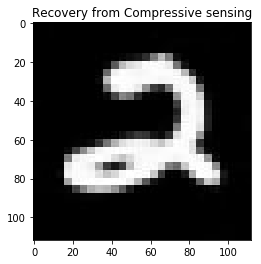

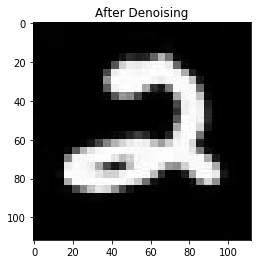

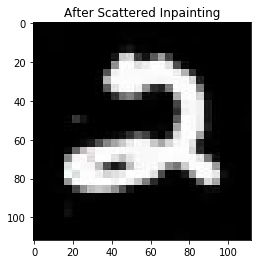

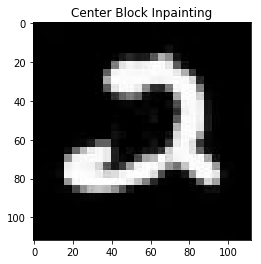

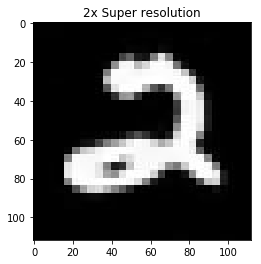

In [37]:
%cd
%cd OneNet/admm/clean_paper_results/0
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
image = mpimg.imread("./cs_ratio0.10_std0.00/ours_alpha0.300000/z.jpg")
plt.title("Recovery from Compressive sensing")
plt.imshow(image)
plt.show()

image = mpimg.imread("./denoise_ratio0.50_std0.10/ours_alpha0.300000/z.jpg")
plt.title("After Denoising")
plt.imshow(image)
plt.show()

image = mpimg.imread("./inpaint_bs2_tb10_std0.00/ours_alpha0.300000/z.jpg")
plt.title("After Scattered Inpainting")
plt.imshow(image)
plt.show()

image = mpimg.imread("./inpaintcenter_bs8_std0.00/ours_alpha0.200000/z.jpg")
plt.title("Center Block Inpainting")
plt.imshow(image)
plt.show()

image = mpimg.imread("./superres_ratio0.50_std0.00/ours_alpha0.500000/z.jpg")
plt.title("2x Super resolution")
plt.imshow(image)
plt.show()


<a class="anchor" id="10"></a>
## 10.0 Results of ADMM

<a class="anchor" id="10.1"></a>
### 10.1 MNIST

After training the MNIST dataset for 60000 iterations, we run ADMM to solve for **compressive sensing, denoising, inpaint blocks, inpaint center and super-resolution**

Since the input of compressive sensing cannot be visualized, we show the ground truth instead.

The model is available here - https://drive.google.com/drive/folders/1yrhsUdRla5EcbThW2N_z8ZMhgyL6CLNc?usp=sharing

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/mnist-1.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/mnist-2.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/mnist-3.png">
<br>


<a class="anchor" id="10.2"></a>
### 10.2 MS - CELEB - 1M and ImageNet

From the pre-trained models of MS-Celeb-1m and ImageNet, we recreate the results and compare it to the L1 prior (Wavelet Transform)

### MS-CELEB-1M 

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/ms-celeb-1.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/ms-celeb-2.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/ms-celeb-3.png">
<br>

### Imagenet

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/Imagenet_1.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/Imagenet_2.png">
<br>

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/Imagenet_3.png">
<br>



<a class="anchor" id="10.3"></a>
### 10.3 Recreating SOTA results and Comparison

### Center Region Inpainting
Blockwise inpainting seems to be the Achilles heel for OneNet. Let us compare it with the results from Context Encoders. The model for Context Encoders was used from here - https://github.com/pathak22/context-encoder
<br>
<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/Inpaint_1.png">
<br>


<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/Inpaint_2.png">
<br>

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/Inpaint_3.png">
<br>


**Blockwise inpainting on Imagenet does not give good results and it fills in the missing region with random images, thus not generating natural images.**

When it comes to Denoising and Super-resolution, OneNet seems to be doing better and has comparable results with SOTA techniques.

### Super-resolution:
OneNet seems to do a comparable job with the SOTA results from [Freedman, Gilad and Fattal, Raanan,2010] - (http://www.cs.huji.ac.il/~raananf/projects/lss_upscale/)

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/4x-1.png">
<br>

<img src="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/4x-2.png">
<br>


#### Denoising vs BM3D

And OneNet excels in DeNoising, creating results on par with BM3D - http://www.cs.tut.fi/~foi/GCF-BM3D/

<img src ="https://raw.githubusercontent.com/pavisj/images_onenet/master/results/denoising-vs-BM3D.png">
<br>



<a class="anchor" id="10.4"></a>
### 10.4 Failure Cases

Block-wise inpainting, especially on Imagenet seems to be failing with OneNet. It is trying to fill in random edges in the missing regions. In these cases, the projection network fails to project the inputs to the natural image set and hence affects the overall ADMM framework. 


### Conclusion

**OneNet enjoys the high flexibility of deep neural nets and wide applicability of traditional signal priors.**

With the ability to solve problems like denoising, inpainting, super-resolution and compressive sensing, OneNet resolves the scalability of specially-trained networks, which lowers the cost to design specialized hardware like ASIC to solve image processing tasks. 

Moreover, using optimization techniques on top of Neural networks can be seen a viable solution to improve convergence and thereby the performance.